<a href="https://colab.research.google.com/github/rudra404/NLP-RNN-Emotions-Classification/blob/main/GoEmotions_RNN_experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoEmotions Experiment 1: Testing different pretrained vectors
In this notebook,

### Set up steps for notebook
---
Required packages and dependencies are installed with compatible versions and the notebook is set up to use GPU when available.

---

In [ ]:
# Install datasets
!pip install datasets

# Install dependencies
%pip install torch==1.11.0+cu113 torchdata==0.3.0 torchtext==0.12.0 -f https://download.pytorch.org/whl/cu113/torch_stable.html
%pip install spacy tqdm
!python -m spacy download en_core_web_sm

# Initialise torch and use GPU
import torch
import torchtext

SEED = 1234
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("PyTorch Version: ", torch.__version__)
print("torchtext Version: ", torchtext.__version__)
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'}.")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-04-10 13:55:50.524780: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 13:55:52.506580: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-10 13:55:56.289765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Use this cell to mount your Google Drive on the notebook. Some files in the zip folder are used to reduce repeating of some setup steps.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Defining necessary functions and classes that will be used in each experiment

---
Functions for tokenizing the data and building vocabularies

---

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, vocab
from collections import OrderedDict
import torchtext.transforms as T

# defining a tokenizer as a PyTorch module
class SpacyTokenizer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

    def forward(self, input):
        if isinstance(input, list):
            tokens = []
            for text in input:
                tokens.append(self.tokenizer(text))
            return tokens
        elif isinstance(input, str):
            return self.tokenizer(input)
        raise ValueError(f"Type {type(input)} is not supported.")

# defining a function to transform each text into its length
class ToLengths(torch.nn.Module):
    def forward(self, input):
        if isinstance(input[1], list):    # changed to match the order in dataset
            lengths = []
            for text in input:
                lengths.append(len(text))
            return lengths
        elif isinstance(input, list):
            return len(input)
        raise ValueError(f"Type {type(input)} is not supported.")



---


Functions required for loading data in batches


---






In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

def collate_batch(batch):
    texts, labels = zip(*batch)

    lengths = lengths_transform(list(texts))
    texts = text_transform(list(texts))
    labels = torch.tensor(list(labels), dtype=torch.int64)

    return labels.to(DEVICE), texts.to(DEVICE), lengths.cpu()


def _get_dataloader(data):
    return DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)


---
Functions required for training and evaluation

---

In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
import time

# defining a function for training the model
# Taken from lab but changed to be used for multi-class classification training instead of binary classification

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in tqdm(iterator, desc="\tTraining"):
        optimizer.zero_grad()

        labels, texts, lengths = batch  # Note that this has to match the order in collate_batch
        predictions = model(texts, lengths)
        loss = criterion(predictions, labels)
        acc = categorical_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Defining a function to evaluate using the trained model (on either validation or test sets)
# Taken from lab 5 but changed to be used for multi-class classification evaluation instead of binary classification
# Further modified to return metrics like F1 score, confusion matrix, and classification report to check scores for each class
# ChatGPT was used for debugging aur_roc code

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    predicted_probs = []
    true_labels = []

    model.eval()

    with torch.no_grad():
        for batch in tqdm(iterator, desc="\tEvaluation"):
            labels, texts, lengths = batch  # Note that this has to match the order in collate_batch
            predictions = model(texts, lengths)
            probs = torch.softmax(predictions, dim=1)
            loss = criterion(predictions, labels)
            acc = categorical_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            predicted_probs.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predicted_probs = np.array(predicted_probs)
    true_labels = np.array(true_labels)
    predicted_labels = np.argmax(predicted_probs, axis=1)

    epoch_f1 = f1_score(true_labels, predicted_labels, average='weighted')
    epoch_auc_roc = roc_auc_score(true_labels, predicted_probs, multi_class='ovo', average='weighted')
    epoch_classification_report = classification_report(true_labels, predicted_labels)
    epoch_confusion_matrix = confusion_matrix(true_labels, predicted_labels)

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1, epoch_auc_roc, epoch_classification_report, epoch_confusion_matrix


# defining a function to check duration taken for training and testing
# taken from lab 5

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


#defining a function to check number of parameters in the model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# defining a categorical accuracy function instead of binary accuracy
# ChatGPT was used to find this piece of code and further debugging was required to make it work as expected

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc



---



---



---

Each variation tested has been implemented using two different methods of loading the pretrained vectors into the embedding layer of the RNN:
1. Initialize the embedding layer and then copy the weights from pretrained embeddings to this layer. Do not freeze so it is allowed to update with training. This is a type of fine-tuning the pretrained model.
2. Initialize the embedding layer with the pretrained weights and freeze these layers so they do not update while training.


## 1.A. GloVe vectors : 6B, dim = 100

In [ ]:
from torchtext.data.functional import to_map_style_dataset

text = torch.load("/content/drive/MyDrive/Colab Notebooks/NLP CW/preprocessed_data_1.pt")
data = to_map_style_dataset(text)
data[0]

["My favourite food is anything I didn't have to cook myself.", 0]

Splitting the dataset into train, test, and validation sets

In [ ]:
from torch.utils.data import random_split

split_ratio = 0.7  # 70/30 split

# split dataset into train and test sets
train_samples = int(split_ratio * len(data))
test_samples = len(data) - train_samples
train_data, test_data = random_split(data, [train_samples, test_samples])

# split train subset into train and validation sets
train_samples = int(split_ratio * len(train_data))
valid_samples = len(train_data) - train_samples
train_data, valid_data = random_split(train_data, [train_samples, valid_samples])

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 20153
Number of validation examples: 8638
Number of testing examples: 12340


In [ ]:
from torchtext import vocab

MAX_VOCAB_SIZE = 25_000

glove_vectors = vocab.GloVe(
    name="6B",
    dim=100,
    max_vectors=MAX_VOCAB_SIZE
)


.vector_cache/glove.6B.zip: 862MB [02:38, 5.43MB/s]                           
100%|█████████▉| 24999/25000 [00:03<00:00, 7038.20it/s]


In [ ]:
from torchtext.vocab import vocab

text_vocab = vocab(glove_vectors.stoi, min_freq=0, specials=("<unk>", "<pad>"), special_first=True)
text_vocab.set_default_index(text_vocab["<unk>"])

pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat([
    torch.empty(1, glove_vectors.dim).normal_(),  # unk token vector
    torch.zeros(1, glove_vectors.dim),  # padding token vector
    pretrained_embeddings
])

print("Vocab size: ", len(text_vocab))
print("Pretrained vectors shape: ", pretrained_embeddings.shape)
print("<unk> vector: ", pretrained_embeddings[text_vocab["<unk>"]])
print("<pad> vector: ", pretrained_embeddings[text_vocab["<pad>"]])

Vocab size:  25002
Pretrained vectors shape:  torch.Size([25002, 100])
<unk> vector:  tensor([-3.2159e-01, -5.7777e-01, -2.9265e-02, -1.1300e+00, -3.0162e-02,
         4.9286e-01, -1.8823e-01,  7.8837e-01,  2.8984e-01, -1.5768e-01,
         2.6025e-02, -4.0680e-01,  9.8217e-01,  2.1075e+00, -8.3877e-01,
         7.2692e-01, -4.6005e-01,  9.6681e-01,  1.5570e-03,  2.8862e-01,
         7.7407e-01,  5.9272e-01, -5.3478e-01,  1.4071e+00, -2.9485e-01,
         2.2609e-02, -1.9177e-02, -2.3892e+00, -2.7957e-01,  1.6830e+00,
        -7.0656e-01,  2.2796e+00,  1.2711e+00, -4.5737e-01,  5.1229e-01,
        -6.0672e-01, -7.9999e-01,  1.3928e-01,  1.1280e+00,  7.6980e-01,
        -1.2025e+00, -1.1466e+00, -5.6061e-01,  6.0446e-01, -7.0300e-01,
         1.5256e+00, -2.6371e-01,  1.2136e+00, -5.6502e-01,  3.1753e-01,
        -9.6363e-01, -7.4075e-01, -1.0862e-02,  1.2579e-01,  4.8800e-01,
         3.4939e-01,  1.1748e+00, -1.4255e+00, -5.2518e-01, -6.4616e-01,
         3.0664e-01,  1.5075e+00,  6.4

In [ ]:
from collections import OrderedDict
label_vocab = vocab(OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)]))


In [ ]:
import torchtext.transforms as T

text_transform = T.Sequential(
    SpacyTokenizer(),  # Tokenize
    T.VocabTransform(text_vocab),  # Conver to vocab IDs
    T.ToTensor(padding_value=text_vocab["<pad>"]),  # Convert to tensor and pad
)

label_transform = T.Sequential(
    # T.LabelToIndex(label_vocab.get_itos()),  # Convert to integer #labels are already integers
    T.ToTensor(),  # Convert to tensor
)

lengths_transform = T.Sequential(
    SpacyTokenizer(),
    ToLengths(),
    T.ToTensor(),
)

In [ ]:
train_dataloader = _get_dataloader(train_data)
valid_dataloader = _get_dataloader(valid_data)
test_dataloader = _get_dataloader(test_data)

In [ ]:
# text_vocab = torch.load("text_vocab.pt")
# label_vocab = torch.load("label_vocab.pt")

In [ ]:
import torch.nn as nn
from torch import optim

# Define an RNN class
class pretrainedRNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pretrained_embeddings):
        super().__init__()
        # self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=pad_idx)

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings) # copy pre-trained vectors to embedding layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.fc = nn.Linear(hidden_dim, output_dim[1]) # output_dim[0] is hidden_dim, output_dim[1] is output_dim

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)                          # VV note that lengths need to be on the CPU
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        output, hidden = self.rnn(embedded)

        return self.fc(hidden.squeeze(0))


# Setting model building arguments
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_vocab) # 14 output nodes

model = pretrainedRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, pretrained_embeddings) # create a RNN model using the arguments
print(f'The model has {count_parameters(model):,} trainable parameters')

# Set other parameters
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Use GPU
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

The model has 2,595,446 trainable parameters


In [ ]:
######
N_EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    # valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    valid_loss, valid_acc, valid_f1, valid_auc_roc, valid_report, valid_cm  = evaluate(model, valid_dataloader, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model-glove.pt')


Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 315/315 [00:06<00:00, 45.43it/s]


	Train Loss: 2.059 | Train Acc: 40.07%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 50.99it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.932 |  Val. Acc: 43.64%
Epoch: 02


	Training: 100%|██████████| 315/315 [00:03<00:00, 87.99it/s]


	Train Loss: 1.909 | Train Acc: 43.29%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.83it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.907 |  Val. Acc: 45.01%
Epoch: 03


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.41it/s]


	Train Loss: 1.854 | Train Acc: 44.17%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.56it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.863 |  Val. Acc: 45.93%
Epoch: 04


	Training: 100%|██████████| 315/315 [00:04<00:00, 66.50it/s]


	Train Loss: 1.811 | Train Acc: 45.18%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.02it/s] 
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 2.085 |  Val. Acc: 40.52%
Epoch: 05


	Training: 100%|██████████| 315/315 [00:03<00:00, 89.35it/s]


	Train Loss: 1.931 | Train Acc: 42.19%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 130.78it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.889 |  Val. Acc: 44.40%
Epoch: 06


	Training: 100%|██████████| 315/315 [00:03<00:00, 89.32it/s]


	Train Loss: 1.737 | Train Acc: 47.54%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.99it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.901 |  Val. Acc: 44.88%
Epoch: 07


	Training: 100%|██████████| 315/315 [00:05<00:00, 62.82it/s]


	Train Loss: 1.652 | Train Acc: 49.86%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 104.51it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.824 |  Val. Acc: 46.57%
Epoch: 08


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.61it/s]


	Train Loss: 1.505 | Train Acc: 53.61%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 130.44it/s]


	 Val. Loss: 1.861 |  Val. Acc: 44.84%
Epoch: 09


	Training: 100%|██████████| 315/315 [00:03<00:00, 89.28it/s]


	Train Loss: 1.392 | Train Acc: 56.64%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 129.66it/s]


	 Val. Loss: 1.908 |  Val. Acc: 45.32%
Epoch: 10


	Training: 100%|██████████| 315/315 [00:05<00:00, 62.68it/s]


	Train Loss: 1.294 | Train Acc: 59.56%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 124.18it/s]


	 Val. Loss: 1.904 |  Val. Acc: 45.00%
Epoch: 11


	Training: 100%|██████████| 315/315 [00:03<00:00, 89.01it/s]


	Train Loss: 1.262 | Train Acc: 60.81%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 129.47it/s]


	 Val. Loss: 2.056 |  Val. Acc: 40.45%
Epoch: 12


	Training: 100%|██████████| 315/315 [00:05<00:00, 62.26it/s]


	Train Loss: 1.175 | Train Acc: 63.38%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 56.63it/s]


	 Val. Loss: 2.070 |  Val. Acc: 43.34%
Epoch: 13


	Training: 100%|██████████| 315/315 [00:04<00:00, 74.95it/s]


	Train Loss: 1.255 | Train Acc: 61.11%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.61it/s]


	 Val. Loss: 2.258 |  Val. Acc: 42.86%
Epoch: 14


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.52it/s]


	Train Loss: 1.038 | Train Acc: 67.79%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.29it/s]


	 Val. Loss: 2.231 |  Val. Acc: 43.33%
Epoch: 15


	Training: 100%|██████████| 315/315 [00:04<00:00, 76.91it/s]


	Train Loss: 0.929 | Train Acc: 71.14%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 87.75it/s]


	 Val. Loss: 2.289 |  Val. Acc: 42.58%
Epoch: 16


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.42it/s]


	Train Loss: 0.870 | Train Acc: 72.75%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.21it/s]


	 Val. Loss: 2.422 |  Val. Acc: 38.16%
Epoch: 17


	Training: 100%|██████████| 315/315 [00:03<00:00, 89.43it/s]


	Train Loss: 0.782 | Train Acc: 75.62%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 130.86it/s]


	 Val. Loss: 2.541 |  Val. Acc: 38.20%
Epoch: 18


	Training: 100%|██████████| 315/315 [00:04<00:00, 74.74it/s]


	Train Loss: 0.724 | Train Acc: 77.58%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.91it/s]


	 Val. Loss: 2.698 |  Val. Acc: 35.89%
Epoch: 19


	Training: 100%|██████████| 315/315 [00:03<00:00, 82.33it/s]


	Train Loss: 0.710 | Train Acc: 78.25%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 131.85it/s]


	 Val. Loss: 2.707 |  Val. Acc: 38.58%
Epoch: 20


	Training: 100%|██████████| 315/315 [00:03<00:00, 88.92it/s]


	Train Loss: 0.697 | Train Acc: 78.72%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.41it/s]


	 Val. Loss: 2.787 |  Val. Acc: 34.15%
Epoch: 21


	Training: 100%|██████████| 315/315 [00:04<00:00, 71.42it/s]


	Train Loss: 0.695 | Train Acc: 78.46%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 85.38it/s]


	 Val. Loss: 2.907 |  Val. Acc: 37.12%
Epoch: 22


	Training: 100%|██████████| 315/315 [00:03<00:00, 87.24it/s]


	Train Loss: 0.536 | Train Acc: 83.37%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 127.24it/s]


	 Val. Loss: 3.000 |  Val. Acc: 38.23%
Epoch: 23


	Training: 100%|██████████| 315/315 [00:03<00:00, 89.89it/s]


	Train Loss: 0.453 | Train Acc: 86.28%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 126.95it/s]


	 Val. Loss: 3.182 |  Val. Acc: 38.20%
Epoch: 24


	Training: 100%|██████████| 315/315 [00:04<00:00, 65.28it/s]


	Train Loss: 0.434 | Train Acc: 86.75%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.11it/s]


	 Val. Loss: 3.435 |  Val. Acc: 35.53%
Epoch: 25


	Training: 100%|██████████| 315/315 [00:03<00:00, 89.74it/s]


	Train Loss: 0.383 | Train Acc: 88.29%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.75it/s]


	 Val. Loss: 3.461 |  Val. Acc: 36.36%
Epoch: 26


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.05it/s]


	Train Loss: 0.471 | Train Acc: 85.27%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.81it/s]


	 Val. Loss: 3.467 |  Val. Acc: 35.82%
Epoch: 27


	Training: 100%|██████████| 315/315 [00:04<00:00, 63.85it/s]


	Train Loss: 0.420 | Train Acc: 87.25%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 105.22it/s]


	 Val. Loss: 3.570 |  Val. Acc: 37.30%
Epoch: 28


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.63it/s]


	Train Loss: 0.297 | Train Acc: 91.09%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.35it/s]


	 Val. Loss: 3.712 |  Val. Acc: 36.93%
Epoch: 29


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.94it/s]


	Train Loss: 0.256 | Train Acc: 92.28%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.17it/s]


	 Val. Loss: 3.970 |  Val. Acc: 37.10%
Epoch: 30


	Training: 100%|██████████| 315/315 [00:04<00:00, 63.45it/s]


	Train Loss: 0.206 | Train Acc: 93.94%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 122.86it/s]


	 Val. Loss: 4.208 |  Val. Acc: 35.48%
Epoch: 31


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.44it/s]


	Train Loss: 0.234 | Train Acc: 92.82%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.64it/s]


	 Val. Loss: 4.252 |  Val. Acc: 38.10%
Epoch: 32


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.55it/s]


	Train Loss: 0.220 | Train Acc: 93.25%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 47.30it/s]


	 Val. Loss: 4.353 |  Val. Acc: 35.80%
Epoch: 33


	Training: 100%|██████████| 315/315 [00:04<00:00, 69.21it/s]


	Train Loss: 0.249 | Train Acc: 92.23%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.90it/s]


	 Val. Loss: 4.427 |  Val. Acc: 36.18%
Epoch: 34


	Training: 100%|██████████| 315/315 [00:03<00:00, 89.95it/s]


	Train Loss: 0.205 | Train Acc: 93.62%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 130.15it/s]


	 Val. Loss: 4.530 |  Val. Acc: 35.67%
Epoch: 35


	Training: 100%|██████████| 315/315 [00:03<00:00, 86.84it/s]


	Train Loss: 0.176 | Train Acc: 94.59%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.14it/s]


	 Val. Loss: 4.744 |  Val. Acc: 34.56%
Epoch: 36


	Training: 100%|██████████| 315/315 [00:04<00:00, 71.30it/s]


	Train Loss: 0.212 | Train Acc: 93.34%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 131.94it/s]


	 Val. Loss: 4.679 |  Val. Acc: 35.65%
Epoch: 37


	Training: 100%|██████████| 315/315 [00:04<00:00, 65.98it/s]


	Train Loss: 0.241 | Train Acc: 92.25%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.44it/s]


	 Val. Loss: 4.861 |  Val. Acc: 34.73%
Epoch: 38


	Training: 100%|██████████| 315/315 [00:12<00:00, 25.83it/s]


	Train Loss: 0.161 | Train Acc: 95.09%


	Evaluation: 100%|██████████| 135/135 [00:03<00:00, 41.69it/s]


	 Val. Loss: 4.967 |  Val. Acc: 37.42%
Epoch: 39


	Training: 100%|██████████| 315/315 [00:10<00:00, 29.71it/s]


	Train Loss: 0.146 | Train Acc: 95.54%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 65.80it/s]


	 Val. Loss: 4.974 |  Val. Acc: 36.26%
Epoch: 40


	Training: 100%|██████████| 315/315 [00:03<00:00, 89.21it/s]


	Train Loss: 0.111 | Train Acc: 96.77%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 126.16it/s]


	 Val. Loss: 5.084 |  Val. Acc: 35.55%
Epoch: 41


	Training: 100%|██████████| 315/315 [00:04<00:00, 75.05it/s]


	Train Loss: 0.147 | Train Acc: 95.61%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.47it/s]


	 Val. Loss: 5.229 |  Val. Acc: 34.22%
Epoch: 42


	Training: 100%|██████████| 315/315 [00:03<00:00, 81.23it/s]


	Train Loss: 0.395 | Train Acc: 87.76%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 127.17it/s]


	 Val. Loss: 4.778 |  Val. Acc: 35.61%
Epoch: 43


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.92it/s]


	Train Loss: 0.220 | Train Acc: 93.11%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.75it/s]


	 Val. Loss: 4.847 |  Val. Acc: 35.59%
Epoch: 44


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.26it/s]


	Train Loss: 0.128 | Train Acc: 96.24%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 87.02it/s]


	 Val. Loss: 5.086 |  Val. Acc: 36.94%
Epoch: 45


	Training: 100%|██████████| 315/315 [00:03<00:00, 85.35it/s]


	Train Loss: 0.072 | Train Acc: 98.14%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.87it/s]


	 Val. Loss: 5.201 |  Val. Acc: 36.53%
Epoch: 46


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.99it/s]


	Train Loss: 0.053 | Train Acc: 98.66%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.95it/s]


	 Val. Loss: 5.285 |  Val. Acc: 36.75%
Epoch: 47


	Training: 100%|██████████| 315/315 [00:04<00:00, 70.97it/s]


	Train Loss: 0.067 | Train Acc: 98.22%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 83.46it/s]


	 Val. Loss: 5.457 |  Val. Acc: 35.74%
Epoch: 48


	Training: 100%|██████████| 315/315 [00:03<00:00, 89.23it/s]


	Train Loss: 0.190 | Train Acc: 93.96%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 130.30it/s]


	 Val. Loss: 5.264 |  Val. Acc: 35.17%
Epoch: 49


	Training: 100%|██████████| 315/315 [00:03<00:00, 89.57it/s]


	Train Loss: 0.435 | Train Acc: 86.83%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.31it/s]


	 Val. Loss: 4.883 |  Val. Acc: 32.74%
Epoch: 50


	Training: 100%|██████████| 315/315 [00:04<00:00, 67.02it/s]


	Train Loss: 0.252 | Train Acc: 92.08%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.53it/s]


	 Val. Loss: 4.972 |  Val. Acc: 34.75%


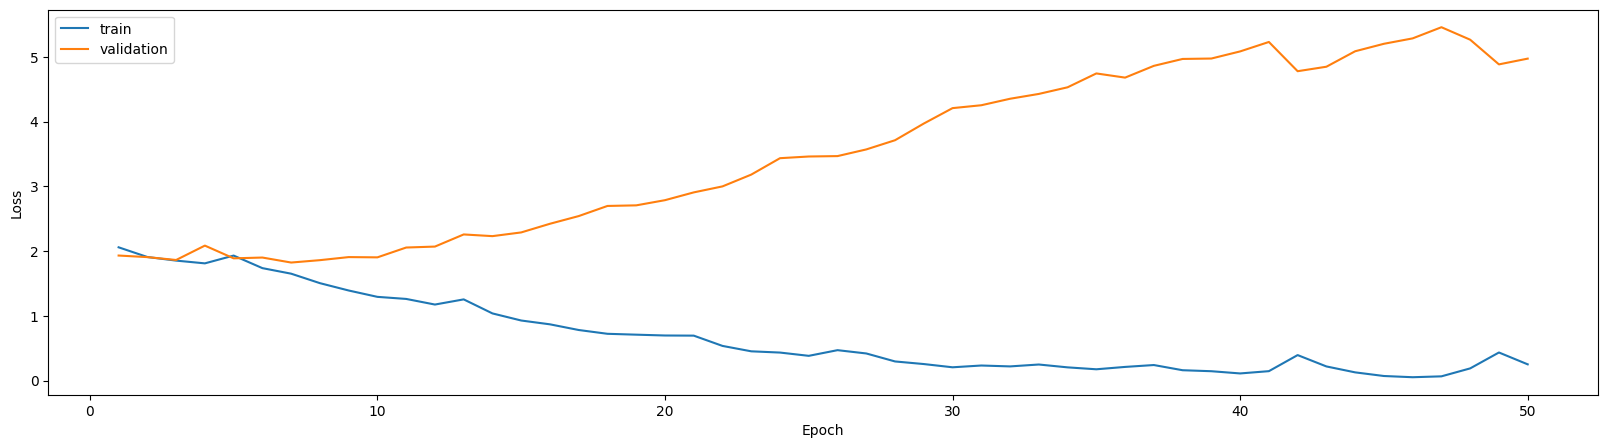

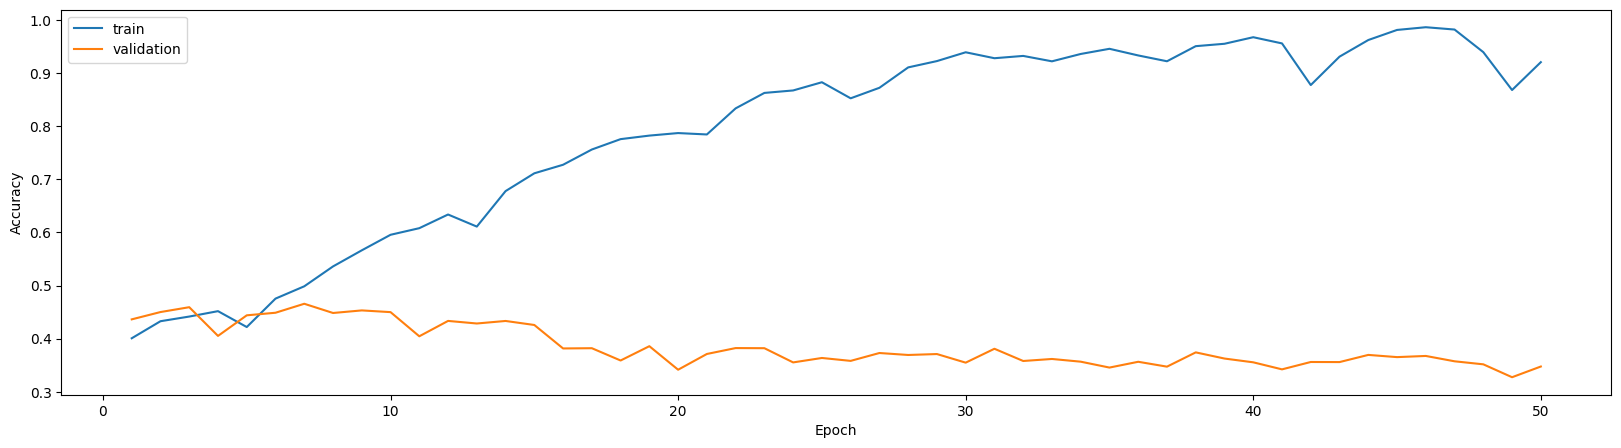

	Evaluation: 100%|██████████| 193/193 [00:02<00:00, 85.84it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test Loss: 1.801 | Test Acc: 47.24% | Test F1: 0.403 | Test ROC AUC: 0.742

Classification report:
              precision    recall  f1-score   support

           0       0.51      0.83      0.63      4983
           1       0.30      0.13      0.18       672
           2       0.32      0.11      0.17      1070
           3       0.39      0.21      0.27       667
           4       0.12      0.04      0.06       837
           5       0.39      0.14      0.21       144
           6       0.25      0.01      0.02       351
           7       0.40      0.20      0.27       551
           8       0.00      0.00      0.00       200
           9       0.56      0.65      0.60       614
          10       0.17      0.01      0.02       570
          11       0.40      0.20      0.27       208
          12       0.54      0.64      0.58       844
          13       0.24      0.29      0.27       629

    accuracy                           0.47     12340
   macro avg       0.33      0.25 

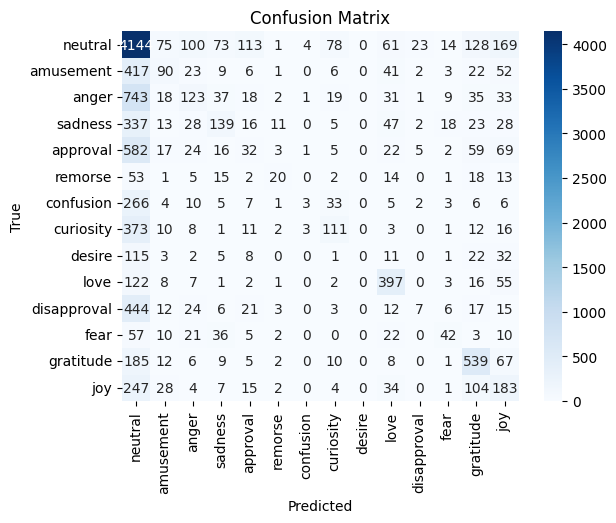

In [ ]:
# plot training curves

import matplotlib.pyplot as plt

# create epoch list
epochs = list(range(1, N_EPOCHS+1))

# plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, valid_loss_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, valid_acc_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#######
# print out required metrics

import seaborn as sns
model.load_state_dict(torch.load('model-glove.pt'))

test_loss, test_acc, test_f1, test_roc_auc, test_report, test_cm = evaluate(model, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f} | Test ROC AUC: {test_roc_auc:.3f}\n')
# print(f'Confusion matrix:\n{test_cm}')
print(f'Classification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



---



---



---



In [ ]:
import torch.nn as nn
from torch import optim

# Define an RNN class
class pretrainedRNN1(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pretrained_embeddings, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=pad_idx)
        # self.embedding = nn.Embedding(input_dim, embedding_dim)
        # self.embedding.weight.data.copy_(pretrained_embeddings) # copy pre-trained vectors to embedding layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.fc = nn.Linear(hidden_dim, output_dim[1]) # output_dim[0] is hidden_dim, output_dim[1] is output_dim

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)                          # VV note that lengths need to be on the CPU
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        output, hidden = self.rnn(embedded)

        return self.fc(hidden.squeeze(0))


# Setting model building arguments
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_vocab) # 14 output nodes
PAD_IDX = text_vocab["<pad>"]

model_glove_1 = pretrainedRNN1(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, pretrained_embeddings, PAD_IDX) # create a RNN model using the arguments
print(f'The model has {count_parameters(model_glove_1):,} trainable parameters')

# Set other parameters
optimizer = optim.Adam(model_glove_1.parameters())
criterion = nn.CrossEntropyLoss()

# Use GPU
model_glove_1 = model_glove_1.to(DEVICE)
criterion = criterion.to(DEVICE)

The model has 95,246 trainable parameters


In [ ]:
######
N_EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model_glove_1, train_dataloader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    # valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    valid_loss, valid_acc, valid_f1, valid_auc_roc, valid_report, valid_cm  = evaluate(model_glove_1, valid_dataloader, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_glove_1.state_dict(), 'model_glove_1.pt')


Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 315/315 [00:03<00:00, 87.71it/s]


	Train Loss: 2.063 | Train Acc: 39.90%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 91.82it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 2.019 |  Val. Acc: 41.14%
Epoch: 02


	Training: 100%|██████████| 315/315 [00:03<00:00, 91.24it/s] 


	Train Loss: 1.970 | Train Acc: 41.50%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.13it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 2.079 |  Val. Acc: 41.26%
Epoch: 03


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.63it/s]


	Train Loss: 1.913 | Train Acc: 42.86%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.40it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.972 |  Val. Acc: 42.30%
Epoch: 04


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.54it/s]


	Train Loss: 1.887 | Train Acc: 43.23%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 92.21it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.888 |  Val. Acc: 44.69%
Epoch: 05


	Training: 100%|██████████| 315/315 [00:04<00:00, 76.56it/s] 


	Train Loss: 1.959 | Train Acc: 41.54%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.10it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.942 |  Val. Acc: 42.42%
Epoch: 06


	Training: 100%|██████████| 315/315 [00:02<00:00, 109.20it/s]


	Train Loss: 1.896 | Train Acc: 42.72%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.94it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.948 |  Val. Acc: 42.41%
Epoch: 07


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.58it/s]


	Train Loss: 1.906 | Train Acc: 42.96%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.92it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.995 |  Val. Acc: 40.72%
Epoch: 08


	Training: 100%|██████████| 315/315 [00:04<00:00, 71.81it/s]


	Train Loss: 1.917 | Train Acc: 42.35%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 103.66it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.910 |  Val. Acc: 43.69%
Epoch: 09


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.77it/s]


	Train Loss: 1.832 | Train Acc: 44.29%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.83it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.925 |  Val. Acc: 43.57%
Epoch: 10


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.47it/s]


	Train Loss: 1.947 | Train Acc: 42.57%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.77it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 2.004 |  Val. Acc: 41.83%
Epoch: 11


	Training: 100%|██████████| 315/315 [00:03<00:00, 80.51it/s]


	Train Loss: 1.897 | Train Acc: 43.74%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.56it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.883 |  Val. Acc: 45.20%
Epoch: 12


	Training: 100%|██████████| 315/315 [00:03<00:00, 96.45it/s] 


	Train Loss: 1.859 | Train Acc: 43.98%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.77it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.858 |  Val. Acc: 45.07%
Epoch: 13


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.52it/s]


	Train Loss: 1.774 | Train Acc: 46.29%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.99it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.924 |  Val. Acc: 44.76%
Epoch: 14


	Training: 100%|██████████| 315/315 [00:03<00:00, 95.36it/s]


	Train Loss: 1.766 | Train Acc: 46.23%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 93.74it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.908 |  Val. Acc: 44.52%
Epoch: 15


	Training: 100%|██████████| 315/315 [00:05<00:00, 62.82it/s] 


	Train Loss: 1.855 | Train Acc: 44.13%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 131.42it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.961 |  Val. Acc: 42.88%
Epoch: 16


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.36it/s]


	Train Loss: 1.819 | Train Acc: 44.38%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.58it/s]


	 Val. Loss: 1.904 |  Val. Acc: 43.55%
Epoch: 17


	Training: 100%|██████████| 315/315 [00:03<00:00, 100.50it/s]


	Train Loss: 1.777 | Train Acc: 45.37%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 92.33it/s]


	 Val. Loss: 1.914 |  Val. Acc: 43.51%
Epoch: 18


	Training: 100%|██████████| 315/315 [00:03<00:00, 78.88it/s] 


	Train Loss: 1.777 | Train Acc: 44.77%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.23it/s]


	 Val. Loss: 1.923 |  Val. Acc: 42.68%
Epoch: 19


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.15it/s]


	Train Loss: 1.700 | Train Acc: 47.36%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.83it/s]


	 Val. Loss: 1.957 |  Val. Acc: 44.37%
Epoch: 20


	Training: 100%|██████████| 315/315 [00:02<00:00, 108.63it/s]


	Train Loss: 1.729 | Train Acc: 46.61%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.48it/s]


	 Val. Loss: 1.918 |  Val. Acc: 41.18%
Epoch: 21


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.17it/s]


	Train Loss: 1.694 | Train Acc: 47.52%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 120.03it/s]


	 Val. Loss: 2.016 |  Val. Acc: 39.76%
Epoch: 22


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.07it/s]


	Train Loss: 1.673 | Train Acc: 48.27%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.02it/s]


	 Val. Loss: 1.889 |  Val. Acc: 44.33%
Epoch: 23


	Training: 100%|██████████| 315/315 [00:02<00:00, 108.18it/s]


	Train Loss: 1.623 | Train Acc: 49.23%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.95it/s]


	 Val. Loss: 1.866 |  Val. Acc: 46.35%
Epoch: 24


	Training: 100%|██████████| 315/315 [00:03<00:00, 82.02it/s]


	Train Loss: 1.652 | Train Acc: 48.17%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 91.32it/s]


	 Val. Loss: 1.917 |  Val. Acc: 42.95%
Epoch: 25


	Training: 100%|██████████| 315/315 [00:03<00:00, 101.23it/s]


	Train Loss: 1.609 | Train Acc: 49.28%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.88it/s]


	 Val. Loss: 1.877 |  Val. Acc: 45.57%
Epoch: 26


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.44it/s]


	Train Loss: 1.633 | Train Acc: 49.13%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.87it/s]


	 Val. Loss: 1.909 |  Val. Acc: 44.56%
Epoch: 27


	Training: 100%|██████████| 315/315 [00:03<00:00, 96.77it/s]


	Train Loss: 1.594 | Train Acc: 49.93%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.58it/s]


	 Val. Loss: 2.224 |  Val. Acc: 27.18%
Epoch: 28


	Training: 100%|██████████| 315/315 [00:03<00:00, 82.12it/s] 


	Train Loss: 1.768 | Train Acc: 45.52%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.32it/s]


	 Val. Loss: 1.933 |  Val. Acc: 43.12%
Epoch: 29


	Training: 100%|██████████| 315/315 [00:02<00:00, 108.37it/s]


	Train Loss: 1.541 | Train Acc: 51.18%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 141.01it/s]


	 Val. Loss: 1.844 |  Val. Acc: 46.33%
Epoch: 30


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.72it/s]


	Train Loss: 1.528 | Train Acc: 51.75%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 112.24it/s]


	 Val. Loss: 1.873 |  Val. Acc: 44.29%
Epoch: 31


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.18it/s]


	Train Loss: 1.552 | Train Acc: 50.90%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.61it/s]


	 Val. Loss: 1.924 |  Val. Acc: 43.72%
Epoch: 32


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.20it/s]


	Train Loss: 1.580 | Train Acc: 50.43%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.54it/s]


	 Val. Loss: 1.924 |  Val. Acc: 42.75%
Epoch: 33


	Training: 100%|██████████| 315/315 [00:02<00:00, 108.07it/s]


	Train Loss: 1.482 | Train Acc: 52.62%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.79it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 2.197 |  Val. Acc: 41.79%
Epoch: 34


	Training: 100%|██████████| 315/315 [00:04<00:00, 77.15it/s]


	Train Loss: 1.612 | Train Acc: 49.16%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.93it/s]


	 Val. Loss: 1.929 |  Val. Acc: 44.36%
Epoch: 35


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.50it/s]


	Train Loss: 1.485 | Train Acc: 52.74%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.21it/s]


	 Val. Loss: 2.190 |  Val. Acc: 42.23%
Epoch: 36


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.13it/s]


	Train Loss: 1.591 | Train Acc: 49.81%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.79it/s]


	 Val. Loss: 1.937 |  Val. Acc: 44.28%
Epoch: 37


	Training: 100%|██████████| 315/315 [00:03<00:00, 89.59it/s]


	Train Loss: 1.809 | Train Acc: 44.58%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 92.07it/s]


	 Val. Loss: 1.994 |  Val. Acc: 41.75%
Epoch: 38


	Training: 100%|██████████| 315/315 [00:03<00:00, 87.13it/s] 


	Train Loss: 1.703 | Train Acc: 46.71%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 141.48it/s]


	 Val. Loss: 1.995 |  Val. Acc: 41.34%
Epoch: 39


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.52it/s]


	Train Loss: 1.623 | Train Acc: 48.68%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.12it/s]


	 Val. Loss: 2.015 |  Val. Acc: 41.95%
Epoch: 40


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.49it/s]


	Train Loss: 1.518 | Train Acc: 51.67%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 98.91it/s]


	 Val. Loss: 1.931 |  Val. Acc: 44.37%
Epoch: 41


	Training: 100%|██████████| 315/315 [00:04<00:00, 73.30it/s]


	Train Loss: 1.497 | Train Acc: 52.59%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.56it/s]


	 Val. Loss: 1.957 |  Val. Acc: 43.01%
Epoch: 42


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.36it/s]


	Train Loss: 1.410 | Train Acc: 54.78%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.88it/s]


	 Val. Loss: 1.988 |  Val. Acc: 44.98%
Epoch: 43


	Training: 100%|██████████| 315/315 [00:02<00:00, 108.48it/s]


	Train Loss: 1.494 | Train Acc: 52.50%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.65it/s]


	 Val. Loss: 1.963 |  Val. Acc: 44.39%
Epoch: 44


	Training: 100%|██████████| 315/315 [00:04<00:00, 75.53it/s]


	Train Loss: 1.340 | Train Acc: 56.44%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.12it/s]


	 Val. Loss: 2.007 |  Val. Acc: 42.86%
Epoch: 45


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.36it/s]


	Train Loss: 1.531 | Train Acc: 51.97%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.43it/s]


	 Val. Loss: 2.009 |  Val. Acc: 42.76%
Epoch: 46


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.70it/s]


	Train Loss: 1.622 | Train Acc: 48.87%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.11it/s]


	 Val. Loss: 2.057 |  Val. Acc: 41.45%
Epoch: 47


	Training: 100%|██████████| 315/315 [00:03<00:00, 89.96it/s]


	Train Loss: 1.603 | Train Acc: 49.55%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 91.19it/s]


	 Val. Loss: 1.981 |  Val. Acc: 43.38%
Epoch: 48


	Training: 100%|██████████| 315/315 [00:03<00:00, 87.14it/s] 


	Train Loss: 1.393 | Train Acc: 55.37%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.00it/s]


	 Val. Loss: 2.008 |  Val. Acc: 43.57%
Epoch: 49


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.00it/s]


	Train Loss: 1.338 | Train Acc: 56.79%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 126.14it/s]


	 Val. Loss: 2.027 |  Val. Acc: 42.07%
Epoch: 50


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.18it/s]


	Train Loss: 1.324 | Train Acc: 56.68%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.80it/s]


	 Val. Loss: 2.047 |  Val. Acc: 41.45%


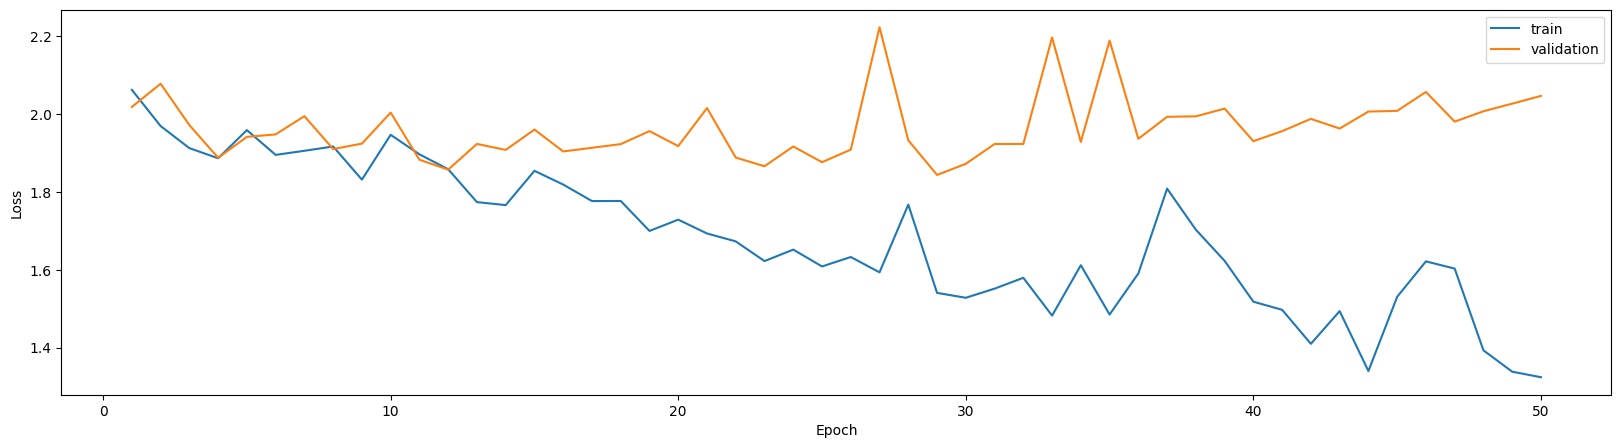

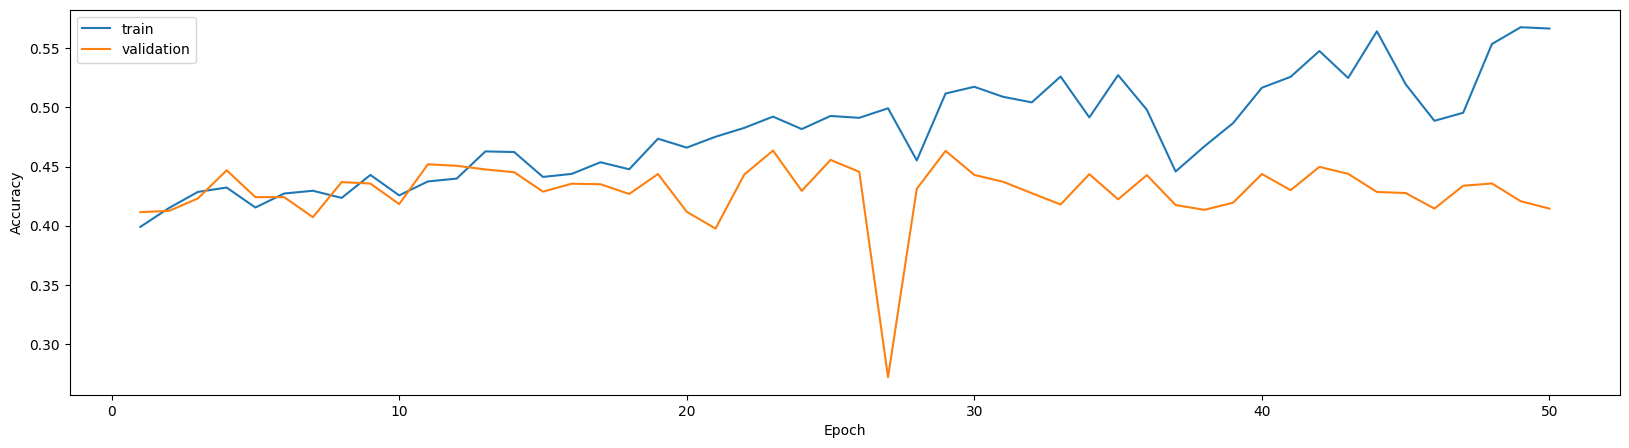

	Evaluation: 100%|██████████| 193/193 [00:02<00:00, 91.63it/s]



Test Loss: 2.027 | Test Acc: 41.92% | Test F1: 0.378 | Test ROC AUC: 0.713

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.71      0.59      4983
           1       0.24      0.13      0.17       672
           2       0.26      0.12      0.16      1070
           3       0.27      0.07      0.11       667
           4       0.11      0.08      0.10       837
           5       0.16      0.07      0.10       144
           6       0.10      0.07      0.09       351
           7       0.33      0.25      0.29       551
           8       0.00      0.00      0.00       200
           9       0.63      0.54      0.58       614
          10       0.12      0.14      0.13       570
          11       0.27      0.07      0.11       208
          12       0.50      0.68      0.58       844
          13       0.31      0.20      0.24       629

    accuracy                           0.42     12340
   macro avg       0.27      0.22 

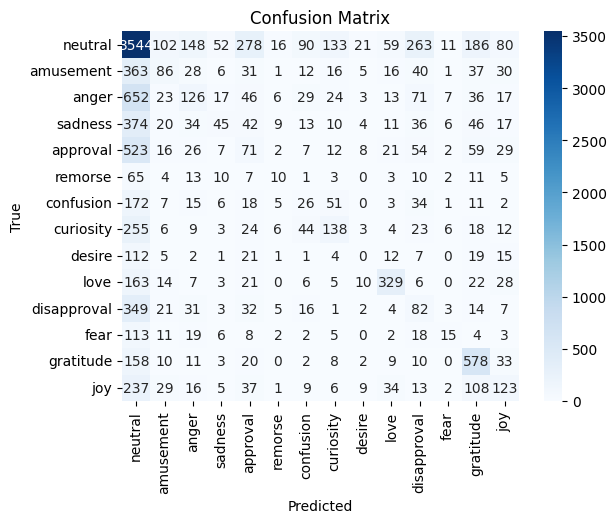

In [ ]:
# plot training curves

import matplotlib.pyplot as plt

# create epoch list
epochs = list(range(1, N_EPOCHS+1))

# plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, valid_loss_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, valid_acc_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#######
# print out required metrics

import seaborn as sns
model.load_state_dict(torch.load('model_glove_1.pt'))

test_loss, test_acc, test_f1, test_roc_auc, test_report, test_cm = evaluate(model_glove_1, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f} | Test ROC AUC: {test_roc_auc:.3f}\n')
# print(f'Confusion matrix:\n{test_cm}')
print(f'Classification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()




---



---



---

## 1.B. GloVe vectors : 42B, dim = 300

In [ ]:
# import torchtext
from torchtext import vocab

# torchtext.utils.download_from_url("https://nlp.stanford.edu/data/glove.42B.100d.zip", root=".vector_cache")

MAX_VOCAB_SIZE = 25_000

glove_vectors1 = vocab.GloVe(
    name="42B",
    dim=300,
    max_vectors=MAX_VOCAB_SIZE
)

100%|█████████▉| 24999/25000 [00:02<00:00, 9350.80it/s] 


In [ ]:
from torchtext.vocab import vocab

text_vocab = vocab(glove_vectors1.stoi, min_freq=0, specials=("<unk>", "<pad>"), special_first=True)
text_vocab.set_default_index(text_vocab["<unk>"])

pretrained_embeddings = glove_vectors1.vectors
pretrained_embeddings = torch.cat([
    torch.empty(1, glove_vectors1.dim).normal_(),  # unk token vector
    torch.zeros(1, glove_vectors1.dim),  # padding token vector
    pretrained_embeddings
])

print("Vocab size: ", len(text_vocab))
print("Pretrained vectors shape: ", pretrained_embeddings.shape)
print("<unk> vector: ", pretrained_embeddings[text_vocab["<unk>"]])
print("<pad> vector: ", pretrained_embeddings[text_vocab["<pad>"]])

Vocab size:  25002
Pretrained vectors shape:  torch.Size([25002, 300])
<unk> vector:  tensor([-3.2159e-01, -5.7777e-01, -2.9265e-02, -1.1300e+00, -3.0162e-02,
         4.9286e-01, -1.8823e-01,  7.8837e-01,  2.8984e-01, -1.5768e-01,
         2.6025e-02, -4.0680e-01,  9.8217e-01,  2.1075e+00, -8.3877e-01,
         7.2692e-01, -4.6005e-01,  9.6681e-01,  1.5570e-03,  2.8862e-01,
         7.7407e-01,  5.9272e-01, -5.3478e-01,  1.4071e+00, -2.9485e-01,
         2.2609e-02, -1.9177e-02, -2.3892e+00, -2.7957e-01,  1.6830e+00,
        -7.0656e-01,  2.2796e+00,  1.2711e+00, -4.5737e-01,  5.1229e-01,
        -6.0672e-01, -7.9999e-01,  1.3928e-01,  1.1280e+00,  7.6980e-01,
        -1.2025e+00, -1.1466e+00, -5.6061e-01,  6.0446e-01, -7.0300e-01,
         1.5256e+00, -2.6371e-01,  1.2136e+00, -5.6502e-01,  3.1753e-01,
        -9.6363e-01, -7.4075e-01, -1.0862e-02,  1.2579e-01,  4.8800e-01,
         3.4939e-01,  1.1748e+00, -1.4255e+00, -5.2518e-01, -6.4616e-01,
         3.0664e-01,  1.5075e+00,  6.4

In [ ]:
from collections import OrderedDict
label_vocab = vocab(OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)]))


In [ ]:
import torchtext.transforms as T

text_transform = T.Sequential(
    SpacyTokenizer(),  # Tokenize
    T.VocabTransform(text_vocab),  # Conver to vocab IDs
    T.ToTensor(padding_value=text_vocab["<pad>"]),  # Convert to tensor and pad
)

label_transform = T.Sequential(
    # T.LabelToIndex(label_vocab.get_itos()),  # Convert to integer #labels are already integers
    T.ToTensor(),  # Convert to tensor
)

lengths_transform = T.Sequential(
    SpacyTokenizer(),
    ToLengths(),
    T.ToTensor(),
)

In [ ]:
train_dataloader = _get_dataloader(train_data)
valid_dataloader = _get_dataloader(valid_data)
test_dataloader = _get_dataloader(test_data)

In [ ]:
import torch.nn as nn
from torch import optim

# Define an RNN class
class pretrainedRNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pretrained_embeddings):
        super().__init__()
        # self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=pad_idx)

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings) # copy pre-trained vectors to embedding layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.fc = nn.Linear(hidden_dim, output_dim[1]) # output_dim[0] is hidden_dim, output_dim[1] is output_dim

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)                          # VV note that lengths need to be on the CPU
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        output, hidden = self.rnn(embedded)

        return self.fc(hidden.squeeze(0))


# Setting model building arguments
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_vocab) # 14 output nodes

model = pretrainedRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, pretrained_embeddings) # create a RNN model using the arguments
print(f'The model has {count_parameters(model):,} trainable parameters')

# Set other parameters
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Use GPU
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

The model has 7,647,046 trainable parameters


In [ ]:
######
N_EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    # valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    valid_loss, valid_acc, valid_f1, valid_auc_roc, valid_report, valid_cm  = evaluate(model, valid_dataloader, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model-glove.pt')


Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 315/315 [00:06<00:00, 46.71it/s]


	Train Loss: 1.976 | Train Acc: 42.59%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 82.04it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.937 |  Val. Acc: 44.85%
Epoch: 02


	Training: 100%|██████████| 315/315 [00:04<00:00, 66.70it/s]


	Train Loss: 1.843 | Train Acc: 45.21%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 59.87it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.825 |  Val. Acc: 47.27%
Epoch: 03


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.02it/s]


	Train Loss: 1.724 | Train Acc: 48.62%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 142.04it/s]


	 Val. Loss: 1.748 |  Val. Acc: 49.69%
Epoch: 04


	Training: 100%|██████████| 315/315 [00:04<00:00, 69.14it/s]


	Train Loss: 1.538 | Train Acc: 53.44%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 105.79it/s]


	 Val. Loss: 1.922 |  Val. Acc: 42.49%
Epoch: 05


	Training: 100%|██████████| 315/315 [00:05<00:00, 60.74it/s]


	Train Loss: 1.491 | Train Acc: 54.07%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.15it/s]


	 Val. Loss: 1.853 |  Val. Acc: 46.29%
Epoch: 06


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.90it/s]


	Train Loss: 1.326 | Train Acc: 59.37%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 142.37it/s]


	 Val. Loss: 1.798 |  Val. Acc: 49.03%
Epoch: 07


	Training: 100%|██████████| 315/315 [00:05<00:00, 54.26it/s]


	Train Loss: 1.150 | Train Acc: 64.94%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 85.60it/s]


	 Val. Loss: 1.920 |  Val. Acc: 47.87%
Epoch: 08


	Training: 100%|██████████| 315/315 [00:04<00:00, 74.86it/s]


	Train Loss: 1.015 | Train Acc: 69.18%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 144.02it/s]


	 Val. Loss: 1.996 |  Val. Acc: 45.97%
Epoch: 09


	Training: 100%|██████████| 315/315 [00:03<00:00, 80.03it/s]


	Train Loss: 0.900 | Train Acc: 72.74%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.43it/s]


	 Val. Loss: 2.256 |  Val. Acc: 40.12%
Epoch: 10


	Training: 100%|██████████| 315/315 [00:05<00:00, 56.58it/s]


	Train Loss: 0.835 | Train Acc: 74.41%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.76it/s]


	 Val. Loss: 2.166 |  Val. Acc: 44.85%
Epoch: 11


	Training: 100%|██████████| 315/315 [00:04<00:00, 77.47it/s]


	Train Loss: 0.734 | Train Acc: 77.45%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.52it/s]


	 Val. Loss: 2.275 |  Val. Acc: 44.27%
Epoch: 12


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.36it/s]


	Train Loss: 0.617 | Train Acc: 81.49%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 84.31it/s]


	 Val. Loss: 2.455 |  Val. Acc: 44.37%
Epoch: 13


	Training: 100%|██████████| 315/315 [00:04<00:00, 64.83it/s]


	Train Loss: 0.577 | Train Acc: 82.49%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.71it/s]


	 Val. Loss: 2.557 |  Val. Acc: 41.65%
Epoch: 14


	Training: 100%|██████████| 315/315 [00:04<00:00, 77.21it/s]


	Train Loss: 0.494 | Train Acc: 84.99%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.81it/s]


	 Val. Loss: 2.784 |  Val. Acc: 42.09%
Epoch: 15


	Training: 100%|██████████| 315/315 [00:05<00:00, 60.39it/s]


	Train Loss: 0.437 | Train Acc: 86.85%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.40it/s] 


	 Val. Loss: 2.913 |  Val. Acc: 40.69%
Epoch: 16


	Training: 100%|██████████| 315/315 [00:04<00:00, 78.53it/s]


	Train Loss: 0.578 | Train Acc: 82.35%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.96it/s]


	 Val. Loss: 2.853 |  Val. Acc: 42.41%
Epoch: 17


	Training: 100%|██████████| 315/315 [00:04<00:00, 77.54it/s]


	Train Loss: 0.391 | Train Acc: 88.45%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 100.87it/s]


	 Val. Loss: 3.062 |  Val. Acc: 43.16%
Epoch: 18


	Training: 100%|██████████| 315/315 [00:05<00:00, 59.53it/s]


	Train Loss: 0.323 | Train Acc: 90.48%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.09it/s]


	 Val. Loss: 3.217 |  Val. Acc: 40.43%
Epoch: 19


	Training: 100%|██████████| 315/315 [00:04<00:00, 77.77it/s]


	Train Loss: 0.270 | Train Acc: 92.24%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 142.89it/s]


	 Val. Loss: 3.419 |  Val. Acc: 41.35%
Epoch: 20


	Training: 100%|██████████| 315/315 [00:04<00:00, 69.47it/s]


	Train Loss: 0.263 | Train Acc: 92.21%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.78it/s]


	 Val. Loss: 3.500 |  Val. Acc: 41.19%
Epoch: 21


	Training: 100%|██████████| 315/315 [00:05<00:00, 57.85it/s]


	Train Loss: 0.274 | Train Acc: 91.81%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 53.34it/s]


	 Val. Loss: 3.537 |  Val. Acc: 41.92%
Epoch: 22


	Training: 100%|██████████| 315/315 [00:04<00:00, 66.43it/s]


	Train Loss: 0.199 | Train Acc: 94.24%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.82it/s]


	 Val. Loss: 3.751 |  Val. Acc: 41.31%
Epoch: 23


	Training: 100%|██████████| 315/315 [00:04<00:00, 66.55it/s]


	Train Loss: 0.174 | Train Acc: 94.99%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 141.07it/s]


	 Val. Loss: 3.838 |  Val. Acc: 42.01%
Epoch: 24


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.04it/s]


	Train Loss: 0.168 | Train Acc: 95.09%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.80it/s]


	 Val. Loss: 4.064 |  Val. Acc: 38.94%
Epoch: 25


	Training: 100%|██████████| 315/315 [00:04<00:00, 63.65it/s]


	Train Loss: 0.249 | Train Acc: 92.68%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 83.77it/s]


	 Val. Loss: 3.942 |  Val. Acc: 40.64%
Epoch: 26


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.05it/s]


	Train Loss: 0.236 | Train Acc: 92.73%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 144.18it/s]


	 Val. Loss: 3.998 |  Val. Acc: 41.46%
Epoch: 27


	Training: 100%|██████████| 315/315 [00:12<00:00, 25.70it/s]


	Train Loss: 0.164 | Train Acc: 95.14%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 73.66it/s] 


	 Val. Loss: 4.135 |  Val. Acc: 40.96%
Epoch: 28


	Training: 100%|██████████| 315/315 [00:03<00:00, 78.95it/s]


	Train Loss: 0.134 | Train Acc: 96.15%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 142.14it/s]


	 Val. Loss: 4.385 |  Val. Acc: 40.18%
Epoch: 29


	Training: 100%|██████████| 315/315 [00:05<00:00, 54.85it/s]


	Train Loss: 0.250 | Train Acc: 92.41%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 84.65it/s]


	 Val. Loss: 4.252 |  Val. Acc: 39.86%
Epoch: 30


	Training: 100%|██████████| 315/315 [00:04<00:00, 75.47it/s]


	Train Loss: 0.141 | Train Acc: 95.77%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.16it/s]


	 Val. Loss: 4.340 |  Val. Acc: 40.82%
Epoch: 31


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.06it/s]


	Train Loss: 0.167 | Train Acc: 94.98%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.62it/s]


	 Val. Loss: 4.390 |  Val. Acc: 39.20%
Epoch: 32


	Training: 100%|██████████| 315/315 [00:05<00:00, 55.89it/s]


	Train Loss: 0.131 | Train Acc: 96.21%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.89it/s]


	 Val. Loss: 4.551 |  Val. Acc: 39.07%
Epoch: 33


	Training: 100%|██████████| 315/315 [00:04<00:00, 77.35it/s]


	Train Loss: 0.134 | Train Acc: 95.97%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.22it/s]


	 Val. Loss: 4.575 |  Val. Acc: 39.35%
Epoch: 34


	Training: 100%|██████████| 315/315 [00:04<00:00, 71.71it/s]


	Train Loss: 0.100 | Train Acc: 97.10%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.02it/s]


	 Val. Loss: 4.701 |  Val. Acc: 40.43%
Epoch: 35


	Training: 100%|██████████| 315/315 [00:08<00:00, 36.73it/s]


	Train Loss: 0.106 | Train Acc: 97.00%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.44it/s]


	 Val. Loss: 4.842 |  Val. Acc: 37.03%
Epoch: 36


	Training: 100%|██████████| 315/315 [00:04<00:00, 75.38it/s]


	Train Loss: 0.232 | Train Acc: 92.93%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.44it/s]


	 Val. Loss: 4.592 |  Val. Acc: 39.28%
Epoch: 37


	Training: 100%|██████████| 315/315 [00:04<00:00, 64.98it/s]


	Train Loss: 0.125 | Train Acc: 96.17%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.33it/s]


	 Val. Loss: 4.761 |  Val. Acc: 38.99%
Epoch: 38


	Training: 100%|██████████| 315/315 [00:03<00:00, 80.34it/s]


	Train Loss: 0.170 | Train Acc: 94.77%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.93it/s]


	 Val. Loss: 4.811 |  Val. Acc: 39.27%
Epoch: 39


	Training: 100%|██████████| 315/315 [00:04<00:00, 64.92it/s]


	Train Loss: 0.112 | Train Acc: 96.76%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 57.40it/s]


	 Val. Loss: 4.858 |  Val. Acc: 41.11%
Epoch: 40


	Training: 100%|██████████| 315/315 [00:04<00:00, 76.95it/s]


	Train Loss: 0.085 | Train Acc: 97.58%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.01it/s]


	 Val. Loss: 5.040 |  Val. Acc: 39.44%
Epoch: 41


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.78it/s]


	Train Loss: 0.153 | Train Acc: 95.22%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 102.80it/s]


	 Val. Loss: 4.897 |  Val. Acc: 40.34%
Epoch: 42


	Training: 100%|██████████| 315/315 [00:05<00:00, 60.17it/s]


	Train Loss: 0.239 | Train Acc: 92.92%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.75it/s]


	 Val. Loss: 4.937 |  Val. Acc: 36.75%
Epoch: 43


	Training: 100%|██████████| 315/315 [00:03<00:00, 78.82it/s]


	Train Loss: 0.230 | Train Acc: 92.75%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.50it/s]


	 Val. Loss: 4.749 |  Val. Acc: 38.85%
Epoch: 44


	Training: 100%|██████████| 315/315 [00:04<00:00, 69.66it/s]


	Train Loss: 0.109 | Train Acc: 96.68%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.95it/s]


	 Val. Loss: 4.922 |  Val. Acc: 38.07%
Epoch: 45


	Training: 100%|██████████| 315/315 [00:04<00:00, 68.35it/s]


	Train Loss: 0.083 | Train Acc: 97.44%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 142.33it/s]


	 Val. Loss: 4.964 |  Val. Acc: 39.36%
Epoch: 46


	Training: 100%|██████████| 315/315 [00:04<00:00, 78.22it/s]


	Train Loss: 0.064 | Train Acc: 98.25%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.88it/s]


	 Val. Loss: 5.117 |  Val. Acc: 40.53%
Epoch: 47


	Training: 100%|██████████| 315/315 [00:05<00:00, 60.71it/s]


	Train Loss: 0.071 | Train Acc: 98.04%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 96.14it/s] 


	 Val. Loss: 5.171 |  Val. Acc: 38.94%
Epoch: 48


	Training: 100%|██████████| 315/315 [00:04<00:00, 65.08it/s]


	Train Loss: 0.076 | Train Acc: 97.74%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 67.28it/s] 


	 Val. Loss: 5.318 |  Val. Acc: 39.80%
Epoch: 49


	Training: 100%|██████████| 315/315 [00:07<00:00, 40.52it/s]


	Train Loss: 0.089 | Train Acc: 97.34%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 77.98it/s]


	 Val. Loss: 5.350 |  Val. Acc: 38.78%
Epoch: 50


	Training: 100%|██████████| 315/315 [00:05<00:00, 53.38it/s]


	Train Loss: 0.116 | Train Acc: 96.49%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 64.17it/s]


	 Val. Loss: 5.401 |  Val. Acc: 37.59%


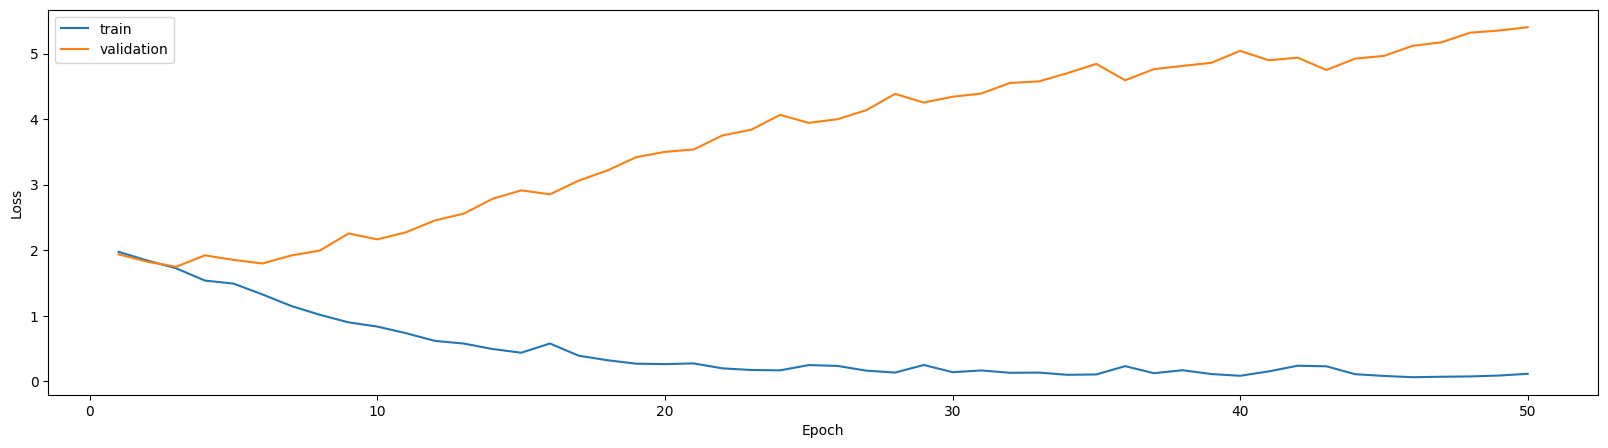

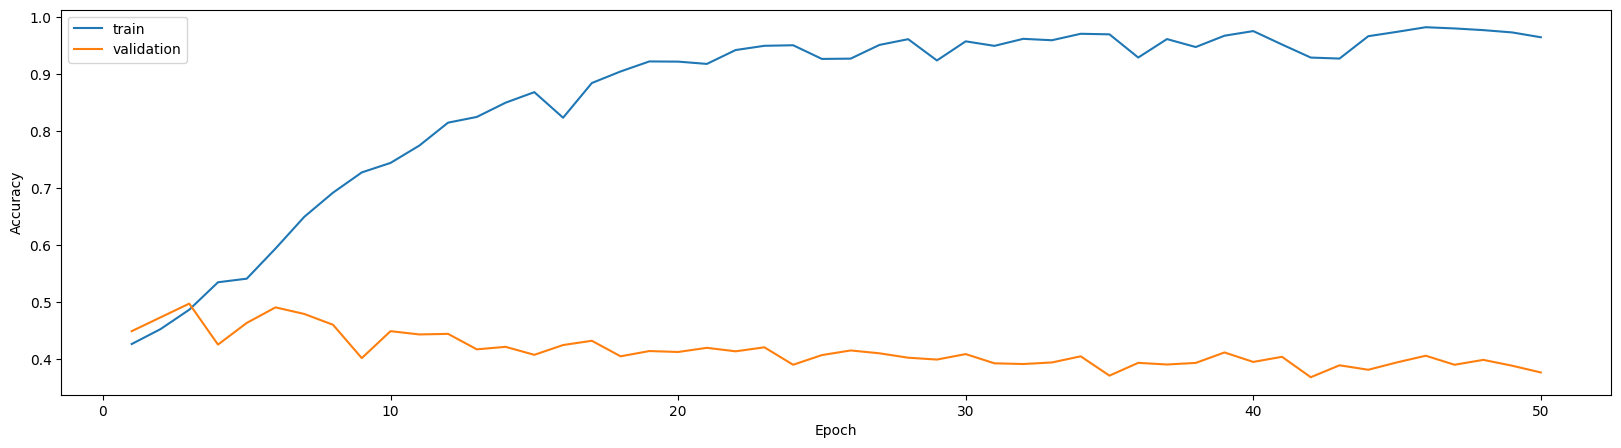

	Evaluation: 100%|██████████| 193/193 [00:03<00:00, 49.71it/s]



Test Loss: 1.719 | Test Acc: 50.07% | Test F1: 0.413 | Test ROC AUC: 0.754

Classification report:
              precision    recall  f1-score   support

           0       0.49      0.91      0.64      4983
           1       0.68      0.42      0.52       672
           2       0.50      0.18      0.26      1070
           3       0.53      0.08      0.14       667
           4       0.15      0.01      0.01       837
           5       0.64      0.05      0.09       144
           6       0.23      0.02      0.03       351
           7       0.38      0.21      0.27       551
           8       0.00      0.00      0.00       200
           9       0.64      0.64      0.64       614
          10       0.33      0.01      0.01       570
          11       0.71      0.08      0.15       208
          12       0.53      0.58      0.55       844
          13       0.39      0.14      0.20       629

    accuracy                           0.50     12340
   macro avg       0.44      0.24 

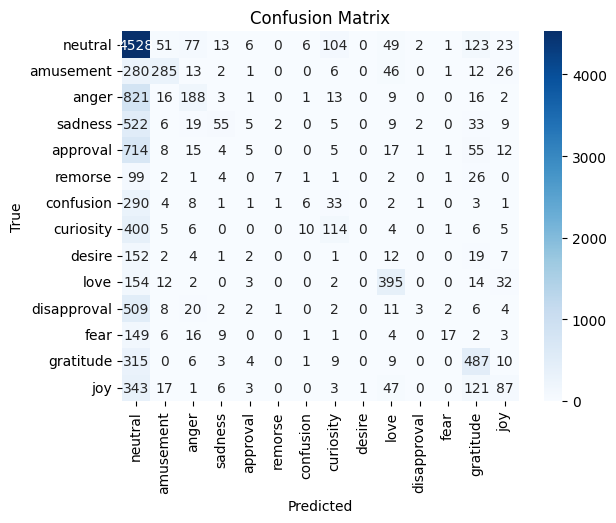

In [ ]:
# plot training curves

import matplotlib.pyplot as plt

# create epoch list
epochs = list(range(1, N_EPOCHS+1))

# plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, valid_loss_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, valid_acc_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#######
# print out required metrics

import seaborn as sns
model.load_state_dict(torch.load('model-glove.pt'))

test_loss, test_acc, test_f1, test_roc_auc, test_report, test_cm = evaluate(model, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f} | Test ROC AUC: {test_roc_auc:.3f}\n')
# print(f'Confusion matrix:\n{test_cm}')
print(f'Classification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import torch.nn as nn
from torch import optim

# Define an RNN class
class pretrainedRNN1(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pretrained_embeddings, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=pad_idx)
        # self.embedding = nn.Embedding(input_dim, embedding_dim)
        # self.embedding.weight.data.copy_(pretrained_embeddings) # copy pre-trained vectors to embedding layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.fc = nn.Linear(hidden_dim, output_dim[1]) # output_dim[0] is hidden_dim, output_dim[1] is output_dim

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)                          # VV note that lengths need to be on the CPU
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        output, hidden = self.rnn(embedded)

        return self.fc(hidden.squeeze(0))


# Setting model building arguments
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_vocab) # 14 output nodes
PAD_IDX = text_vocab["<pad>"]

model_glove_2 = pretrainedRNN1(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, pretrained_embeddings, PAD_IDX) # create a RNN model using the arguments
print(f'The model has {count_parameters(model_glove_2):,} trainable parameters')

# Set other parameters
optimizer = optim.Adam(model_glove_2.parameters())
criterion = nn.CrossEntropyLoss()

# Use GPU
model_glove_2 = model_glove_2.to(DEVICE)
criterion = criterion.to(DEVICE)

The model has 146,446 trainable parameters


In [ ]:
######
N_EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model_glove_2, train_dataloader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    # valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    valid_loss, valid_acc, valid_f1, valid_auc_roc, valid_report, valid_cm  = evaluate(model_glove_2, valid_dataloader, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_glove_2.state_dict(), 'model_glove_2.pt')


Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.24it/s]


	Train Loss: 1.987 | Train Acc: 42.19%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.71it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.878 |  Val. Acc: 45.00%
Epoch: 02


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.99it/s]


	Train Loss: 1.858 | Train Acc: 44.79%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 128.97it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.800 |  Val. Acc: 46.81%
Epoch: 03


	Training: 100%|██████████| 315/315 [00:04<00:00, 68.06it/s]


	Train Loss: 1.772 | Train Acc: 47.72%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 106.53it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.955 |  Val. Acc: 41.82%
Epoch: 04


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.28it/s]


	Train Loss: 1.790 | Train Acc: 46.54%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.29it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.747 |  Val. Acc: 49.91%
Epoch: 05


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.15it/s]


	Train Loss: 1.697 | Train Acc: 49.03%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.21it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.809 |  Val. Acc: 46.64%
Epoch: 06


	Training: 100%|██████████| 315/315 [00:04<00:00, 75.99it/s]


	Train Loss: 1.690 | Train Acc: 48.65%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 83.37it/s]


	 Val. Loss: 1.783 |  Val. Acc: 48.75%
Epoch: 07


	Training: 100%|██████████| 315/315 [00:03<00:00, 100.54it/s]


	Train Loss: 1.731 | Train Acc: 48.37%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.60it/s]


	 Val. Loss: 1.804 |  Val. Acc: 48.14%
Epoch: 08


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.28it/s]


	Train Loss: 1.627 | Train Acc: 50.53%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.62it/s]


	 Val. Loss: 1.758 |  Val. Acc: 50.35%
Epoch: 09


	Training: 100%|██████████| 315/315 [00:03<00:00, 84.21it/s]


	Train Loss: 1.718 | Train Acc: 47.82%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.01it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.795 |  Val. Acc: 48.50%
Epoch: 10


	Training: 100%|██████████| 315/315 [00:03<00:00, 88.72it/s] 


	Train Loss: 1.784 | Train Acc: 46.19%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 130.08it/s]


	 Val. Loss: 1.861 |  Val. Acc: 43.78%
Epoch: 11


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.50it/s]


	Train Loss: 1.755 | Train Acc: 47.08%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.44it/s]


	 Val. Loss: 1.933 |  Val. Acc: 45.06%
Epoch: 12


	Training: 100%|██████████| 315/315 [00:03<00:00, 96.50it/s]


	Train Loss: 1.693 | Train Acc: 48.55%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.62it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.987 |  Val. Acc: 43.79%
Epoch: 13


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.70it/s] 


	Train Loss: 1.735 | Train Acc: 47.41%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.44it/s]


	 Val. Loss: 1.935 |  Val. Acc: 44.11%
Epoch: 14


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.72it/s]


	Train Loss: 1.666 | Train Acc: 49.02%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 131.55it/s]


	 Val. Loss: 1.831 |  Val. Acc: 46.93%
Epoch: 15


	Training: 100%|██████████| 315/315 [00:03<00:00, 102.67it/s]


	Train Loss: 1.594 | Train Acc: 50.76%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 99.33it/s]


	 Val. Loss: 1.864 |  Val. Acc: 44.96%
Epoch: 16


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.10it/s]


	Train Loss: 1.550 | Train Acc: 51.98%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.53it/s]


	 Val. Loss: 1.794 |  Val. Acc: 48.38%
Epoch: 17


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.08it/s]


	Train Loss: 1.464 | Train Acc: 54.20%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 130.91it/s]


	 Val. Loss: 1.711 |  Val. Acc: 49.88%
Epoch: 18


	Training: 100%|██████████| 315/315 [00:03<00:00, 100.40it/s]


	Train Loss: 1.410 | Train Acc: 55.89%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 127.28it/s]


	 Val. Loss: 1.758 |  Val. Acc: 49.79%
Epoch: 19


	Training: 100%|██████████| 315/315 [00:04<00:00, 68.79it/s]


	Train Loss: 1.402 | Train Acc: 56.31%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 77.69it/s]


	 Val. Loss: 1.790 |  Val. Acc: 45.60%
Epoch: 20


	Training: 100%|██████████| 315/315 [00:03<00:00, 101.67it/s]


	Train Loss: 1.372 | Train Acc: 56.87%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 130.88it/s]


	 Val. Loss: 1.744 |  Val. Acc: 49.69%
Epoch: 21


	Training: 100%|██████████| 315/315 [00:03<00:00, 98.29it/s]


	Train Loss: 1.415 | Train Acc: 55.85%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 126.60it/s]


	 Val. Loss: 1.902 |  Val. Acc: 44.59%
Epoch: 22


	Training: 100%|██████████| 315/315 [00:04<00:00, 67.96it/s]


	Train Loss: 1.476 | Train Acc: 54.17%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 113.87it/s]


	 Val. Loss: 1.890 |  Val. Acc: 48.07%
Epoch: 23


	Training: 100%|██████████| 315/315 [00:03<00:00, 102.27it/s]


	Train Loss: 1.329 | Train Acc: 58.10%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 130.50it/s]


	 Val. Loss: 1.849 |  Val. Acc: 47.86%
Epoch: 24


	Training: 100%|██████████| 315/315 [00:03<00:00, 100.50it/s]


	Train Loss: 1.264 | Train Acc: 60.19%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 130.16it/s]


	 Val. Loss: 1.835 |  Val. Acc: 47.30%
Epoch: 25


	Training: 100%|██████████| 315/315 [00:04<00:00, 70.13it/s]


	Train Loss: 1.217 | Train Acc: 61.64%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 85.57it/s]


	 Val. Loss: 1.838 |  Val. Acc: 47.66%
Epoch: 26


	Training: 100%|██████████| 315/315 [00:03<00:00, 101.65it/s]


	Train Loss: 1.326 | Train Acc: 58.61%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.36it/s]


	 Val. Loss: 1.866 |  Val. Acc: 49.47%
Epoch: 27


	Training: 100%|██████████| 315/315 [00:03<00:00, 101.59it/s]


	Train Loss: 1.166 | Train Acc: 63.47%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 128.72it/s]


	 Val. Loss: 1.886 |  Val. Acc: 48.06%
Epoch: 28


	Training: 100%|██████████| 315/315 [00:04<00:00, 78.54it/s]


	Train Loss: 1.227 | Train Acc: 61.54%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 85.75it/s]


	 Val. Loss: 1.977 |  Val. Acc: 47.12%
Epoch: 29


	Training: 100%|██████████| 315/315 [00:03<00:00, 93.36it/s] 


	Train Loss: 1.160 | Train Acc: 63.30%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 130.19it/s]


	 Val. Loss: 1.947 |  Val. Acc: 46.90%
Epoch: 30


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.87it/s]


	Train Loss: 1.071 | Train Acc: 66.15%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 130.45it/s]


	 Val. Loss: 1.946 |  Val. Acc: 46.67%
Epoch: 31


	Training: 100%|██████████| 315/315 [00:03<00:00, 87.53it/s]


	Train Loss: 1.049 | Train Acc: 67.48%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 85.45it/s]


	 Val. Loss: 2.007 |  Val. Acc: 45.95%
Epoch: 32


	Training: 100%|██████████| 315/315 [00:03<00:00, 84.03it/s] 


	Train Loss: 1.143 | Train Acc: 64.46%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.23it/s]


	 Val. Loss: 3.440 |  Val. Acc: 14.77%
Epoch: 33


	Training: 100%|██████████| 315/315 [00:03<00:00, 97.59it/s]


	Train Loss: 1.670 | Train Acc: 48.58%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 124.98it/s]


	 Val. Loss: 2.054 |  Val. Acc: 43.86%
Epoch: 34


	Training: 100%|██████████| 315/315 [00:03<00:00, 88.48it/s]


	Train Loss: 1.310 | Train Acc: 58.47%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 81.92it/s]


	 Val. Loss: 1.992 |  Val. Acc: 44.48%
Epoch: 35


	Training: 100%|██████████| 315/315 [00:04<00:00, 77.73it/s]


	Train Loss: 1.182 | Train Acc: 62.67%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 129.09it/s]


	 Val. Loss: 2.014 |  Val. Acc: 45.70%
Epoch: 36


	Training: 100%|██████████| 315/315 [00:03<00:00, 101.33it/s]


	Train Loss: 1.093 | Train Acc: 65.64%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 129.60it/s]


	 Val. Loss: 2.040 |  Val. Acc: 46.34%
Epoch: 37


	Training: 100%|██████████| 315/315 [00:03<00:00, 96.33it/s]


	Train Loss: 1.052 | Train Acc: 66.98%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.64it/s]


	 Val. Loss: 2.092 |  Val. Acc: 44.29%
Epoch: 38


	Training: 100%|██████████| 315/315 [00:04<00:00, 76.79it/s] 


	Train Loss: 1.087 | Train Acc: 66.07%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.46it/s]


	 Val. Loss: 2.290 |  Val. Acc: 39.29%
Epoch: 39


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.07it/s]


	Train Loss: 1.090 | Train Acc: 65.88%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 131.04it/s]


	 Val. Loss: 2.210 |  Val. Acc: 42.90%
Epoch: 40


	Training: 100%|██████████| 315/315 [00:03<00:00, 101.09it/s]


	Train Loss: 1.212 | Train Acc: 62.45%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 103.36it/s]


	 Val. Loss: 2.198 |  Val. Acc: 43.47%
Epoch: 41


	Training: 100%|██████████| 315/315 [00:05<00:00, 60.12it/s]


	Train Loss: 1.327 | Train Acc: 58.15%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 128.24it/s]


	 Val. Loss: 2.095 |  Val. Acc: 44.34%
Epoch: 42


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.40it/s]


	Train Loss: 1.209 | Train Acc: 61.92%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.26it/s]


	 Val. Loss: 2.100 |  Val. Acc: 44.86%
Epoch: 43


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.37it/s]


	Train Loss: 1.011 | Train Acc: 68.89%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 128.18it/s]


	 Val. Loss: 2.130 |  Val. Acc: 44.96%
Epoch: 44


	Training: 100%|██████████| 315/315 [00:04<00:00, 68.44it/s]


	Train Loss: 0.926 | Train Acc: 71.14%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 109.64it/s]


	 Val. Loss: 2.165 |  Val. Acc: 44.35%
Epoch: 45


	Training: 100%|██████████| 315/315 [00:03<00:00, 102.27it/s]


	Train Loss: 0.942 | Train Acc: 70.93%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 131.95it/s]


	 Val. Loss: 2.221 |  Val. Acc: 44.54%
Epoch: 46


	Training: 100%|██████████| 315/315 [00:03<00:00, 101.34it/s]


	Train Loss: 0.900 | Train Acc: 72.52%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 130.17it/s]


	 Val. Loss: 2.351 |  Val. Acc: 44.27%
Epoch: 47


	Training: 100%|██████████| 315/315 [00:04<00:00, 74.03it/s]


	Train Loss: 0.843 | Train Acc: 73.76%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 85.46it/s]


	 Val. Loss: 2.287 |  Val. Acc: 44.04%
Epoch: 48


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.08it/s]


	Train Loss: 0.779 | Train Acc: 75.96%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.23it/s]


	 Val. Loss: 2.369 |  Val. Acc: 44.94%
Epoch: 49


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.99it/s]


	Train Loss: 0.800 | Train Acc: 75.79%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.55it/s]


	 Val. Loss: 2.380 |  Val. Acc: 44.94%
Epoch: 50


	Training: 100%|██████████| 315/315 [00:03<00:00, 84.32it/s]


	Train Loss: 0.710 | Train Acc: 78.42%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.00it/s]


	 Val. Loss: 2.422 |  Val. Acc: 45.32%


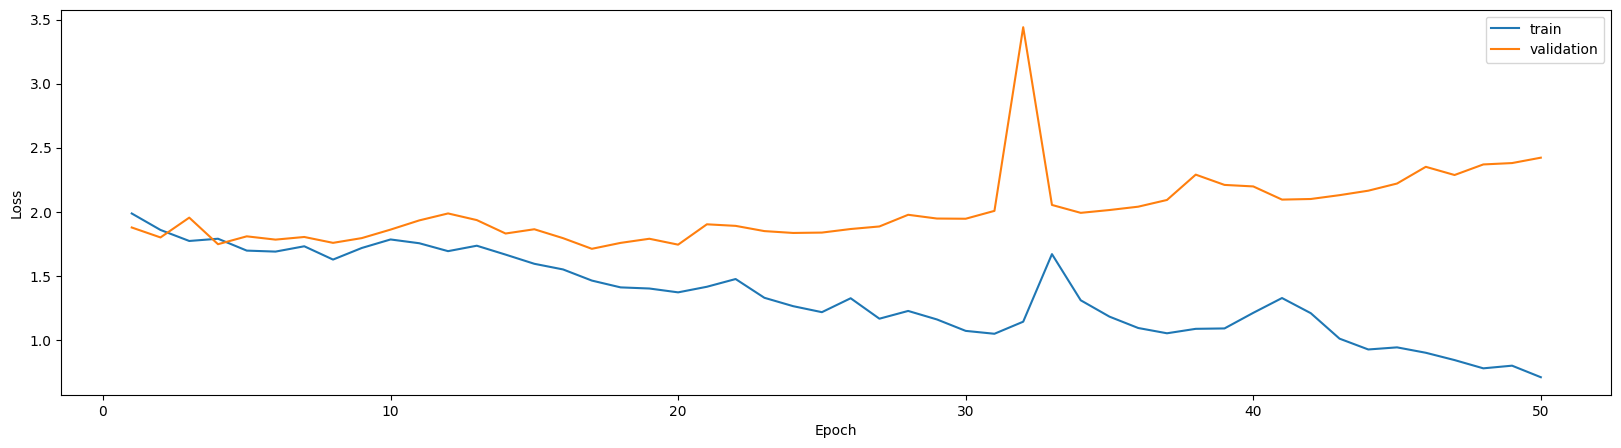

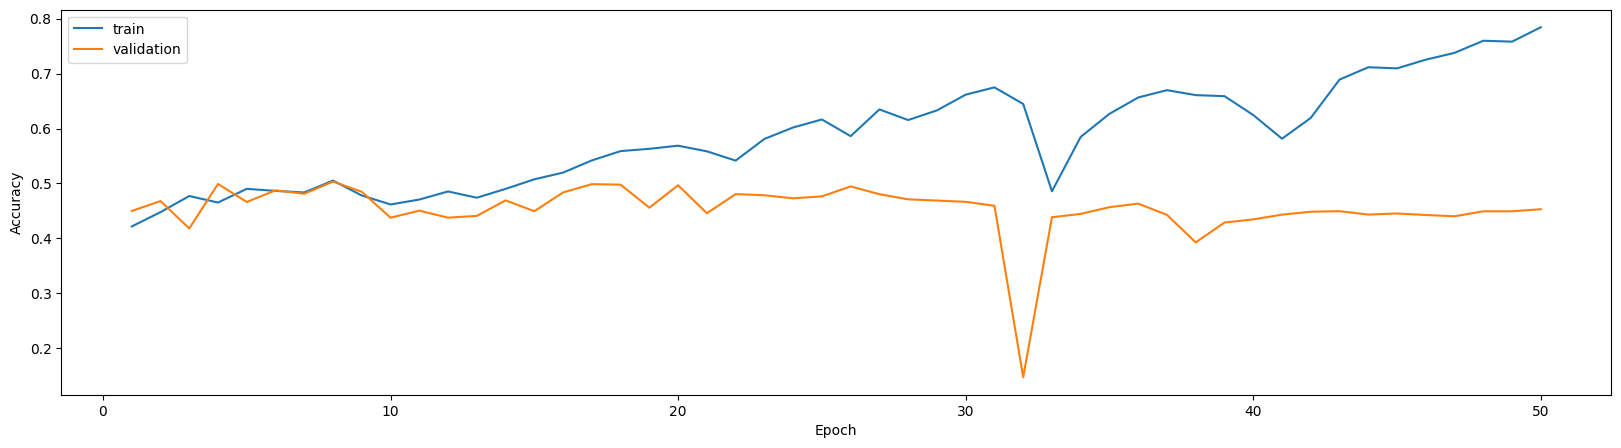

	Evaluation: 100%|██████████| 193/193 [00:01<00:00, 109.52it/s]



Test Loss: 1.706 | Test Acc: 49.96% | Test F1: 0.445 | Test ROC AUC: 0.771

Classification report:
              precision    recall  f1-score   support

           0       0.52      0.83      0.64      4983
           1       0.51      0.48      0.50       672
           2       0.40      0.22      0.28      1070
           3       0.36      0.25      0.29       667
           4       0.15      0.04      0.07       837
           5       0.26      0.08      0.13       144
           6       0.16      0.03      0.06       351
           7       0.37      0.31      0.33       551
           8       0.02      0.01      0.01       200
           9       0.61      0.65      0.63       614
          10       0.17      0.05      0.07       570
          11       0.58      0.14      0.23       208
          12       0.71      0.61      0.65       844
          13       0.47      0.19      0.27       629

    accuracy                           0.50     12340
   macro avg       0.38      0.28 

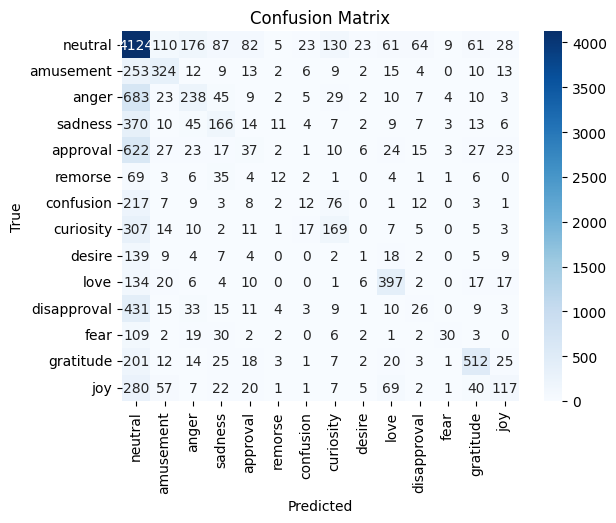

In [ ]:
# plot training curves

import matplotlib.pyplot as plt

# create epoch list
epochs = list(range(1, N_EPOCHS+1))

# plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, valid_loss_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, valid_acc_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#######
# print out required metrics

import seaborn as sns
model_glove_2.load_state_dict(torch.load('model_glove_2.pt'))

test_loss, test_acc, test_f1, test_roc_auc, test_report, test_cm = evaluate(model_glove_2, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f} | Test ROC AUC: {test_roc_auc:.3f}\n')
# print(f'Confusion matrix:\n{test_cm}')
print(f'Classification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()




---



---



---

## 1.C. Fasttext vectors : dim = 300

In [ ]:
from torchtext import vocab

MAX_VOCAB_SIZE = 25_000

fasttext_vectors = vocab.FastText(
    language="en",
    max_vectors=MAX_VOCAB_SIZE
)

.vector_cache/wiki.en.vec: 6.60GB [01:13, 89.5MB/s]                           
100%|██████████| 25000/25000 [00:02<00:00, 10869.21it/s]


In [ ]:
from torchtext.vocab import vocab

text_vocab = vocab(fasttext_vectors.stoi, min_freq=0, specials=("<unk>", "<pad>"), special_first=True)
text_vocab.set_default_index(text_vocab["<unk>"])

pretrained_embeddings = fasttext_vectors.vectors
pretrained_embeddings = torch.cat([
    torch.empty(1, fasttext_vectors.dim).normal_(),  # unk token vector
    torch.zeros(1, fasttext_vectors.dim),  # padding token vector
    pretrained_embeddings
])

print("Vocab size: ", len(text_vocab))
print("Pretrained vectors shape: ", pretrained_embeddings.shape)
print("<unk> vector: ", pretrained_embeddings[text_vocab["<unk>"]])
print("<pad> vector: ", pretrained_embeddings[text_vocab["<pad>"]])

Vocab size:  25002
Pretrained vectors shape:  torch.Size([25002, 300])
<unk> vector:  tensor([-0.8869,  1.6772, -0.3701,  2.1944,  0.7692, -0.8924, -0.0489,  0.0755,
        -0.5123, -0.4590,  1.0897,  1.2543, -0.0622, -0.6588,  1.6449, -0.6965,
        -1.7057,  0.3655,  0.5852, -0.8624,  0.9218,  1.8720, -0.5654,  0.6636,
         1.4384,  1.4106, -1.8768,  0.1441, -0.6793,  1.1582, -0.4731, -1.2247,
         0.1365,  1.4445, -0.8124,  0.5407,  0.0713, -0.8875,  0.8623, -0.8465,
        -0.5437,  0.5982, -0.1350, -0.3506,  1.1884,  0.8026, -0.9347, -2.4160,
        -0.2055, -0.2914, -2.1832,  0.7252, -0.0376,  0.6736, -0.7453,  2.0802,
         0.1693, -1.4845, -0.7576, -0.3879, -0.2893, -2.2448,  0.8364,  0.2927,
         0.6777, -1.2699, -0.8632, -0.7130,  0.2570, -0.8474,  0.0434,  1.9785,
        -2.4183,  0.8928,  1.2539,  1.6336,  0.6081, -0.3671, -0.6618, -0.4481,
         0.6064,  0.7948, -0.1796,  0.4069, -1.6601, -0.4753, -1.6116, -0.4127,
        -0.1949,  1.0342, -0.8149,

In [ ]:
from collections import OrderedDict
label_vocab = vocab(OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)]))


In [ ]:
import torchtext.transforms as T

text_transform = T.Sequential(
    SpacyTokenizer(),  # Tokenize
    T.VocabTransform(text_vocab),  # Conver to vocab IDs
    T.ToTensor(padding_value=text_vocab["<pad>"]),  # Convert to tensor and pad
)

label_transform = T.Sequential(
    # T.LabelToIndex(label_vocab.get_itos()),  # Convert to integer #labels are already integers
    T.ToTensor(),  # Convert to tensor
)

lengths_transform = T.Sequential(
    SpacyTokenizer(),
    ToLengths(),
    T.ToTensor(),
)

In [ ]:
train_dataloader = _get_dataloader(train_data)
valid_dataloader = _get_dataloader(valid_data)
test_dataloader = _get_dataloader(test_data)

In [ ]:
import torch.nn as nn
from torch import optim

# Define an RNN class
class pretrainedRNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pretrained_embeddings):
        super().__init__()
        # self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=pad_idx)

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings) # copy pre-trained vectors to embedding layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.fc = nn.Linear(hidden_dim, output_dim[1]) # output_dim[0] is hidden_dim, output_dim[1] is output_dim

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)                          # VV note that lengths need to be on the CPU
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        output, hidden = self.rnn(embedded)

        return self.fc(hidden.squeeze(0))


# Setting model building arguments
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_vocab) # 14 output nodes

model = pretrainedRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, pretrained_embeddings) # create a RNN model using the arguments
print(f'The model has {count_parameters(model):,} trainable parameters')

# Set other parameters
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Use GPU
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

The model has 7,647,046 trainable parameters


In [ ]:
######
N_EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    # valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    valid_loss, valid_acc, valid_f1, valid_auc_roc, valid_report, valid_cm  = evaluate(model, valid_dataloader, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model-fasttext.pt')


Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 315/315 [00:07<00:00, 43.22it/s]


	Train Loss: 2.065 | Train Acc: 40.60%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 67.41it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.939 |  Val. Acc: 43.74%
Epoch: 02


	Training: 100%|██████████| 315/315 [00:05<00:00, 60.13it/s]


	Train Loss: 1.890 | Train Acc: 44.73%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.94it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.920 |  Val. Acc: 44.76%
Epoch: 03


	Training: 100%|██████████| 315/315 [00:04<00:00, 78.31it/s]


	Train Loss: 1.741 | Train Acc: 48.10%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.44it/s]


	 Val. Loss: 1.831 |  Val. Acc: 47.81%
Epoch: 04


	Training: 100%|██████████| 315/315 [00:04<00:00, 67.24it/s]


	Train Loss: 1.632 | Train Acc: 50.99%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 87.18it/s]


	 Val. Loss: 1.874 |  Val. Acc: 47.19%
Epoch: 05


	Training: 100%|██████████| 315/315 [00:04<00:00, 73.82it/s]


	Train Loss: 1.451 | Train Acc: 55.70%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.73it/s]


	 Val. Loss: 1.917 |  Val. Acc: 44.11%
Epoch: 06


	Training: 100%|██████████| 315/315 [00:04<00:00, 78.16it/s]


	Train Loss: 1.350 | Train Acc: 59.45%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.16it/s]


	 Val. Loss: 1.998 |  Val. Acc: 44.16%
Epoch: 07


	Training: 100%|██████████| 315/315 [00:05<00:00, 56.47it/s]


	Train Loss: 1.306 | Train Acc: 60.72%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.59it/s]


	 Val. Loss: 2.010 |  Val. Acc: 44.56%
Epoch: 08


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.13it/s]


	Train Loss: 1.141 | Train Acc: 65.68%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.58it/s]


	 Val. Loss: 2.076 |  Val. Acc: 43.76%
Epoch: 09


	Training: 100%|██████████| 315/315 [00:04<00:00, 76.63it/s]


	Train Loss: 1.063 | Train Acc: 67.73%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.28it/s]


	 Val. Loss: 2.161 |  Val. Acc: 43.89%
Epoch: 10


	Training: 100%|██████████| 315/315 [00:04<00:00, 63.59it/s]


	Train Loss: 0.930 | Train Acc: 72.20%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.65it/s]


	 Val. Loss: 2.236 |  Val. Acc: 42.60%
Epoch: 11


	Training: 100%|██████████| 315/315 [00:04<00:00, 78.41it/s]


	Train Loss: 0.841 | Train Acc: 74.92%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.16it/s]


	 Val. Loss: 2.468 |  Val. Acc: 40.23%
Epoch: 12


	Training: 100%|██████████| 315/315 [00:04<00:00, 65.36it/s]


	Train Loss: 0.776 | Train Acc: 76.69%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 85.09it/s]


	 Val. Loss: 2.523 |  Val. Acc: 38.44%
Epoch: 13


	Training: 100%|██████████| 315/315 [00:04<00:00, 74.99it/s]


	Train Loss: 0.757 | Train Acc: 77.16%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.99it/s]


	 Val. Loss: 2.514 |  Val. Acc: 41.40%
Epoch: 14


	Training: 100%|██████████| 315/315 [00:04<00:00, 63.89it/s]


	Train Loss: 0.671 | Train Acc: 79.97%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 97.69it/s]


	 Val. Loss: 2.713 |  Val. Acc: 44.10%
Epoch: 15


	Training: 100%|██████████| 315/315 [00:05<00:00, 60.25it/s]


	Train Loss: 0.620 | Train Acc: 81.35%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.93it/s]


	 Val. Loss: 2.750 |  Val. Acc: 40.21%
Epoch: 16


	Training: 100%|██████████| 315/315 [00:09<00:00, 32.72it/s]


	Train Loss: 0.598 | Train Acc: 82.02%


	Evaluation: 100%|██████████| 135/135 [00:03<00:00, 38.78it/s]


	 Val. Loss: 2.823 |  Val. Acc: 42.20%
Epoch: 17


	Training: 100%|██████████| 315/315 [00:07<00:00, 44.43it/s]


	Train Loss: 0.519 | Train Acc: 84.58%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 74.99it/s]


	 Val. Loss: 3.005 |  Val. Acc: 39.08%
Epoch: 18


	Training: 100%|██████████| 315/315 [00:07<00:00, 43.81it/s]


	Train Loss: 0.478 | Train Acc: 85.94%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 63.89it/s]


	 Val. Loss: 3.096 |  Val. Acc: 41.30%
Epoch: 19


	Training: 100%|██████████| 315/315 [00:06<00:00, 48.27it/s]


	Train Loss: 0.477 | Train Acc: 85.78%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 76.22it/s]


	 Val. Loss: 3.129 |  Val. Acc: 40.57%
Epoch: 20


	Training: 100%|██████████| 315/315 [00:08<00:00, 37.21it/s]


	Train Loss: 0.423 | Train Acc: 87.40%


	Evaluation: 100%|██████████| 135/135 [00:03<00:00, 44.67it/s]


	 Val. Loss: 3.334 |  Val. Acc: 39.85%
Epoch: 21


	Training: 100%|██████████| 315/315 [00:08<00:00, 39.29it/s]


	Train Loss: 0.435 | Train Acc: 86.95%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 62.65it/s]


	 Val. Loss: 3.356 |  Val. Acc: 39.82%
Epoch: 22


	Training: 100%|██████████| 315/315 [00:04<00:00, 78.29it/s]


	Train Loss: 0.388 | Train Acc: 88.53%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.34it/s]


	 Val. Loss: 3.499 |  Val. Acc: 39.75%
Epoch: 23


	Training: 100%|██████████| 315/315 [00:04<00:00, 73.51it/s]


	Train Loss: 0.354 | Train Acc: 89.67%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.51it/s]


	 Val. Loss: 3.637 |  Val. Acc: 39.22%
Epoch: 24


	Training: 100%|██████████| 315/315 [00:04<00:00, 67.70it/s]


	Train Loss: 0.435 | Train Acc: 86.97%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.78it/s]


	 Val. Loss: 3.553 |  Val. Acc: 41.11%
Epoch: 25


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.23it/s]


	Train Loss: 0.335 | Train Acc: 90.05%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.64it/s]


	 Val. Loss: 3.765 |  Val. Acc: 39.86%
Epoch: 26


	Training: 100%|██████████| 315/315 [00:04<00:00, 63.69it/s]


	Train Loss: 0.488 | Train Acc: 85.54%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 84.62it/s]


	 Val. Loss: 3.620 |  Val. Acc: 38.75%
Epoch: 27


	Training: 100%|██████████| 315/315 [00:04<00:00, 76.38it/s]


	Train Loss: 0.359 | Train Acc: 89.39%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.51it/s]


	 Val. Loss: 3.806 |  Val. Acc: 38.40%
Epoch: 28


	Training: 100%|██████████| 315/315 [00:03<00:00, 78.82it/s]


	Train Loss: 0.286 | Train Acc: 91.77%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 121.11it/s]


	 Val. Loss: 3.909 |  Val. Acc: 38.25%
Epoch: 29


	Training: 100%|██████████| 315/315 [00:05<00:00, 57.82it/s]


	Train Loss: 0.274 | Train Acc: 92.03%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.69it/s]


	 Val. Loss: 4.088 |  Val. Acc: 38.16%
Epoch: 30


	Training: 100%|██████████| 315/315 [00:04<00:00, 78.20it/s]


	Train Loss: 0.266 | Train Acc: 92.18%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.25it/s]


	 Val. Loss: 4.121 |  Val. Acc: 38.85%
Epoch: 31


	Training: 100%|██████████| 315/315 [00:04<00:00, 70.96it/s]


	Train Loss: 0.240 | Train Acc: 92.93%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.07it/s]


	 Val. Loss: 4.185 |  Val. Acc: 39.39%
Epoch: 32


	Training: 100%|██████████| 315/315 [00:04<00:00, 65.45it/s]


	Train Loss: 0.210 | Train Acc: 94.07%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.92it/s]


	 Val. Loss: 4.355 |  Val. Acc: 38.82%
Epoch: 33


	Training: 100%|██████████| 315/315 [00:04<00:00, 77.82it/s]


	Train Loss: 0.201 | Train Acc: 94.22%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.56it/s]


	 Val. Loss: 4.510 |  Val. Acc: 37.13%
Epoch: 34


	Training: 100%|██████████| 315/315 [00:05<00:00, 59.07it/s]


	Train Loss: 0.281 | Train Acc: 91.58%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 99.62it/s] 


	 Val. Loss: 4.458 |  Val. Acc: 39.19%
Epoch: 35


	Training: 100%|██████████| 315/315 [00:04<00:00, 77.09it/s]


	Train Loss: 0.389 | Train Acc: 88.43%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 131.86it/s]


	 Val. Loss: 4.387 |  Val. Acc: 31.24%
Epoch: 36


	Training: 100%|██████████| 315/315 [00:04<00:00, 68.04it/s]


	Train Loss: 0.275 | Train Acc: 91.82%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.39it/s]


	 Val. Loss: 4.363 |  Val. Acc: 39.32%
Epoch: 37


	Training: 100%|██████████| 315/315 [00:04<00:00, 63.90it/s]


	Train Loss: 0.205 | Train Acc: 94.10%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.97it/s]


	 Val. Loss: 4.486 |  Val. Acc: 39.52%
Epoch: 38


	Training: 100%|██████████| 315/315 [00:04<00:00, 69.47it/s]


	Train Loss: 0.168 | Train Acc: 95.23%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.66it/s]


	 Val. Loss: 4.709 |  Val. Acc: 38.39%
Epoch: 39


	Training: 100%|██████████| 315/315 [00:05<00:00, 57.63it/s]


	Train Loss: 0.171 | Train Acc: 95.12%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 106.99it/s]


	 Val. Loss: 4.717 |  Val. Acc: 38.24%
Epoch: 40


	Training: 100%|██████████| 315/315 [00:04<00:00, 76.93it/s]


	Train Loss: 0.158 | Train Acc: 95.40%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.25it/s]


	 Val. Loss: 4.853 |  Val. Acc: 38.77%
Epoch: 41


	Training: 100%|██████████| 315/315 [00:04<00:00, 74.97it/s]


	Train Loss: 0.169 | Train Acc: 95.05%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.06it/s]


	 Val. Loss: 4.868 |  Val. Acc: 36.50%
Epoch: 42


	Training: 100%|██████████| 315/315 [00:05<00:00, 61.75it/s]


	Train Loss: 0.427 | Train Acc: 87.13%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.95it/s]


	 Val. Loss: 4.403 |  Val. Acc: 36.24%
Epoch: 43


	Training: 100%|██████████| 315/315 [00:04<00:00, 78.44it/s]


	Train Loss: 0.283 | Train Acc: 91.32%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.02it/s]


	 Val. Loss: 4.619 |  Val. Acc: 36.64%
Epoch: 44


	Training: 100%|██████████| 315/315 [00:04<00:00, 65.10it/s]


	Train Loss: 0.224 | Train Acc: 93.35%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 84.71it/s]


	 Val. Loss: 4.754 |  Val. Acc: 38.39%
Epoch: 45


	Training: 100%|██████████| 315/315 [00:04<00:00, 76.39it/s]


	Train Loss: 0.145 | Train Acc: 95.90%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.57it/s]


	 Val. Loss: 4.811 |  Val. Acc: 38.65%
Epoch: 46


	Training: 100%|██████████| 315/315 [00:03<00:00, 78.91it/s]


	Train Loss: 0.180 | Train Acc: 95.01%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.34it/s]


	 Val. Loss: 4.799 |  Val. Acc: 37.51%
Epoch: 47


	Training: 100%|██████████| 315/315 [00:05<00:00, 56.54it/s]


	Train Loss: 0.191 | Train Acc: 94.37%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.82it/s]


	 Val. Loss: 4.876 |  Val. Acc: 38.32%
Epoch: 48


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.58it/s]


	Train Loss: 0.235 | Train Acc: 92.95%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.00it/s]


	 Val. Loss: 4.943 |  Val. Acc: 36.53%
Epoch: 49


	Training: 100%|██████████| 315/315 [00:04<00:00, 75.95it/s]


	Train Loss: 0.198 | Train Acc: 93.93%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.60it/s]


	 Val. Loss: 4.983 |  Val. Acc: 37.28%
Epoch: 50


	Training: 100%|██████████| 315/315 [00:04<00:00, 64.68it/s]


	Train Loss: 0.152 | Train Acc: 95.43%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.26it/s]


	 Val. Loss: 5.163 |  Val. Acc: 38.12%


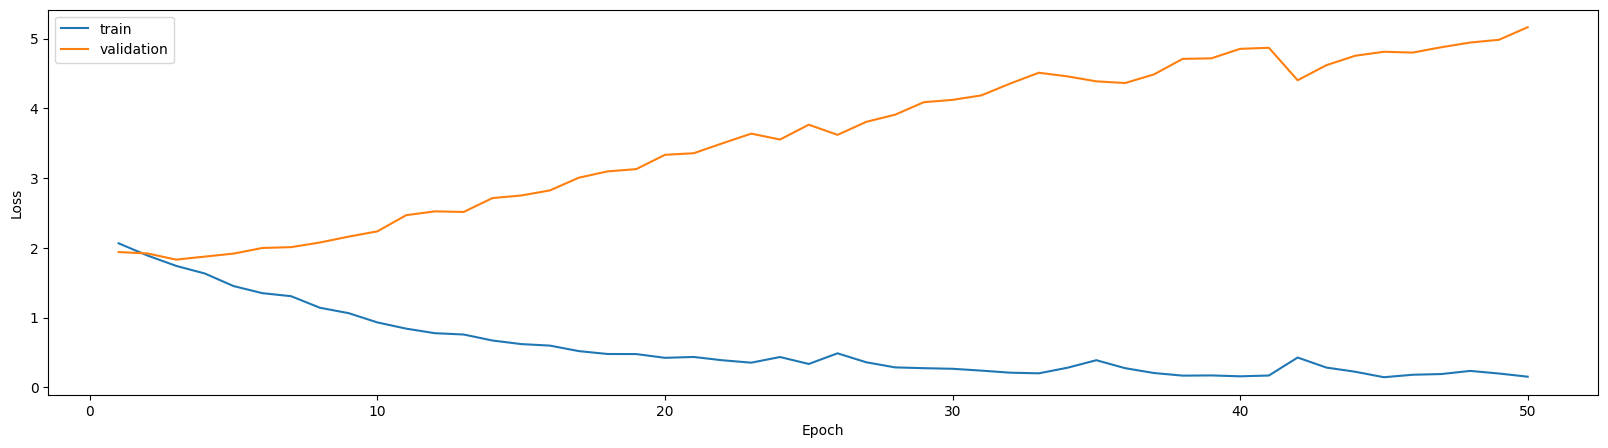

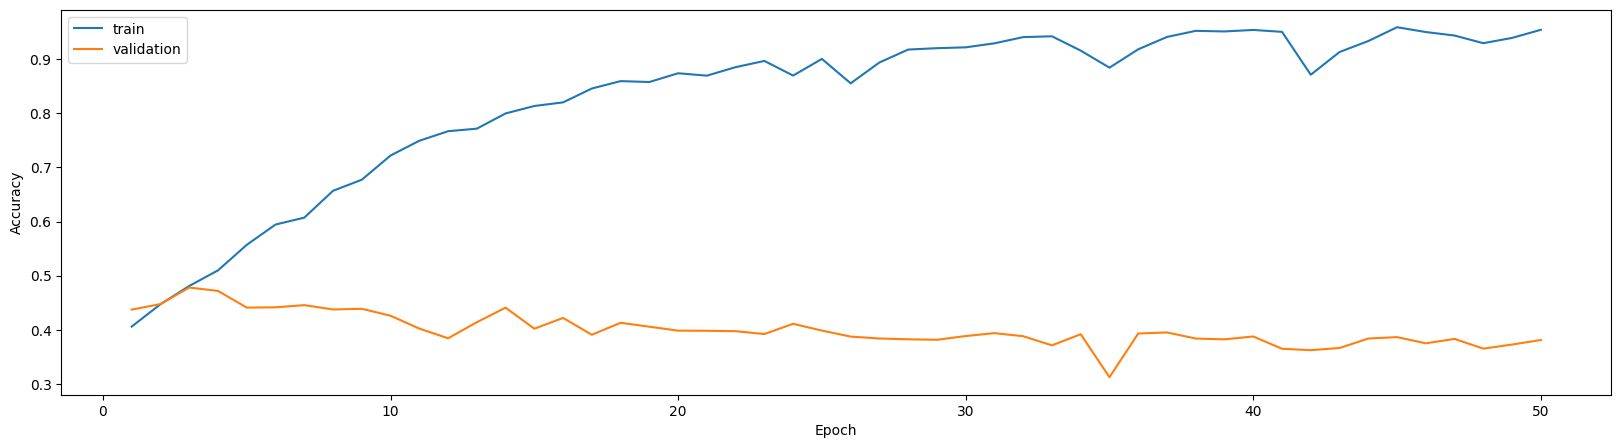

	Evaluation: 100%|██████████| 193/193 [00:02<00:00, 86.53it/s]



Test Loss: 1.814 | Test Acc: 48.51% | Test F1: 0.398 | Test ROC AUC: 0.721

Classification report:
              precision    recall  f1-score   support

           0       0.47      0.91      0.62      4983
           1       0.72      0.27      0.39       672
           2       0.50      0.09      0.16      1070
           3       0.29      0.18      0.22       667
           4       0.26      0.01      0.02       837
           5       0.68      0.09      0.16       144
           6       0.33      0.01      0.01       351
           7       0.40      0.28      0.33       551
           8       0.20      0.01      0.01       200
           9       0.69      0.64      0.66       614
          10       0.00      0.00      0.00       570
          11       0.75      0.07      0.13       208
          12       0.59      0.45      0.51       844
          13       0.46      0.15      0.22       629

    accuracy                           0.49     12340
   macro avg       0.45      0.23 

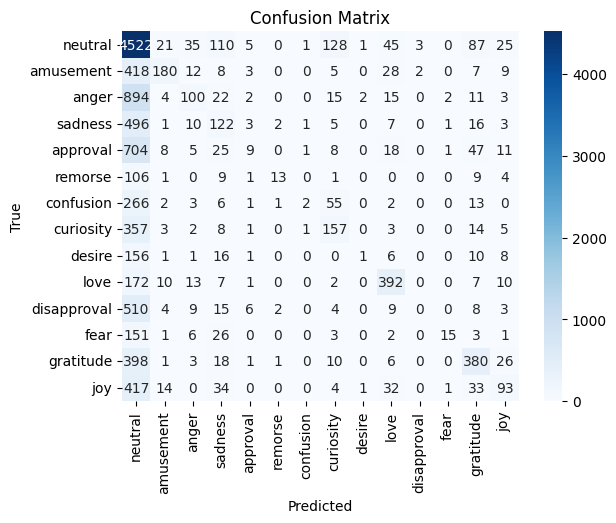

In [ ]:
# plot training curves

import matplotlib.pyplot as plt

# create epoch list
epochs = list(range(1, N_EPOCHS+1))

# plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, valid_loss_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, valid_acc_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#######
# print out required metrics

import seaborn as sns
model.load_state_dict(torch.load('model-fasttext.pt'))

test_loss, test_acc, test_f1, test_roc_auc, test_report, test_cm = evaluate(model, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f} | Test ROC AUC: {test_roc_auc:.3f}\n')
# print(f'Confusion matrix:\n{test_cm}')
print(f'Classification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import torch.nn as nn
from torch import optim

# Define an RNN class
class pretrainedRNN1(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pretrained_embeddings, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=pad_idx)
        # self.embedding = nn.Embedding(input_dim, embedding_dim)
        # self.embedding.weight.data.copy_(pretrained_embeddings) # copy pre-trained vectors to embedding layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.fc = nn.Linear(hidden_dim, output_dim[1]) # output_dim[0] is hidden_dim, output_dim[1] is output_dim

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)                          # VV note that lengths need to be on the CPU
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        output, hidden = self.rnn(embedded)

        return self.fc(hidden.squeeze(0))


# Setting model building arguments
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_vocab) # 14 output nodes
PAD_IDX = text_vocab["<pad>"]

model_fasttext_2 = pretrainedRNN1(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, pretrained_embeddings, PAD_IDX) # create a RNN model using the arguments
print(f'The model has {count_parameters(model_fasttext_2):,} trainable parameters')

# Set other parameters
optimizer = optim.Adam(model_fasttext_2.parameters())
criterion = nn.CrossEntropyLoss()

# Use GPU
model_fasttext_2 = model_fasttext_2.to(DEVICE)
criterion = criterion.to(DEVICE)

The model has 146,446 trainable parameters


In [ ]:
######
N_EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model_fasttext_2, train_dataloader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    # valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    valid_loss, valid_acc, valid_f1, valid_auc_roc, valid_report, valid_cm  = evaluate(model_fasttext_2, valid_dataloader, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_fasttext_2.state_dict(), 'model_fasttext_2.pt')


Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 315/315 [00:03<00:00, 85.52it/s]


	Train Loss: 2.075 | Train Acc: 40.67%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.59it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.999 |  Val. Acc: 42.91%
Epoch: 02


	Training: 100%|██████████| 315/315 [00:03<00:00, 89.97it/s] 


	Train Loss: 1.973 | Train Acc: 42.82%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.89it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.985 |  Val. Acc: 42.80%
Epoch: 03


	Training: 100%|██████████| 315/315 [00:03<00:00, 88.77it/s]


	Train Loss: 1.935 | Train Acc: 43.97%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.20it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.956 |  Val. Acc: 43.17%
Epoch: 04


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.11it/s]


	Train Loss: 1.887 | Train Acc: 44.92%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 92.42it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.912 |  Val. Acc: 45.81%
Epoch: 05


	Training: 100%|██████████| 315/315 [00:03<00:00, 86.16it/s] 


	Train Loss: 1.863 | Train Acc: 45.77%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 128.22it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.913 |  Val. Acc: 45.40%
Epoch: 06


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.63it/s] 


	Train Loss: 1.849 | Train Acc: 45.32%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.44it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.870 |  Val. Acc: 45.10%
Epoch: 07


	Training: 100%|██████████| 315/315 [00:03<00:00, 94.23it/s]


	Train Loss: 1.800 | Train Acc: 46.25%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.60it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.814 |  Val. Acc: 45.86%
Epoch: 08


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.73it/s] 


	Train Loss: 1.777 | Train Acc: 46.60%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.93it/s]


	 Val. Loss: 1.877 |  Val. Acc: 44.32%
Epoch: 09


	Training: 100%|██████████| 315/315 [00:03<00:00, 102.49it/s]


	Train Loss: 1.806 | Train Acc: 45.94%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.84it/s]


	 Val. Loss: 1.864 |  Val. Acc: 45.17%
Epoch: 10


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.62it/s]


	Train Loss: 1.768 | Train Acc: 47.00%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 92.17it/s]


	 Val. Loss: 1.816 |  Val. Acc: 47.11%
Epoch: 11


	Training: 100%|██████████| 315/315 [00:04<00:00, 74.35it/s]


	Train Loss: 1.818 | Train Acc: 45.62%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.91it/s]


	 Val. Loss: 1.919 |  Val. Acc: 41.92%
Epoch: 12


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.04it/s]


	Train Loss: 1.742 | Train Acc: 47.26%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.69it/s]


	 Val. Loss: 1.818 |  Val. Acc: 46.63%
Epoch: 13


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.79it/s]


	Train Loss: 1.786 | Train Acc: 46.61%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.50it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 2.005 |  Val. Acc: 44.09%
Epoch: 14


	Training: 100%|██████████| 315/315 [00:04<00:00, 70.01it/s]


	Train Loss: 1.690 | Train Acc: 49.08%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 104.80it/s]


	 Val. Loss: 1.818 |  Val. Acc: 47.40%
Epoch: 15


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.83it/s]


	Train Loss: 1.630 | Train Acc: 50.74%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.60it/s]


	 Val. Loss: 1.751 |  Val. Acc: 49.91%
Epoch: 16


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.44it/s]


	Train Loss: 1.646 | Train Acc: 49.93%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.99it/s]


	 Val. Loss: 1.870 |  Val. Acc: 46.01%
Epoch: 17


	Training: 100%|██████████| 315/315 [00:04<00:00, 78.67it/s]


	Train Loss: 1.707 | Train Acc: 48.40%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.68it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.957 |  Val. Acc: 45.30%
Epoch: 18


	Training: 100%|██████████| 315/315 [00:03<00:00, 102.38it/s]


	Train Loss: 1.707 | Train Acc: 48.60%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.69it/s]


	 Val. Loss: 1.967 |  Val. Acc: 42.19%
Epoch: 19


	Training: 100%|██████████| 315/315 [00:03<00:00, 99.21it/s] 


	Train Loss: 1.666 | Train Acc: 49.45%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.38it/s]


	 Val. Loss: 1.978 |  Val. Acc: 45.06%
Epoch: 20


	Training: 100%|██████████| 315/315 [00:03<00:00, 84.31it/s]


	Train Loss: 1.651 | Train Acc: 49.63%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.08it/s]


	 Val. Loss: 1.892 |  Val. Acc: 44.88%
Epoch: 21


	Training: 100%|██████████| 315/315 [00:03<00:00, 87.23it/s] 


	Train Loss: 1.618 | Train Acc: 50.64%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.62it/s]


	 Val. Loss: 1.851 |  Val. Acc: 47.01%
Epoch: 22


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.28it/s]


	Train Loss: 1.558 | Train Acc: 52.27%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.94it/s]


	 Val. Loss: 1.854 |  Val. Acc: 45.83%
Epoch: 23


	Training: 100%|██████████| 315/315 [00:03<00:00, 96.19it/s]


	Train Loss: 1.578 | Train Acc: 51.45%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.04it/s]


	 Val. Loss: 1.936 |  Val. Acc: 45.77%
Epoch: 24


	Training: 100%|██████████| 315/315 [00:04<00:00, 78.06it/s] 


	Train Loss: 1.598 | Train Acc: 50.91%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 131.31it/s]


	 Val. Loss: 1.993 |  Val. Acc: 42.97%
Epoch: 25


	Training: 100%|██████████| 315/315 [00:03<00:00, 87.68it/s]


	Train Loss: 1.558 | Train Acc: 51.69%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.05it/s]


	 Val. Loss: 1.987 |  Val. Acc: 45.38%
Epoch: 26


	Training: 100%|██████████| 315/315 [00:03<00:00, 100.58it/s]


	Train Loss: 1.466 | Train Acc: 54.28%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 87.78it/s]


	 Val. Loss: 2.004 |  Val. Acc: 44.05%
Epoch: 27


	Training: 100%|██████████| 315/315 [00:04<00:00, 74.71it/s]


	Train Loss: 1.435 | Train Acc: 55.23%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 91.76it/s]


	 Val. Loss: 1.941 |  Val. Acc: 45.02%
Epoch: 28


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.88it/s]


	Train Loss: 1.408 | Train Acc: 56.46%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.26it/s]


	 Val. Loss: 1.974 |  Val. Acc: 45.37%
Epoch: 29


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.92it/s]


	Train Loss: 1.380 | Train Acc: 57.12%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 98.45it/s]


	 Val. Loss: 2.080 |  Val. Acc: 44.59%
Epoch: 30


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.20it/s]


	Train Loss: 1.567 | Train Acc: 52.27%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.39it/s]


	 Val. Loss: 2.204 |  Val. Acc: 37.96%
Epoch: 31


	Training: 100%|██████████| 315/315 [00:03<00:00, 102.87it/s]


	Train Loss: 1.697 | Train Acc: 48.15%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.61it/s]


	 Val. Loss: 2.132 |  Val. Acc: 41.98%
Epoch: 32


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.08it/s]


	Train Loss: 1.505 | Train Acc: 53.59%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.53it/s]


	 Val. Loss: 2.163 |  Val. Acc: 42.53%
Epoch: 33


	Training: 100%|██████████| 315/315 [00:04<00:00, 70.48it/s]


	Train Loss: 1.400 | Train Acc: 56.59%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 99.51it/s] 


	 Val. Loss: 2.125 |  Val. Acc: 42.36%
Epoch: 34


	Training: 100%|██████████| 315/315 [00:03<00:00, 102.20it/s]


	Train Loss: 1.335 | Train Acc: 58.38%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.94it/s]


	 Val. Loss: 2.354 |  Val. Acc: 40.33%
Epoch: 35


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.41it/s]


	Train Loss: 1.398 | Train Acc: 57.04%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.85it/s]


	 Val. Loss: 2.143 |  Val. Acc: 43.24%
Epoch: 36


	Training: 100%|██████████| 315/315 [00:04<00:00, 76.50it/s]


	Train Loss: 1.266 | Train Acc: 60.98%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.84it/s]


	 Val. Loss: 2.174 |  Val. Acc: 43.99%
Epoch: 37


	Training: 100%|██████████| 315/315 [00:03<00:00, 100.42it/s]


	Train Loss: 1.293 | Train Acc: 59.80%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.39it/s]


	 Val. Loss: 2.328 |  Val. Acc: 39.17%
Epoch: 38


	Training: 100%|██████████| 315/315 [00:04<00:00, 65.68it/s]


	Train Loss: 1.249 | Train Acc: 61.10%


	Evaluation: 100%|██████████| 135/135 [00:02<00:00, 45.55it/s]


	 Val. Loss: 2.225 |  Val. Acc: 39.80%
Epoch: 39


	Training: 100%|██████████| 315/315 [00:07<00:00, 43.25it/s]


	Train Loss: 1.203 | Train Acc: 62.47%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 107.54it/s]


	 Val. Loss: 2.200 |  Val. Acc: 43.56%
Epoch: 40


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.40it/s]


	Train Loss: 1.109 | Train Acc: 66.09%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.56it/s]


	 Val. Loss: 2.206 |  Val. Acc: 45.60%
Epoch: 41


	Training: 100%|██████████| 315/315 [00:07<00:00, 43.15it/s]


	Train Loss: 1.140 | Train Acc: 65.09%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 80.98it/s]


	 Val. Loss: 2.267 |  Val. Acc: 44.07%
Epoch: 42


	Training: 100%|██████████| 315/315 [00:04<00:00, 71.55it/s]


	Train Loss: 1.387 | Train Acc: 57.09%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 82.02it/s]


	 Val. Loss: 2.249 |  Val. Acc: 41.74%
Epoch: 43


	Training: 100%|██████████| 315/315 [00:05<00:00, 58.62it/s]


	Train Loss: 1.223 | Train Acc: 62.14%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.35it/s]


	 Val. Loss: 2.313 |  Val. Acc: 42.34%
Epoch: 44


	Training: 100%|██████████| 315/315 [00:04<00:00, 64.25it/s]


	Train Loss: 1.146 | Train Acc: 65.07%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.10it/s]


	 Val. Loss: 2.308 |  Val. Acc: 40.47%
Epoch: 45


	Training: 100%|██████████| 315/315 [00:06<00:00, 49.70it/s]


	Train Loss: 1.157 | Train Acc: 64.35%


	Evaluation: 100%|██████████| 135/135 [00:03<00:00, 42.74it/s]


	 Val. Loss: 2.389 |  Val. Acc: 39.72%
Epoch: 46


	Training: 100%|██████████| 315/315 [00:04<00:00, 73.11it/s] 


	Train Loss: 1.157 | Train Acc: 64.34%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.24it/s]


	 Val. Loss: 2.398 |  Val. Acc: 41.71%
Epoch: 47


	Training: 100%|██████████| 315/315 [00:03<00:00, 101.60it/s]


	Train Loss: 1.087 | Train Acc: 66.87%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 119.53it/s]


	 Val. Loss: 2.364 |  Val. Acc: 42.52%
Epoch: 48


	Training: 100%|██████████| 315/315 [00:04<00:00, 64.69it/s]


	Train Loss: 0.992 | Train Acc: 69.91%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 77.04it/s]


	 Val. Loss: 2.414 |  Val. Acc: 43.96%
Epoch: 49


	Training: 100%|██████████| 315/315 [00:04<00:00, 67.42it/s]


	Train Loss: 0.948 | Train Acc: 71.20%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 75.28it/s]


	 Val. Loss: 2.452 |  Val. Acc: 41.35%
Epoch: 50


	Training: 100%|██████████| 315/315 [00:04<00:00, 70.40it/s]


	Train Loss: 0.921 | Train Acc: 72.12%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 85.64it/s]


	 Val. Loss: 2.459 |  Val. Acc: 42.63%


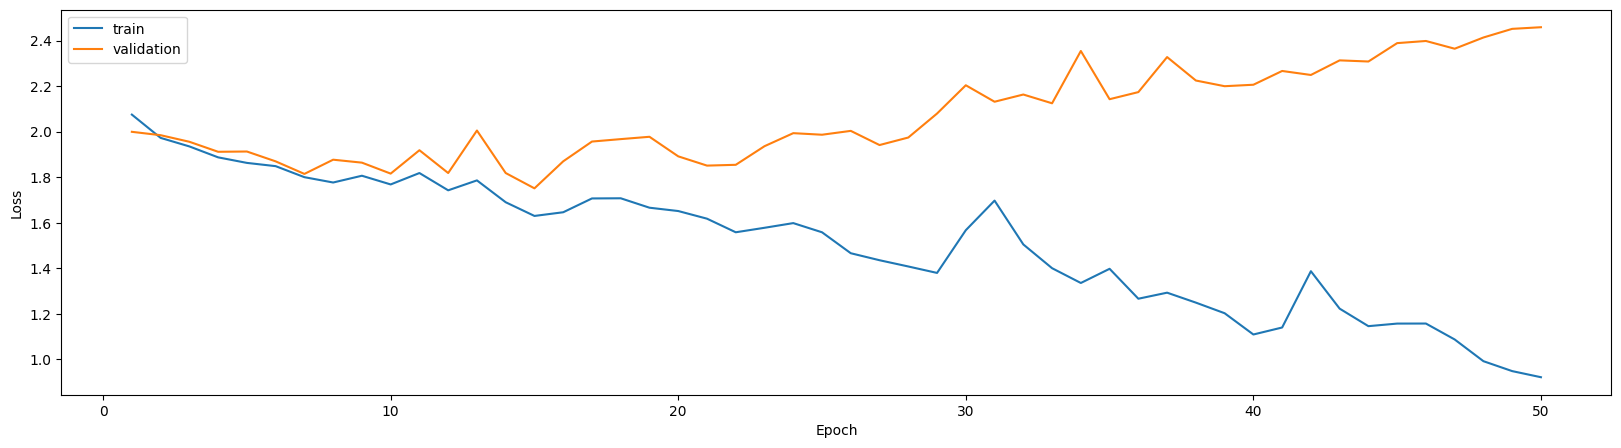

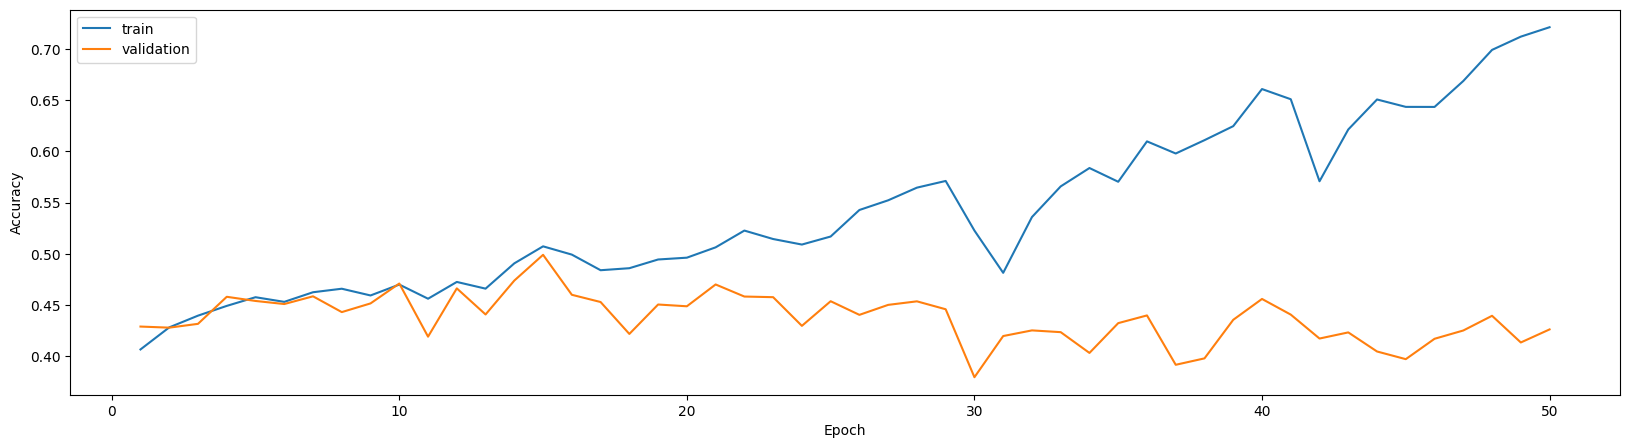

	Evaluation: 100%|██████████| 193/193 [00:01<00:00, 127.34it/s]



Test Loss: 1.729 | Test Acc: 50.46% | Test F1: 0.438 | Test ROC AUC: 0.751

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.88      0.64      4983
           1       0.52      0.32      0.40       672
           2       0.40      0.19      0.25      1070
           3       0.43      0.15      0.23       667
           4       0.12      0.02      0.04       837
           5       0.33      0.08      0.12       144
           6       0.17      0.05      0.08       351
           7       0.39      0.33      0.36       551
           8       0.18      0.01      0.03       200
           9       0.75      0.67      0.71       614
          10       0.09      0.01      0.02       570
          11       0.50      0.06      0.11       208
          12       0.81      0.59      0.68       844
          13       0.40      0.28      0.33       629

    accuracy                           0.50     12340
   macro avg       0.40      0.26 

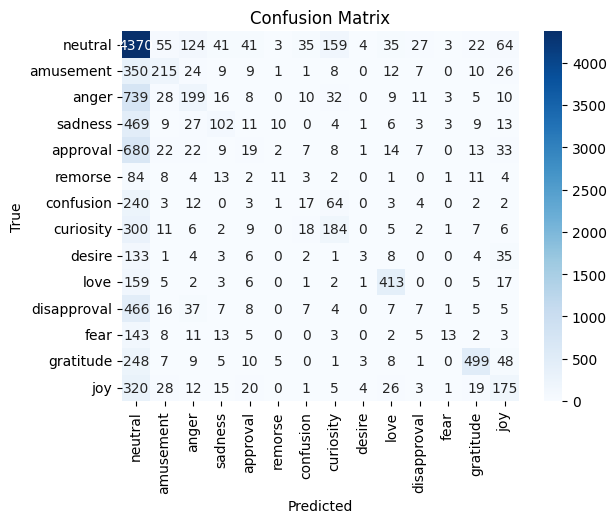

In [ ]:
# plot training curves

import matplotlib.pyplot as plt

# create epoch list
epochs = list(range(1, N_EPOCHS+1))

# plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, valid_loss_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, valid_acc_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#######
# print out required metrics

import seaborn as sns
model_fasttext_2.load_state_dict(torch.load('model_fasttext_2.pt'))

test_loss, test_acc, test_f1, test_roc_auc, test_report, test_cm = evaluate(model_fasttext_2, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f} | Test ROC AUC: {test_roc_auc:.3f}\n')
# print(f'Confusion matrix:\n{test_cm}')
print(f'Classification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



---



---



---

## 1.D.1. GloVe twitter vectors: 27B, dim = 100

In [ ]:
from torchtext import vocab

MAX_VOCAB_SIZE = 25_000

glove_vectors1 = vocab.GloVe(
    name="twitter.27B",
    dim="100",
    max_vectors=MAX_VOCAB_SIZE
)

.vector_cache/glove.twitter.27B.zip: 1.52GB [04:45, 5.33MB/s]                            
100%|█████████▉| 24999/25000 [00:00<00:00, 30709.69it/s]


In [ ]:
from torchtext.vocab import vocab

text_vocab = vocab(glove_vectors1.stoi, min_freq=0, specials=("<unk>", "<pad>"), special_first=True)
text_vocab.set_default_index(text_vocab["<unk>"])

pretrained_embeddings = glove_vectors1.vectors
pretrained_embeddings = torch.cat([
    torch.empty(1, glove_vectors1.dim).normal_(),  # unk token vector
    torch.zeros(1, glove_vectors1.dim),  # padding token vector
    pretrained_embeddings
])

print("Vocab size: ", len(text_vocab))
print("Pretrained vectors shape: ", pretrained_embeddings.shape)
print("<unk> vector: ", pretrained_embeddings[text_vocab["<unk>"]])
print("<pad> vector: ", pretrained_embeddings[text_vocab["<pad>"]])

Vocab size:  25002
Pretrained vectors shape:  torch.Size([25002, 100])
<unk> vector:  tensor([-3.2159e-01, -5.7777e-01, -2.9265e-02, -1.1300e+00, -3.0162e-02,
         4.9286e-01, -1.8823e-01,  7.8837e-01,  2.8984e-01, -1.5768e-01,
         2.6025e-02, -4.0680e-01,  9.8217e-01,  2.1075e+00, -8.3877e-01,
         7.2692e-01, -4.6005e-01,  9.6681e-01,  1.5570e-03,  2.8862e-01,
         7.7407e-01,  5.9272e-01, -5.3478e-01,  1.4071e+00, -2.9485e-01,
         2.2609e-02, -1.9177e-02, -2.3892e+00, -2.7957e-01,  1.6830e+00,
        -7.0656e-01,  2.2796e+00,  1.2711e+00, -4.5737e-01,  5.1229e-01,
        -6.0672e-01, -7.9999e-01,  1.3928e-01,  1.1280e+00,  7.6980e-01,
        -1.2025e+00, -1.1466e+00, -5.6061e-01,  6.0446e-01, -7.0300e-01,
         1.5256e+00, -2.6371e-01,  1.2136e+00, -5.6502e-01,  3.1753e-01,
        -9.6363e-01, -7.4075e-01, -1.0862e-02,  1.2579e-01,  4.8800e-01,
         3.4939e-01,  1.1748e+00, -1.4255e+00, -5.2518e-01, -6.4616e-01,
         3.0664e-01,  1.5075e+00,  6.4

In [ ]:
from collections import OrderedDict
label_vocab = vocab(OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)]))


In [ ]:
import torchtext.transforms as T

text_transform = T.Sequential(
    SpacyTokenizer(),  # Tokenize
    T.VocabTransform(text_vocab),  # Conver to vocab IDs
    T.ToTensor(padding_value=text_vocab["<pad>"]),  # Convert to tensor and pad
)

label_transform = T.Sequential(
    # T.LabelToIndex(label_vocab.get_itos()),  # Convert to integer #labels are already integers
    T.ToTensor(),  # Convert to tensor
)

lengths_transform = T.Sequential(
    SpacyTokenizer(),
    ToLengths(),
    T.ToTensor(),
)

In [ ]:
train_dataloader = _get_dataloader(train_data)
valid_dataloader = _get_dataloader(valid_data)
test_dataloader = _get_dataloader(test_data)

In [ ]:
import torch.nn as nn
from torch import optim

# Define an RNN class
class pretrainedRNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pretrained_embeddings):
        super().__init__()
        # self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=pad_idx)

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings) # copy pre-trained vectors to embedding layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.fc = nn.Linear(hidden_dim, output_dim[1]) # output_dim[0] is hidden_dim, output_dim[1] is output_dim

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)                          # VV note that lengths need to be on the CPU
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        output, hidden = self.rnn(embedded)

        return self.fc(hidden.squeeze(0))


# Setting model building arguments
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_vocab) # 14 output nodes

model = pretrainedRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, pretrained_embeddings) # create a RNN model using the arguments
print(f'The model has {count_parameters(model):,} trainable parameters')

# Set other parameters
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Use GPU
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

The model has 2,595,446 trainable parameters


In [ ]:
######
N_EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    # valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    valid_loss, valid_acc, valid_f1, valid_auc_roc, valid_report, valid_cm  = evaluate(model, valid_dataloader, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model-glove-twitter.pt')


Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 315/315 [00:05<00:00, 53.65it/s]


	Train Loss: 1.999 | Train Acc: 41.71%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 83.87it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.839 |  Val. Acc: 45.16%
Epoch: 02


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.63it/s]


	Train Loss: 1.853 | Train Acc: 44.99%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 91.57it/s]


	 Val. Loss: 1.826 |  Val. Acc: 45.85%
Epoch: 03


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.95it/s]


	Train Loss: 1.785 | Train Acc: 47.57%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.75it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 2.307 |  Val. Acc: 28.42%
Epoch: 04


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.92it/s]


	Train Loss: 1.803 | Train Acc: 46.28%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 130.35it/s]


	 Val. Loss: 1.845 |  Val. Acc: 45.74%
Epoch: 05


	Training: 100%|██████████| 315/315 [00:04<00:00, 73.68it/s]


	Train Loss: 1.656 | Train Acc: 49.20%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.28it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.743 |  Val. Acc: 49.06%
Epoch: 06


	Training: 100%|██████████| 315/315 [00:03<00:00, 83.44it/s]


	Train Loss: 1.525 | Train Acc: 53.03%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.70it/s]


	 Val. Loss: 1.685 |  Val. Acc: 50.81%
Epoch: 07


	Training: 100%|██████████| 315/315 [00:03<00:00, 91.34it/s]


	Train Loss: 1.417 | Train Acc: 56.54%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.70it/s]


	 Val. Loss: 1.678 |  Val. Acc: 49.69%
Epoch: 08


	Training: 100%|██████████| 315/315 [00:04<00:00, 74.04it/s]


	Train Loss: 1.353 | Train Acc: 58.68%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.24it/s]


	 Val. Loss: 1.647 |  Val. Acc: 51.78%
Epoch: 09


	Training: 100%|██████████| 315/315 [00:03<00:00, 87.75it/s]


	Train Loss: 1.276 | Train Acc: 60.25%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.91it/s]


	 Val. Loss: 1.748 |  Val. Acc: 48.83%
Epoch: 10


	Training: 100%|██████████| 315/315 [00:03<00:00, 93.44it/s]


	Train Loss: 1.296 | Train Acc: 59.11%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.90it/s]


	 Val. Loss: 1.806 |  Val. Acc: 46.65%
Epoch: 11


	Training: 100%|██████████| 315/315 [00:04<00:00, 73.68it/s]


	Train Loss: 1.188 | Train Acc: 63.10%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 85.41it/s]


	 Val. Loss: 1.770 |  Val. Acc: 48.93%
Epoch: 12


	Training: 100%|██████████| 315/315 [00:03<00:00, 85.96it/s]


	Train Loss: 1.084 | Train Acc: 66.24%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.61it/s]


	 Val. Loss: 1.730 |  Val. Acc: 51.16%
Epoch: 13


	Training: 100%|██████████| 315/315 [00:03<00:00, 81.79it/s]


	Train Loss: 0.992 | Train Acc: 69.25%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.79it/s]


	 Val. Loss: 1.834 |  Val. Acc: 47.98%
Epoch: 14


	Training: 100%|██████████| 315/315 [00:04<00:00, 67.74it/s]


	Train Loss: 0.917 | Train Acc: 71.45%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 95.04it/s] 


	 Val. Loss: 1.885 |  Val. Acc: 48.81%
Epoch: 15


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.47it/s]


	Train Loss: 0.874 | Train Acc: 72.30%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.44it/s]


	 Val. Loss: 1.975 |  Val. Acc: 47.82%
Epoch: 16


	Training: 100%|██████████| 315/315 [00:03<00:00, 91.30it/s]


	Train Loss: 0.779 | Train Acc: 75.68%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.84it/s]


	 Val. Loss: 2.156 |  Val. Acc: 47.93%
Epoch: 17


	Training: 100%|██████████| 315/315 [00:04<00:00, 66.76it/s]


	Train Loss: 0.752 | Train Acc: 76.28%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 100.68it/s]


	 Val. Loss: 2.133 |  Val. Acc: 47.12%
Epoch: 18


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.86it/s]


	Train Loss: 0.661 | Train Acc: 79.19%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.43it/s]


	 Val. Loss: 2.199 |  Val. Acc: 47.77%
Epoch: 19


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.64it/s]


	Train Loss: 0.581 | Train Acc: 82.18%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 128.35it/s]


	 Val. Loss: 2.314 |  Val. Acc: 48.00%
Epoch: 20


	Training: 100%|██████████| 315/315 [00:04<00:00, 65.34it/s]


	Train Loss: 0.519 | Train Acc: 84.17%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 113.33it/s]


	 Val. Loss: 2.451 |  Val. Acc: 43.87%
Epoch: 21


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.08it/s]


	Train Loss: 0.468 | Train Acc: 85.61%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.87it/s]


	 Val. Loss: 2.595 |  Val. Acc: 46.21%
Epoch: 22


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.50it/s]


	Train Loss: 0.415 | Train Acc: 87.43%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.42it/s]


	 Val. Loss: 2.770 |  Val. Acc: 43.67%
Epoch: 23


	Training: 100%|██████████| 315/315 [00:04<00:00, 64.57it/s]


	Train Loss: 0.390 | Train Acc: 88.22%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 119.61it/s]


	 Val. Loss: 2.801 |  Val. Acc: 44.13%
Epoch: 24


	Training: 100%|██████████| 315/315 [00:03<00:00, 91.97it/s]


	Train Loss: 0.355 | Train Acc: 89.04%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.62it/s]


	 Val. Loss: 2.912 |  Val. Acc: 45.00%
Epoch: 25


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.35it/s]


	Train Loss: 0.407 | Train Acc: 87.48%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.92it/s]


	 Val. Loss: 3.094 |  Val. Acc: 37.43%
Epoch: 26


	Training: 100%|██████████| 315/315 [00:04<00:00, 65.58it/s]


	Train Loss: 0.408 | Train Acc: 87.05%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 116.64it/s]


	 Val. Loss: 3.009 |  Val. Acc: 43.19%
Epoch: 27


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.52it/s]


	Train Loss: 0.263 | Train Acc: 92.16%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.72it/s]


	 Val. Loss: 3.169 |  Val. Acc: 44.27%
Epoch: 28


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.14it/s]


	Train Loss: 0.199 | Train Acc: 94.35%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.24it/s]


	 Val. Loss: 3.312 |  Val. Acc: 44.18%
Epoch: 29


	Training: 100%|██████████| 315/315 [00:04<00:00, 64.62it/s]


	Train Loss: 0.214 | Train Acc: 93.71%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 116.18it/s]


	 Val. Loss: 3.407 |  Val. Acc: 43.04%
Epoch: 30


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.93it/s]


	Train Loss: 0.247 | Train Acc: 92.52%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.82it/s]


	 Val. Loss: 3.571 |  Val. Acc: 40.90%
Epoch: 31


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.60it/s]


	Train Loss: 0.289 | Train Acc: 90.90%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.40it/s]


	 Val. Loss: 3.571 |  Val. Acc: 41.36%
Epoch: 32


	Training: 100%|██████████| 315/315 [00:04<00:00, 64.47it/s]


	Train Loss: 0.369 | Train Acc: 88.84%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 129.97it/s]


	 Val. Loss: 3.414 |  Val. Acc: 44.17%
Epoch: 33


	Training: 100%|██████████| 315/315 [00:03<00:00, 91.28it/s]


	Train Loss: 0.159 | Train Acc: 95.61%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.44it/s]


	 Val. Loss: 3.578 |  Val. Acc: 44.17%
Epoch: 34


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.03it/s]


	Train Loss: 0.169 | Train Acc: 95.52%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 107.04it/s]


	 Val. Loss: 3.749 |  Val. Acc: 41.58%
Epoch: 35


	Training: 100%|██████████| 315/315 [00:04<00:00, 67.34it/s]


	Train Loss: 0.180 | Train Acc: 94.62%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.90it/s]


	 Val. Loss: 3.825 |  Val. Acc: 43.08%
Epoch: 36


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.11it/s]


	Train Loss: 0.294 | Train Acc: 91.00%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.10it/s]


	 Val. Loss: 3.812 |  Val. Acc: 39.37%
Epoch: 37


	Training: 100%|██████████| 315/315 [00:03<00:00, 91.94it/s]


	Train Loss: 0.192 | Train Acc: 94.01%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 100.33it/s]


	 Val. Loss: 3.784 |  Val. Acc: 43.59%
Epoch: 38


	Training: 100%|██████████| 315/315 [00:04<00:00, 68.58it/s]


	Train Loss: 0.211 | Train Acc: 93.52%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.65it/s]


	 Val. Loss: 3.911 |  Val. Acc: 40.80%
Epoch: 39


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.27it/s]


	Train Loss: 0.110 | Train Acc: 96.99%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.53it/s]


	 Val. Loss: 3.974 |  Val. Acc: 43.25%
Epoch: 40


	Training: 100%|██████████| 315/315 [00:03<00:00, 91.06it/s]


	Train Loss: 0.078 | Train Acc: 98.04%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 94.96it/s]


	 Val. Loss: 4.136 |  Val. Acc: 42.73%
Epoch: 41


	Training: 100%|██████████| 315/315 [00:04<00:00, 67.87it/s]


	Train Loss: 0.060 | Train Acc: 98.59%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.53it/s]


	 Val. Loss: 4.251 |  Val. Acc: 43.98%
Epoch: 42


	Training: 100%|██████████| 315/315 [00:03<00:00, 91.61it/s]


	Train Loss: 0.078 | Train Acc: 97.87%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.18it/s]


	 Val. Loss: 4.239 |  Val. Acc: 42.59%
Epoch: 43


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.37it/s]


	Train Loss: 0.400 | Train Acc: 87.90%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.62it/s]


	 Val. Loss: 4.125 |  Val. Acc: 40.46%
Epoch: 44


	Training: 100%|██████████| 315/315 [00:04<00:00, 70.41it/s]


	Train Loss: 0.251 | Train Acc: 91.99%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.07it/s]


	 Val. Loss: 4.024 |  Val. Acc: 41.97%
Epoch: 45


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.75it/s]


	Train Loss: 0.229 | Train Acc: 92.76%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.27it/s]


	 Val. Loss: 3.983 |  Val. Acc: 43.32%
Epoch: 46


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.88it/s]


	Train Loss: 0.178 | Train Acc: 94.42%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 92.23it/s]


	 Val. Loss: 4.073 |  Val. Acc: 42.03%
Epoch: 47


	Training: 100%|██████████| 315/315 [00:04<00:00, 69.15it/s]


	Train Loss: 0.123 | Train Acc: 96.45%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.94it/s]


	 Val. Loss: 4.168 |  Val. Acc: 42.34%
Epoch: 48


	Training: 100%|██████████| 315/315 [00:03<00:00, 91.85it/s]


	Train Loss: 0.088 | Train Acc: 97.59%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.64it/s]


	 Val. Loss: 4.396 |  Val. Acc: 39.96%
Epoch: 49


	Training: 100%|██████████| 315/315 [00:03<00:00, 89.96it/s]


	Train Loss: 0.114 | Train Acc: 96.47%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.74it/s]


	 Val. Loss: 4.379 |  Val. Acc: 41.69%
Epoch: 50


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.06it/s]


	Train Loss: 0.097 | Train Acc: 97.40%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.87it/s]


	 Val. Loss: 4.598 |  Val. Acc: 37.12%


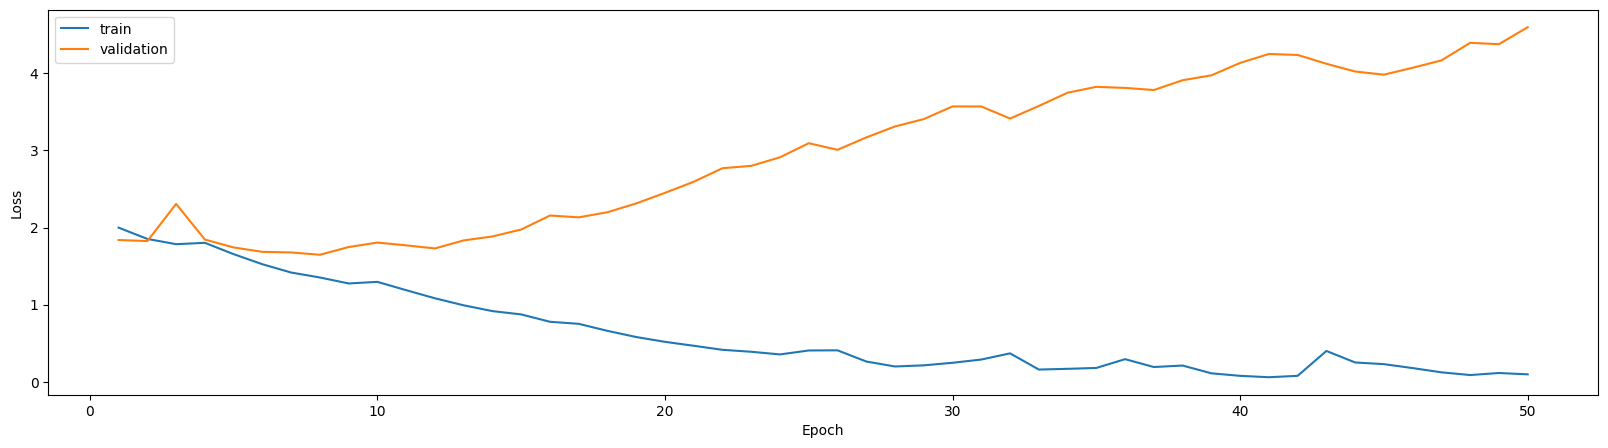

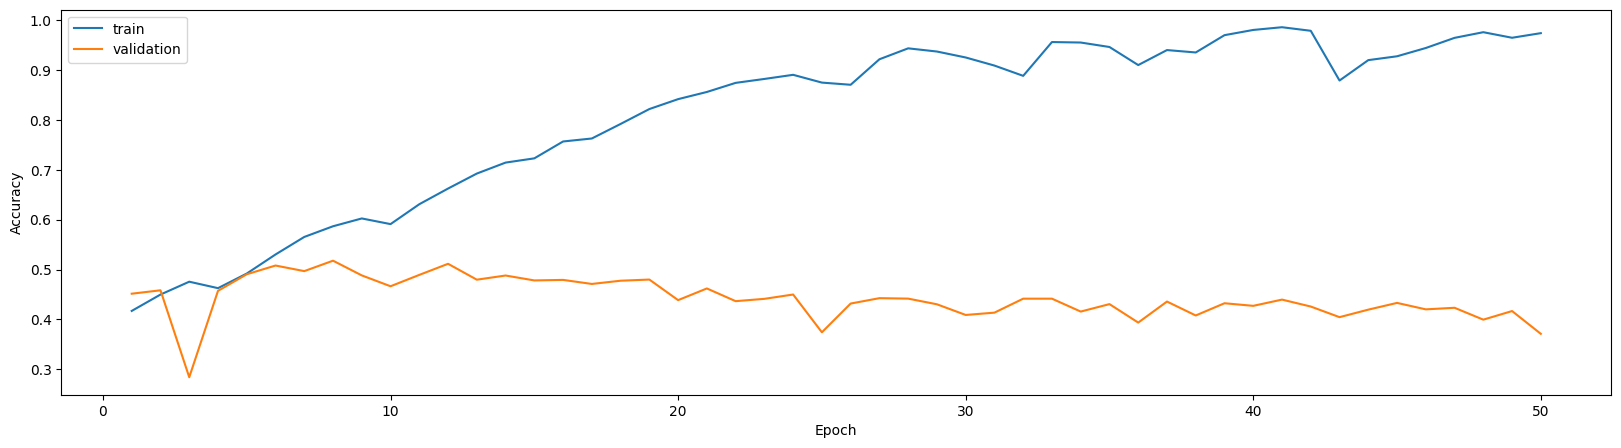

	Evaluation: 100%|██████████| 193/193 [00:02<00:00, 86.12it/s]



Test Loss: 1.641 | Test Acc: 52.18% | Test F1: 0.476 | Test ROC AUC: 0.799

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.79      0.65      4983
           1       0.69      0.49      0.57       672
           2       0.42      0.38      0.40      1070
           3       0.35      0.34      0.35       667
           4       0.24      0.05      0.09       837
           5       0.49      0.13      0.21       144
           6       0.50      0.02      0.04       351
           7       0.38      0.25      0.30       551
           8       0.17      0.06      0.08       200
           9       0.61      0.73      0.67       614
          10       0.27      0.02      0.04       570
          11       0.58      0.18      0.28       208
          12       0.70      0.64      0.67       844
          13       0.33      0.44      0.38       629

    accuracy                           0.52     12340
   macro avg       0.45      0.32 

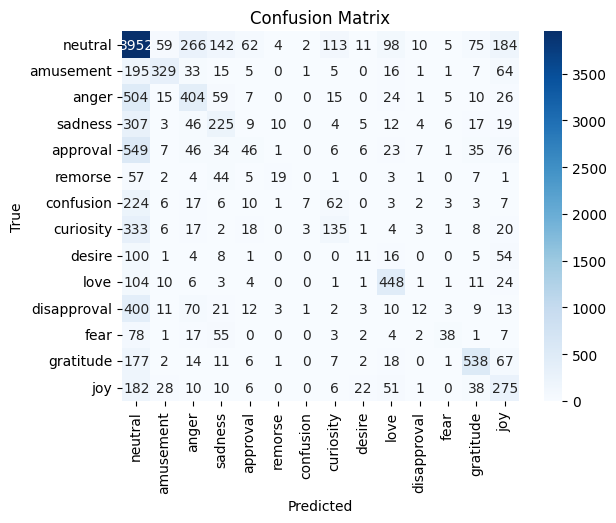

In [ ]:
# plot training curves

import matplotlib.pyplot as plt

# create epoch list
epochs = list(range(1, N_EPOCHS+1))

# plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, valid_loss_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, valid_acc_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#######
# print out required metrics

import seaborn as sns
model.load_state_dict(torch.load('model-glove-twitter.pt'))

test_loss, test_acc, test_f1, test_roc_auc, test_report, test_cm = evaluate(model, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f} | Test ROC AUC: {test_roc_auc:.3f}\n')
# print(f'Confusion matrix:\n{test_cm}')
print(f'Classification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import torch.nn as nn
from torch import optim

# Define an RNN class
class pretrainedRNN1(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pretrained_embeddings, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=pad_idx)
        # self.embedding = nn.Embedding(input_dim, embedding_dim)
        # self.embedding.weight.data.copy_(pretrained_embeddings) # copy pre-trained vectors to embedding layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.fc = nn.Linear(hidden_dim, output_dim[1]) # output_dim[0] is hidden_dim, output_dim[1] is output_dim

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)                          # VV note that lengths need to be on the CPU
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        output, hidden = self.rnn(embedded)

        return self.fc(hidden.squeeze(0))


# Setting model building arguments
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_vocab) # 14 output nodes
PAD_IDX = text_vocab["<pad>"]

model_glove_twitter_2 = pretrainedRNN1(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, pretrained_embeddings, PAD_IDX) # create a RNN model using the arguments
print(f'The model has {count_parameters(model_glove_twitter_2):,} trainable parameters')

# Set other parameters
optimizer = optim.Adam(model_glove_twitter_2.parameters())
criterion = nn.CrossEntropyLoss()

# Use GPU
model_glove_twitter_2 = model_glove_twitter_2.to(DEVICE)
criterion = criterion.to(DEVICE)

The model has 95,246 trainable parameters


In [ ]:
######
N_EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model_glove_twitter_2, train_dataloader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    # valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    valid_loss, valid_acc, valid_f1, valid_auc_roc, valid_report, valid_cm  = evaluate(model_glove_twitter_2, valid_dataloader, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_glove_twitter_2.state_dict(), 'model_glove_twitter_2.pt')


Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 315/315 [00:03<00:00, 101.99it/s]


	Train Loss: 2.001 | Train Acc: 41.57%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.07it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.913 |  Val. Acc: 44.00%
Epoch: 02


	Training: 100%|██████████| 315/315 [00:04<00:00, 71.44it/s]


	Train Loss: 1.869 | Train Acc: 43.95%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 107.36it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.831 |  Val. Acc: 45.47%
Epoch: 03


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.50it/s]


	Train Loss: 1.875 | Train Acc: 44.04%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.27it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.924 |  Val. Acc: 44.23%
Epoch: 04


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.49it/s]


	Train Loss: 1.850 | Train Acc: 44.90%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.32it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.836 |  Val. Acc: 45.99%
Epoch: 05


	Training: 100%|██████████| 315/315 [00:03<00:00, 80.47it/s]


	Train Loss: 1.800 | Train Acc: 45.14%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.06it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.799 |  Val. Acc: 48.29%
Epoch: 06


	Training: 100%|██████████| 315/315 [00:03<00:00, 99.98it/s] 


	Train Loss: 1.809 | Train Acc: 45.59%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.64it/s]


	 Val. Loss: 1.826 |  Val. Acc: 46.33%
Epoch: 07


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.48it/s]


	Train Loss: 1.812 | Train Acc: 45.33%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.49it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.906 |  Val. Acc: 43.90%
Epoch: 08


	Training: 100%|██████████| 315/315 [00:03<00:00, 95.31it/s]


	Train Loss: 1.806 | Train Acc: 45.83%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.36it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.809 |  Val. Acc: 46.82%
Epoch: 09


	Training: 100%|██████████| 315/315 [00:03<00:00, 79.89it/s] 


	Train Loss: 1.803 | Train Acc: 45.80%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.01it/s]


	 Val. Loss: 1.825 |  Val. Acc: 47.07%
Epoch: 10


	Training: 100%|██████████| 315/315 [00:02<00:00, 108.05it/s]


	Train Loss: 1.730 | Train Acc: 47.18%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.44it/s]


	 Val. Loss: 1.779 |  Val. Acc: 47.67%
Epoch: 11


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.33it/s]


	Train Loss: 1.663 | Train Acc: 49.04%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 101.79it/s]


	 Val. Loss: 1.723 |  Val. Acc: 49.30%
Epoch: 12


	Training: 100%|██████████| 315/315 [00:04<00:00, 71.36it/s]


	Train Loss: 1.819 | Train Acc: 45.30%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.09it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.969 |  Val. Acc: 43.07%
Epoch: 13


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.68it/s]


	Train Loss: 1.831 | Train Acc: 44.77%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.15it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.848 |  Val. Acc: 44.58%
Epoch: 14


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.67it/s]


	Train Loss: 1.702 | Train Acc: 47.62%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.02it/s]


	 Val. Loss: 1.870 |  Val. Acc: 45.26%
Epoch: 15


	Training: 100%|██████████| 315/315 [00:04<00:00, 71.89it/s]


	Train Loss: 1.704 | Train Acc: 47.96%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.84it/s]


	 Val. Loss: 1.801 |  Val. Acc: 47.72%
Epoch: 16


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.48it/s]


	Train Loss: 1.784 | Train Acc: 45.71%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.00it/s]


	 Val. Loss: 1.799 |  Val. Acc: 46.26%
Epoch: 17


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.93it/s]


	Train Loss: 1.651 | Train Acc: 48.58%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.64it/s]


	 Val. Loss: 1.760 |  Val. Acc: 48.55%
Epoch: 18


	Training: 100%|██████████| 315/315 [00:03<00:00, 86.33it/s]


	Train Loss: 1.635 | Train Acc: 49.50%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.41it/s]


	 Val. Loss: 1.959 |  Val. Acc: 40.83%
Epoch: 19


	Training: 100%|██████████| 315/315 [00:03<00:00, 91.29it/s] 


	Train Loss: 1.713 | Train Acc: 46.91%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.68it/s]


	 Val. Loss: 1.812 |  Val. Acc: 45.24%
Epoch: 20


	Training: 100%|██████████| 315/315 [00:02<00:00, 108.18it/s]


	Train Loss: 1.592 | Train Acc: 50.38%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.65it/s]


	 Val. Loss: 1.775 |  Val. Acc: 46.31%
Epoch: 21


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.04it/s]


	Train Loss: 1.562 | Train Acc: 51.67%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 92.66it/s]


	 Val. Loss: 1.761 |  Val. Acc: 48.71%
Epoch: 22


	Training: 100%|██████████| 315/315 [00:04<00:00, 75.73it/s]


	Train Loss: 1.528 | Train Acc: 52.70%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.96it/s]


	 Val. Loss: 1.790 |  Val. Acc: 47.92%
Epoch: 23


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.98it/s]


	Train Loss: 1.501 | Train Acc: 53.24%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.09it/s]


	 Val. Loss: 1.755 |  Val. Acc: 48.29%
Epoch: 24


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.43it/s]


	Train Loss: 1.466 | Train Acc: 54.14%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 126.62it/s]


	 Val. Loss: 1.743 |  Val. Acc: 49.43%
Epoch: 25


	Training: 100%|██████████| 315/315 [00:04<00:00, 70.48it/s]


	Train Loss: 1.408 | Train Acc: 55.84%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 112.73it/s]


	 Val. Loss: 1.764 |  Val. Acc: 49.49%
Epoch: 26


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.45it/s]


	Train Loss: 1.382 | Train Acc: 56.10%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.43it/s]


	 Val. Loss: 1.761 |  Val. Acc: 48.43%
Epoch: 27


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.62it/s]


	Train Loss: 1.338 | Train Acc: 57.60%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.29it/s]


	 Val. Loss: 1.777 |  Val. Acc: 49.33%
Epoch: 28


	Training: 100%|██████████| 315/315 [00:04<00:00, 78.17it/s]


	Train Loss: 1.424 | Train Acc: 55.50%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 87.47it/s]


	 Val. Loss: 1.836 |  Val. Acc: 46.98%
Epoch: 29


	Training: 100%|██████████| 315/315 [00:03<00:00, 100.57it/s]


	Train Loss: 1.435 | Train Acc: 54.59%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.49it/s]


	 Val. Loss: 1.805 |  Val. Acc: 46.78%
Epoch: 30


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.23it/s]


	Train Loss: 1.381 | Train Acc: 56.31%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.30it/s]


	 Val. Loss: 1.982 |  Val. Acc: 44.80%
Epoch: 31


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.06it/s]


	Train Loss: 1.377 | Train Acc: 56.38%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.30it/s]


	 Val. Loss: 1.825 |  Val. Acc: 47.37%
Epoch: 32


	Training: 100%|██████████| 315/315 [00:03<00:00, 83.37it/s] 


	Train Loss: 1.232 | Train Acc: 60.33%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.04it/s]


	 Val. Loss: 1.823 |  Val. Acc: 49.35%
Epoch: 33


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.41it/s]


	Train Loss: 1.199 | Train Acc: 61.63%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.22it/s]


	 Val. Loss: 1.843 |  Val. Acc: 48.38%
Epoch: 34


	Training: 100%|██████████| 315/315 [00:02<00:00, 108.56it/s]


	Train Loss: 1.371 | Train Acc: 56.99%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 105.11it/s]


	 Val. Loss: 1.985 |  Val. Acc: 43.79%
Epoch: 35


	Training: 100%|██████████| 315/315 [00:04<00:00, 71.75it/s]


	Train Loss: 1.697 | Train Acc: 48.48%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.22it/s]


	 Val. Loss: 2.029 |  Val. Acc: 43.33%
Epoch: 36


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.07it/s]


	Train Loss: 1.509 | Train Acc: 52.55%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.14it/s]


	 Val. Loss: 1.864 |  Val. Acc: 45.88%
Epoch: 37


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.24it/s]


	Train Loss: 1.403 | Train Acc: 55.35%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 142.00it/s]


	 Val. Loss: 1.871 |  Val. Acc: 46.56%
Epoch: 38


	Training: 100%|██████████| 315/315 [00:04<00:00, 75.49it/s]


	Train Loss: 1.307 | Train Acc: 58.10%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 87.48it/s]


	 Val. Loss: 1.862 |  Val. Acc: 46.82%
Epoch: 39


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.27it/s]


	Train Loss: 1.313 | Train Acc: 57.72%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.76it/s]


	 Val. Loss: 1.872 |  Val. Acc: 48.23%
Epoch: 40


	Training: 100%|██████████| 315/315 [00:02<00:00, 107.35it/s]


	Train Loss: 1.287 | Train Acc: 58.38%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.95it/s]


	 Val. Loss: 1.893 |  Val. Acc: 47.12%
Epoch: 41


	Training: 100%|██████████| 315/315 [00:03<00:00, 88.93it/s]


	Train Loss: 1.194 | Train Acc: 61.33%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 91.97it/s]


	 Val. Loss: 1.903 |  Val. Acc: 47.49%
Epoch: 42


	Training: 100%|██████████| 315/315 [00:03<00:00, 85.94it/s] 


	Train Loss: 1.367 | Train Acc: 56.99%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.74it/s]


	 Val. Loss: 1.941 |  Val. Acc: 45.69%
Epoch: 43


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.92it/s]


	Train Loss: 1.385 | Train Acc: 55.63%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.91it/s]


	 Val. Loss: 1.914 |  Val. Acc: 46.44%
Epoch: 44


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.13it/s]


	Train Loss: 1.290 | Train Acc: 58.46%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.57it/s]


	 Val. Loss: 1.904 |  Val. Acc: 46.15%
Epoch: 45


	Training: 100%|██████████| 315/315 [00:04<00:00, 75.45it/s] 


	Train Loss: 1.202 | Train Acc: 61.18%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.62it/s]


	 Val. Loss: 1.977 |  Val. Acc: 46.46%
Epoch: 46


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.92it/s]


	Train Loss: 1.193 | Train Acc: 61.51%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.00it/s]


	 Val. Loss: 1.971 |  Val. Acc: 45.17%
Epoch: 47


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.39it/s]


	Train Loss: 1.077 | Train Acc: 64.98%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.24it/s]


	 Val. Loss: 1.978 |  Val. Acc: 44.96%
Epoch: 48


	Training: 100%|██████████| 315/315 [00:04<00:00, 71.50it/s]


	Train Loss: 1.083 | Train Acc: 64.71%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 103.96it/s]


	 Val. Loss: 2.004 |  Val. Acc: 44.39%
Epoch: 49


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.81it/s]


	Train Loss: 1.009 | Train Acc: 67.44%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.58it/s]


	 Val. Loss: 2.096 |  Val. Acc: 42.79%
Epoch: 50


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.35it/s]


	Train Loss: 1.046 | Train Acc: 65.98%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.16it/s]


	 Val. Loss: 2.094 |  Val. Acc: 44.55%


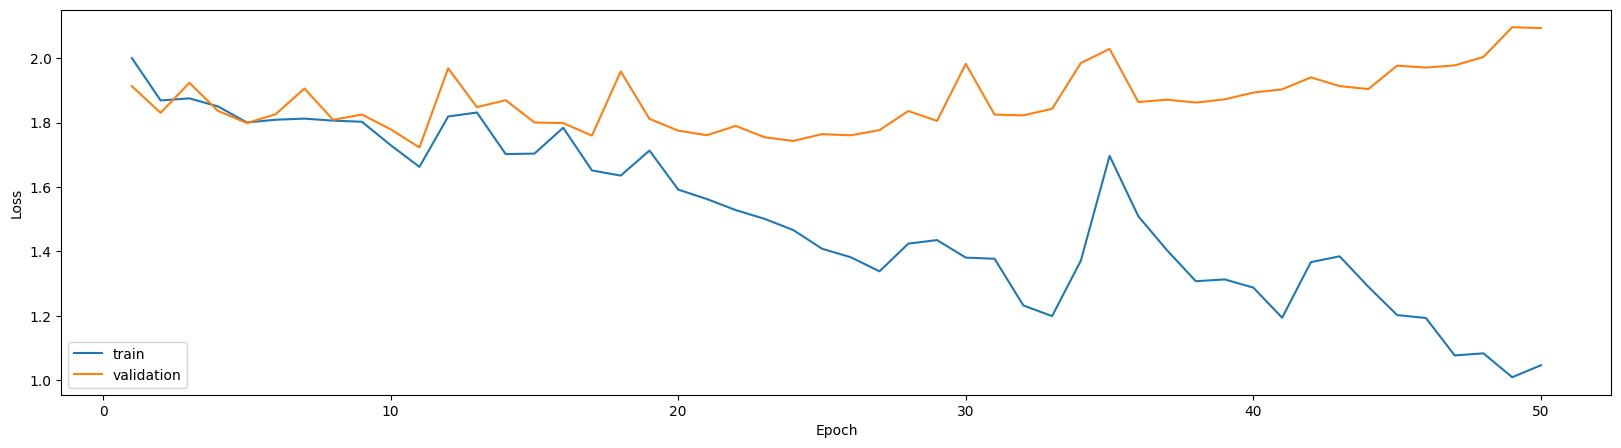

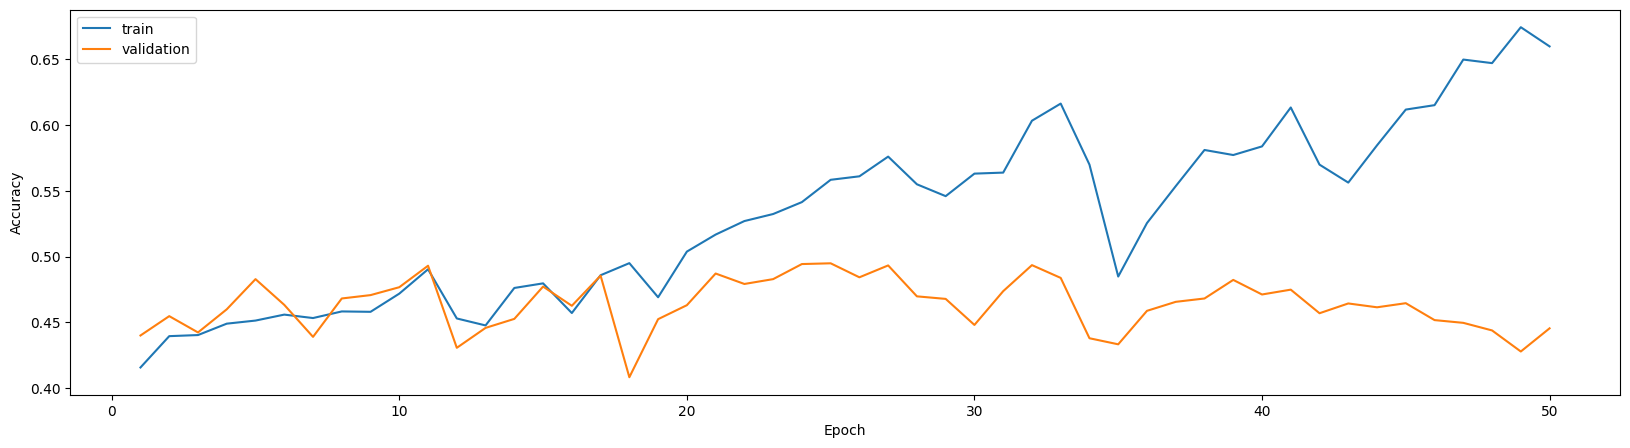

	Evaluation: 100%|██████████| 193/193 [00:01<00:00, 105.86it/s]



Test Loss: 1.703 | Test Acc: 49.60% | Test F1: 0.433 | Test ROC AUC: 0.770

Classification report:
              precision    recall  f1-score   support

           0       0.51      0.84      0.64      4983
           1       0.64      0.29      0.40       672
           2       0.36      0.30      0.32      1070
           3       0.33      0.32      0.32       667
           4       0.27      0.01      0.02       837
           5       0.31      0.11      0.16       144
           6       0.25      0.01      0.01       351
           7       0.38      0.29      0.33       551
           8       0.12      0.01      0.02       200
           9       0.51      0.63      0.57       614
          10       0.21      0.01      0.01       570
          11       0.50      0.09      0.15       208
          12       0.75      0.58      0.65       844
          13       0.34      0.22      0.27       629

    accuracy                           0.50     12340
   macro avg       0.39      0.26 

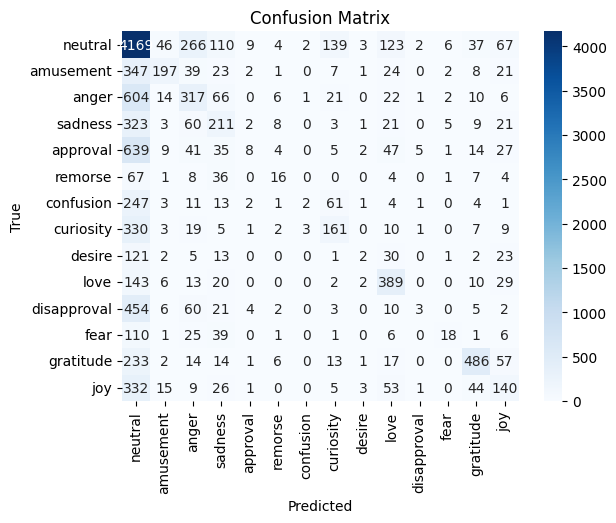

In [ ]:
# plot training curves

import matplotlib.pyplot as plt

# create epoch list
epochs = list(range(1, N_EPOCHS+1))

# plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, valid_loss_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, valid_acc_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#######
# print out required metrics

import seaborn as sns
model_glove_twitter_2.load_state_dict(torch.load('model_glove_twitter_2.pt'))

test_loss, test_acc, test_f1, test_roc_auc, test_report, test_cm = evaluate(model_glove_twitter_2, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f} | Test ROC AUC: {test_roc_auc:.3f}\n')
# print(f'Confusion matrix:\n{test_cm}')
print(f'Classification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



---



---



---





---



---



---

## 1.D.2 GloVe twitter vectors : 27B, dim=100
### Changing max vocab size to 100000 to check if it affects performance

In [ ]:
from torchtext import vocab

MAX_VOCAB_SIZE = 100_000

glove_vectors1 = vocab.GloVe(
    name="twitter.27B",
    dim="100",
    max_vectors=MAX_VOCAB_SIZE
)

100%|█████████▉| 99999/100000 [00:10<00:00, 9500.98it/s] 


In [ ]:
from torchtext.vocab import vocab

text_vocab = vocab(glove_vectors1.stoi, min_freq=0, specials=("<unk>", "<pad>"), special_first=True)
text_vocab.set_default_index(text_vocab["<unk>"])

pretrained_embeddings = glove_vectors1.vectors
pretrained_embeddings = torch.cat([
    torch.empty(1, glove_vectors1.dim).normal_(),  # unk token vector
    torch.zeros(1, glove_vectors1.dim),  # padding token vector
    pretrained_embeddings
])

print("Vocab size: ", len(text_vocab))
print("Pretrained vectors shape: ", pretrained_embeddings.shape)
print("<unk> vector: ", pretrained_embeddings[text_vocab["<unk>"]])
print("<pad> vector: ", pretrained_embeddings[text_vocab["<pad>"]])

Vocab size:  100002
Pretrained vectors shape:  torch.Size([100002, 100])
<unk> vector:  tensor([-0.1117, -0.4966,  0.1631, -0.8817,  0.0539,  0.6684, -0.0597, -0.4675,
        -0.2153,  0.8840, -0.7584, -0.3689, -0.3424, -1.4020,  0.3206, -1.0219,
         0.7988, -0.0923, -0.7049, -1.6024,  0.2891,  0.4899, -0.3853, -0.7120,
        -0.1706, -1.4594,  0.2207,  0.2463, -1.3248,  0.6970, -0.6631,  1.2158,
        -1.4949,  0.8810, -1.1786, -0.9340, -0.5675, -0.2772, -2.1834,  0.3668,
         0.9380,  0.0078, -0.3139, -1.1567,  1.8409, -1.0174,  1.2192,  0.1601,
         1.5985, -0.0469, -1.5270, -2.0143, -1.5173,  0.3877, -1.1849,  0.6897,
         1.3232,  1.8169,  0.6808,  0.7244,  0.0323, -1.6593, -1.8773,  0.7372,
         0.9257,  0.9247,  0.1825, -0.0737,  0.3147, -1.0369,  0.2100,  0.6144,
         0.0628, -0.3297, -1.7970,  0.8728,  0.7670, -0.1138, -0.9428,  0.7540,
         0.1407, -0.6937, -0.6159, -0.7295,  1.3204,  1.5997, -1.0792, -0.3396,
        -1.4538, -2.6740,  1.598

In [ ]:
from collections import OrderedDict
label_vocab = vocab(OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)]))


In [ ]:
import torchtext.transforms as T

text_transform = T.Sequential(
    SpacyTokenizer(),  # Tokenize
    T.VocabTransform(text_vocab),  # Conver to vocab IDs
    T.ToTensor(padding_value=text_vocab["<pad>"]),  # Convert to tensor and pad
)

label_transform = T.Sequential(
    # T.LabelToIndex(label_vocab.get_itos()),  # Convert to integer #labels are already integers
    T.ToTensor(),  # Convert to tensor
)

lengths_transform = T.Sequential(
    SpacyTokenizer(),
    ToLengths(),
    T.ToTensor(),
)

In [ ]:
train_dataloader = _get_dataloader(train_data)
valid_dataloader = _get_dataloader(valid_data)
test_dataloader = _get_dataloader(test_data)

In [ ]:
import torch.nn as nn
from torch import optim

# Define an RNN class
class pretrainedRNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pretrained_embeddings):
        super().__init__()
        # self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=pad_idx)

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings) # copy pre-trained vectors to embedding layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.fc = nn.Linear(hidden_dim, output_dim[1]) # output_dim[0] is hidden_dim, output_dim[1] is output_dim

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)                          # VV note that lengths need to be on the CPU
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        output, hidden = self.rnn(embedded)

        return self.fc(hidden.squeeze(0))


# Setting model building arguments
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_vocab) # 14 output nodes

model = pretrainedRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, pretrained_embeddings) # create a RNN model using the arguments
print(f'The model has {count_parameters(model):,} trainable parameters')

# Set other parameters
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Use GPU
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

The model has 10,095,446 trainable parameters


In [ ]:
######
N_EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    # valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    valid_loss, valid_acc, valid_f1, valid_auc_roc, valid_report, valid_cm  = evaluate(model, valid_dataloader, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model-glove-twitter.pt')


Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 315/315 [00:06<00:00, 45.27it/s]


	Train Loss: 1.989 | Train Acc: 41.72%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 80.78it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.916 |  Val. Acc: 42.01%
Epoch: 02


	Training: 100%|██████████| 315/315 [00:05<00:00, 54.25it/s]


	Train Loss: 1.829 | Train Acc: 45.54%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.64it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.797 |  Val. Acc: 46.56%
Epoch: 03


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.14it/s]


	Train Loss: 1.689 | Train Acc: 49.61%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.21it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.760 |  Val. Acc: 47.92%
Epoch: 04


	Training: 100%|██████████| 315/315 [00:05<00:00, 62.30it/s]


	Train Loss: 1.598 | Train Acc: 51.82%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.55it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.752 |  Val. Acc: 47.88%
Epoch: 05


	Training: 100%|██████████| 315/315 [00:04<00:00, 67.73it/s]


	Train Loss: 1.570 | Train Acc: 52.08%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.43it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.756 |  Val. Acc: 50.18%
Epoch: 06


	Training: 100%|██████████| 315/315 [00:04<00:00, 73.60it/s]


	Train Loss: 1.414 | Train Acc: 55.75%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 126.20it/s]


	 Val. Loss: 1.749 |  Val. Acc: 49.04%
Epoch: 07


	Training: 100%|██████████| 315/315 [00:05<00:00, 54.92it/s]


	Train Loss: 1.324 | Train Acc: 58.98%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.00it/s]


	 Val. Loss: 1.813 |  Val. Acc: 47.10%
Epoch: 08


	Training: 100%|██████████| 315/315 [00:04<00:00, 71.66it/s]


	Train Loss: 1.280 | Train Acc: 60.16%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.37it/s]


	 Val. Loss: 1.871 |  Val. Acc: 47.01%
Epoch: 09


	Training: 100%|██████████| 315/315 [00:04<00:00, 63.05it/s]


	Train Loss: 1.137 | Train Acc: 64.92%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 87.57it/s]


	 Val. Loss: 1.859 |  Val. Acc: 48.12%
Epoch: 10


	Training: 100%|██████████| 315/315 [00:04<00:00, 69.19it/s]


	Train Loss: 1.103 | Train Acc: 66.10%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.80it/s]


	 Val. Loss: 1.897 |  Val. Acc: 47.58%
Epoch: 11


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.73it/s]


	Train Loss: 0.950 | Train Acc: 70.88%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 117.53it/s]


	 Val. Loss: 2.020 |  Val. Acc: 45.32%
Epoch: 12


	Training: 100%|██████████| 315/315 [00:05<00:00, 57.15it/s]


	Train Loss: 1.090 | Train Acc: 66.50%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.90it/s]


	 Val. Loss: 2.073 |  Val. Acc: 45.21%
Epoch: 13


	Training: 100%|██████████| 315/315 [00:04<00:00, 74.15it/s]


	Train Loss: 0.894 | Train Acc: 72.48%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 141.54it/s]


	 Val. Loss: 2.110 |  Val. Acc: 44.25%
Epoch: 14


	Training: 100%|██████████| 315/315 [00:04<00:00, 64.48it/s]


	Train Loss: 0.804 | Train Acc: 75.32%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.57it/s]


	 Val. Loss: 2.260 |  Val. Acc: 44.36%
Epoch: 15


	Training: 100%|██████████| 315/315 [00:04<00:00, 67.67it/s]


	Train Loss: 0.699 | Train Acc: 78.53%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 143.45it/s]


	 Val. Loss: 2.324 |  Val. Acc: 44.34%
Epoch: 16


	Training: 100%|██████████| 315/315 [00:04<00:00, 73.17it/s]


	Train Loss: 0.613 | Train Acc: 81.30%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 141.93it/s]


	 Val. Loss: 2.494 |  Val. Acc: 43.02%
Epoch: 17


	Training: 100%|██████████| 315/315 [00:05<00:00, 55.75it/s]


	Train Loss: 0.581 | Train Acc: 82.36%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 143.21it/s]


	 Val. Loss: 2.607 |  Val. Acc: 40.62%
Epoch: 18


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.90it/s]


	Train Loss: 0.613 | Train Acc: 81.13%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.14it/s]


	 Val. Loss: 2.713 |  Val. Acc: 39.88%
Epoch: 19


	Training: 100%|██████████| 315/315 [00:04<00:00, 64.92it/s]


	Train Loss: 0.461 | Train Acc: 86.20%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 87.68it/s]


	 Val. Loss: 2.792 |  Val. Acc: 41.97%
Epoch: 20


	Training: 100%|██████████| 315/315 [00:04<00:00, 65.99it/s]


	Train Loss: 0.455 | Train Acc: 86.35%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.10it/s]


	 Val. Loss: 2.964 |  Val. Acc: 40.40%
Epoch: 21


	Training: 100%|██████████| 315/315 [00:04<00:00, 73.20it/s]


	Train Loss: 0.357 | Train Acc: 89.29%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.17it/s]


	 Val. Loss: 3.086 |  Val. Acc: 40.38%
Epoch: 22


	Training: 100%|██████████| 315/315 [00:05<00:00, 54.84it/s]


	Train Loss: 0.292 | Train Acc: 91.37%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.16it/s]


	 Val. Loss: 3.236 |  Val. Acc: 41.29%
Epoch: 23


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.99it/s]


	Train Loss: 0.252 | Train Acc: 92.70%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 140.80it/s]


	 Val. Loss: 3.319 |  Val. Acc: 41.11%
Epoch: 24


	Training: 100%|██████████| 315/315 [00:04<00:00, 66.47it/s]


	Train Loss: 0.230 | Train Acc: 93.18%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 87.68it/s]


	 Val. Loss: 3.634 |  Val. Acc: 41.14%
Epoch: 25


	Training: 100%|██████████| 315/315 [00:04<00:00, 64.00it/s]


	Train Loss: 0.318 | Train Acc: 90.30%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.77it/s]


	 Val. Loss: 3.616 |  Val. Acc: 39.09%
Epoch: 26


	Training: 100%|██████████| 315/315 [00:04<00:00, 73.31it/s]


	Train Loss: 0.239 | Train Acc: 92.71%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.50it/s]


	 Val. Loss: 3.666 |  Val. Acc: 40.59%
Epoch: 27


	Training: 100%|██████████| 315/315 [00:05<00:00, 54.10it/s]


	Train Loss: 0.182 | Train Acc: 94.85%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 124.97it/s]


	 Val. Loss: 3.842 |  Val. Acc: 40.38%
Epoch: 28


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.65it/s]


	Train Loss: 0.274 | Train Acc: 91.40%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.53it/s]


	 Val. Loss: 3.911 |  Val. Acc: 38.75%
Epoch: 29


	Training: 100%|██████████| 315/315 [00:04<00:00, 67.16it/s]


	Train Loss: 0.193 | Train Acc: 94.37%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.47it/s]


	 Val. Loss: 3.897 |  Val. Acc: 38.51%
Epoch: 30


	Training: 100%|██████████| 315/315 [00:04<00:00, 63.42it/s]


	Train Loss: 0.185 | Train Acc: 94.31%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.90it/s]


	 Val. Loss: 4.188 |  Val. Acc: 37.75%
Epoch: 31


	Training: 100%|██████████| 315/315 [00:04<00:00, 73.79it/s]


	Train Loss: 0.233 | Train Acc: 92.90%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 142.56it/s]


	 Val. Loss: 4.022 |  Val. Acc: 40.01%
Epoch: 32


	Training: 100%|██████████| 315/315 [00:05<00:00, 55.21it/s]


	Train Loss: 0.160 | Train Acc: 95.41%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 113.98it/s]


	 Val. Loss: 4.137 |  Val. Acc: 40.67%
Epoch: 33


	Training: 100%|██████████| 315/315 [00:04<00:00, 73.38it/s]


	Train Loss: 0.092 | Train Acc: 97.62%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 139.62it/s]


	 Val. Loss: 4.360 |  Val. Acc: 39.40%
Epoch: 34


	Training: 100%|██████████| 315/315 [00:04<00:00, 68.30it/s]


	Train Loss: 0.242 | Train Acc: 92.64%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 84.49it/s]


	 Val. Loss: 4.112 |  Val. Acc: 40.44%
Epoch: 35


	Training: 100%|██████████| 315/315 [00:05<00:00, 61.83it/s]


	Train Loss: 0.242 | Train Acc: 92.48%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.31it/s]


	 Val. Loss: 4.205 |  Val. Acc: 38.87%
Epoch: 36


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.80it/s]


	Train Loss: 0.171 | Train Acc: 94.65%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.39it/s]


	 Val. Loss: 4.408 |  Val. Acc: 38.59%
Epoch: 37


	Training: 100%|██████████| 315/315 [00:05<00:00, 55.99it/s]


	Train Loss: 0.111 | Train Acc: 96.85%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 98.56it/s] 


	 Val. Loss: 4.461 |  Val. Acc: 39.23%
Epoch: 38


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.71it/s]


	Train Loss: 0.080 | Train Acc: 97.79%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.49it/s]


	 Val. Loss: 4.692 |  Val. Acc: 38.40%
Epoch: 39


	Training: 100%|██████████| 315/315 [00:04<00:00, 71.59it/s]


	Train Loss: 0.073 | Train Acc: 98.17%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 89.93it/s]


	 Val. Loss: 4.691 |  Val. Acc: 39.65%
Epoch: 40


	Training: 100%|██████████| 315/315 [00:05<00:00, 59.40it/s]


	Train Loss: 0.093 | Train Acc: 97.28%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 141.85it/s]


	 Val. Loss: 4.718 |  Val. Acc: 39.49%
Epoch: 41


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.75it/s]


	Train Loss: 0.381 | Train Acc: 88.58%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.34it/s]


	 Val. Loss: 4.319 |  Val. Acc: 37.26%
Epoch: 42


	Training: 100%|██████████| 315/315 [00:05<00:00, 57.33it/s]


	Train Loss: 0.307 | Train Acc: 90.49%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 87.26it/s] 


	 Val. Loss: 4.277 |  Val. Acc: 38.40%
Epoch: 43


	Training: 100%|██████████| 315/315 [00:04<00:00, 71.95it/s]


	Train Loss: 0.124 | Train Acc: 96.22%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 138.14it/s]


	 Val. Loss: 4.360 |  Val. Acc: 40.40%
Epoch: 44


	Training: 100%|██████████| 315/315 [00:04<00:00, 70.22it/s]


	Train Loss: 0.069 | Train Acc: 98.16%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.37it/s]


	 Val. Loss: 4.487 |  Val. Acc: 40.88%
Epoch: 45


	Training: 100%|██████████| 315/315 [00:05<00:00, 60.98it/s]


	Train Loss: 0.050 | Train Acc: 98.74%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.54it/s]


	 Val. Loss: 4.617 |  Val. Acc: 39.30%
Epoch: 46


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.56it/s]


	Train Loss: 0.045 | Train Acc: 98.87%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 141.85it/s]


	 Val. Loss: 4.802 |  Val. Acc: 40.25%
Epoch: 47


	Training: 100%|██████████| 315/315 [00:05<00:00, 58.01it/s]


	Train Loss: 0.048 | Train Acc: 98.71%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 84.95it/s]


	 Val. Loss: 4.874 |  Val. Acc: 40.31%
Epoch: 48


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.53it/s]


	Train Loss: 0.295 | Train Acc: 91.17%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.34it/s]


	 Val. Loss: 4.713 |  Val. Acc: 35.33%
Epoch: 49


	Training: 100%|██████████| 315/315 [00:04<00:00, 70.65it/s]


	Train Loss: 0.237 | Train Acc: 92.54%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 83.00it/s]


	 Val. Loss: 4.515 |  Val. Acc: 39.70%
Epoch: 50


	Training: 100%|██████████| 315/315 [00:05<00:00, 59.81it/s]


	Train Loss: 0.124 | Train Acc: 96.15%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.86it/s]


	 Val. Loss: 4.706 |  Val. Acc: 37.75%


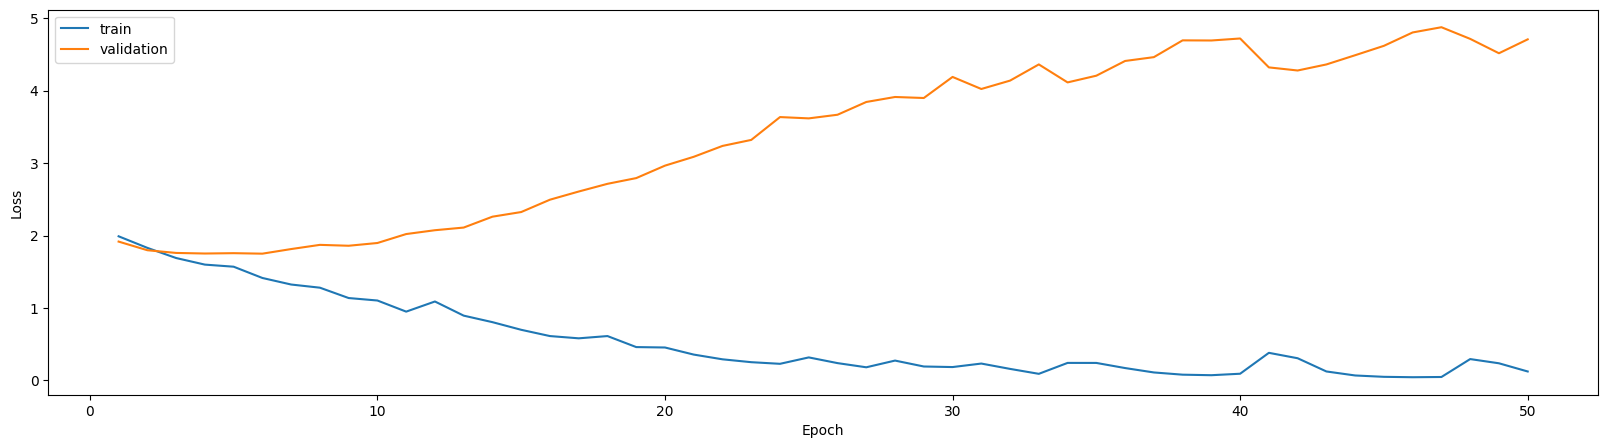

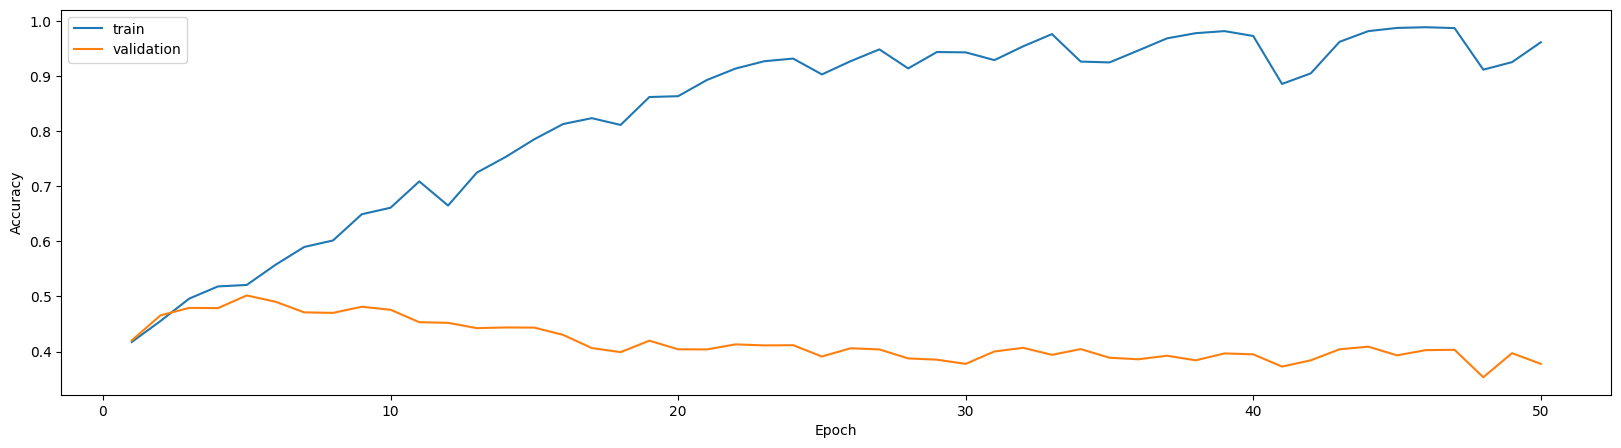

	Evaluation: 100%|██████████| 193/193 [00:02<00:00, 87.39it/s]



Test Loss: 1.746 | Test Acc: 49.18% | Test F1: 0.443 | Test ROC AUC: 0.771

Classification report:
              precision    recall  f1-score   support

           0       0.53      0.77      0.63      4960
           1       0.58      0.47      0.52       647
           2       0.43      0.32      0.37      1116
           3       0.36      0.15      0.21       690
           4       0.19      0.05      0.08       849
           5       0.30      0.17      0.22       142
           6       0.14      0.15      0.14       325
           7       0.39      0.36      0.37       557
           8       0.29      0.01      0.02       172
           9       0.60      0.69      0.64       595
          10       0.19      0.04      0.07       594
          11       0.54      0.06      0.10       231
          12       0.50      0.75      0.60       816
          13       0.37      0.17      0.23       646

    accuracy                           0.49     12340
   macro avg       0.39      0.30 

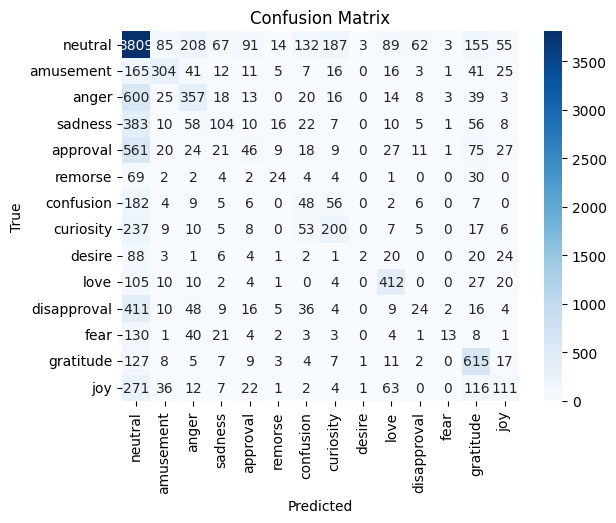

In [ ]:
# plot training curves

import matplotlib.pyplot as plt

# create epoch list
epochs = list(range(1, N_EPOCHS+1))

# plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, valid_loss_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, valid_acc_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#######
# print out required metrics

import seaborn as sns
model.load_state_dict(torch.load('model-glove-twitter.pt'))

test_loss, test_acc, test_f1, test_roc_auc, test_report, test_cm = evaluate(model, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f} | Test ROC AUC: {test_roc_auc:.3f}\n')
# print(f'Confusion matrix:\n{test_cm}')
print(f'Classification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import torch.nn as nn
from torch import optim

# Define an RNN class
class pretrainedRNN1(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pretrained_embeddings, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=pad_idx)
        # self.embedding = nn.Embedding(input_dim, embedding_dim)
        # self.embedding.weight.data.copy_(pretrained_embeddings) # copy pre-trained vectors to embedding layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.fc = nn.Linear(hidden_dim, output_dim[1]) # output_dim[0] is hidden_dim, output_dim[1] is output_dim

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)                          # VV note that lengths need to be on the CPU
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        output, hidden = self.rnn(embedded)

        return self.fc(hidden.squeeze(0))


# Setting model building arguments
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(label_vocab) # 14 output nodes
PAD_IDX = text_vocab["<pad>"]

model_glove_twitter_2 = pretrainedRNN1(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, pretrained_embeddings, PAD_IDX) # create a RNN model using the arguments
print(f'The model has {count_parameters(model_glove_twitter_2):,} trainable parameters')

# Set other parameters
optimizer = optim.Adam(model_glove_twitter_2.parameters())
criterion = nn.CrossEntropyLoss()

# Use GPU
model_glove_twitter_2 = model_glove_twitter_2.to(DEVICE)
criterion = criterion.to(DEVICE)

The model has 95,246 trainable parameters


In [ ]:
######
N_EPOCHS = 50
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model_glove_twitter_2, train_dataloader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    # valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    valid_loss, valid_acc, valid_f1, valid_auc_roc, valid_report, valid_cm  = evaluate(model_glove_twitter_2, valid_dataloader, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_glove_twitter_2.state_dict(), 'model_glove_twitter_2.pt')


Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.29it/s]


	Train Loss: 2.024 | Train Acc: 40.94%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 94.99it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.976 |  Val. Acc: 43.20%
Epoch: 02


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.42it/s]


	Train Loss: 1.897 | Train Acc: 43.58%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.83it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.844 |  Val. Acc: 45.80%
Epoch: 03


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.49it/s]


	Train Loss: 1.880 | Train Acc: 43.29%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.62it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.874 |  Val. Acc: 43.80%
Epoch: 04


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.14it/s]


	Train Loss: 1.853 | Train Acc: 44.15%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 127.80it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.858 |  Val. Acc: 44.63%
Epoch: 05


	Training: 100%|██████████| 315/315 [00:04<00:00, 68.42it/s]


	Train Loss: 1.848 | Train Acc: 44.70%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 110.26it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.871 |  Val. Acc: 44.64%
Epoch: 06


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.36it/s]


	Train Loss: 1.790 | Train Acc: 45.82%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.70it/s]


	 Val. Loss: 1.823 |  Val. Acc: 45.53%
Epoch: 07


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.84it/s]


	Train Loss: 1.703 | Train Acc: 48.14%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.53it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.852 |  Val. Acc: 43.94%
Epoch: 08


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.94it/s]


	Train Loss: 1.681 | Train Acc: 48.98%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.38it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.805 |  Val. Acc: 46.70%
Epoch: 09


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.20it/s]


	Train Loss: 1.695 | Train Acc: 48.16%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.12it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.778 |  Val. Acc: 47.62%
Epoch: 10


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.39it/s]


	Train Loss: 1.638 | Train Acc: 49.98%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 131.14it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.794 |  Val. Acc: 48.10%
Epoch: 11


	Training: 100%|██████████| 315/315 [00:03<00:00, 83.53it/s]


	Train Loss: 1.601 | Train Acc: 51.02%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.54it/s]


	 Val. Loss: 1.739 |  Val. Acc: 49.50%
Epoch: 12


	Training: 100%|██████████| 315/315 [00:03<00:00, 90.56it/s]


	Train Loss: 1.754 | Train Acc: 46.85%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.35it/s]


	 Val. Loss: 2.079 |  Val. Acc: 43.27%
Epoch: 13


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.41it/s]


	Train Loss: 1.763 | Train Acc: 46.62%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.83it/s]


	 Val. Loss: 1.797 |  Val. Acc: 45.22%
Epoch: 14


	Training: 100%|██████████| 315/315 [00:03<00:00, 93.79it/s]


	Train Loss: 1.639 | Train Acc: 49.30%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 84.97it/s]


	 Val. Loss: 1.753 |  Val. Acc: 47.65%
Epoch: 15


	Training: 100%|██████████| 315/315 [00:03<00:00, 80.47it/s] 


	Train Loss: 1.570 | Train Acc: 51.54%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.23it/s]


	 Val. Loss: 1.754 |  Val. Acc: 49.26%
Epoch: 16


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.19it/s]


	Train Loss: 1.520 | Train Acc: 53.09%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.28it/s]


	 Val. Loss: 1.734 |  Val. Acc: 49.71%
Epoch: 17


	Training: 100%|██████████| 315/315 [00:03<00:00, 101.55it/s]


	Train Loss: 1.477 | Train Acc: 54.07%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 91.89it/s]


	 Val. Loss: 1.721 |  Val. Acc: 48.37%
Epoch: 18


	Training: 100%|██████████| 315/315 [00:04<00:00, 72.60it/s]


	Train Loss: 1.552 | Train Acc: 51.74%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.38it/s]


	 Val. Loss: 1.896 |  Val. Acc: 44.55%
Epoch: 19


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.58it/s]


	Train Loss: 1.611 | Train Acc: 50.31%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.18it/s]


	 Val. Loss: 1.735 |  Val. Acc: 49.71%
Epoch: 20


	Training: 100%|██████████| 315/315 [00:03<00:00, 101.93it/s]


	Train Loss: 1.506 | Train Acc: 53.09%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 128.30it/s]


	 Val. Loss: 1.788 |  Val. Acc: 46.87%
Epoch: 21


	Training: 100%|██████████| 315/315 [00:04<00:00, 68.56it/s]


	Train Loss: 1.447 | Train Acc: 54.52%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 110.59it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Val. Loss: 1.870 |  Val. Acc: 48.37%
Epoch: 22


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.34it/s]


	Train Loss: 1.400 | Train Acc: 55.92%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.09it/s]


	 Val. Loss: 1.762 |  Val. Acc: 49.57%
Epoch: 23


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.44it/s]


	Train Loss: 1.743 | Train Acc: 47.33%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 128.99it/s]


	 Val. Loss: 1.905 |  Val. Acc: 46.07%
Epoch: 24


	Training: 100%|██████████| 315/315 [00:04<00:00, 75.61it/s]


	Train Loss: 1.606 | Train Acc: 50.59%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.11it/s]


	 Val. Loss: 1.803 |  Val. Acc: 46.09%
Epoch: 25


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.14it/s]


	Train Loss: 1.576 | Train Acc: 50.77%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.17it/s]


	 Val. Loss: 1.803 |  Val. Acc: 46.97%
Epoch: 26


	Training: 100%|██████████| 315/315 [00:02<00:00, 106.08it/s]


	Train Loss: 1.479 | Train Acc: 53.32%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.31it/s]


	 Val. Loss: 1.784 |  Val. Acc: 47.16%
Epoch: 27


	Training: 100%|██████████| 315/315 [00:03<00:00, 86.66it/s]


	Train Loss: 1.422 | Train Acc: 54.52%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.17it/s]


	 Val. Loss: 1.788 |  Val. Acc: 46.24%
Epoch: 28


	Training: 100%|██████████| 315/315 [00:03<00:00, 86.52it/s] 


	Train Loss: 1.381 | Train Acc: 55.98%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.65it/s]


	 Val. Loss: 1.808 |  Val. Acc: 47.39%
Epoch: 29


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.60it/s]


	Train Loss: 1.360 | Train Acc: 56.39%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.47it/s]


	 Val. Loss: 1.818 |  Val. Acc: 46.09%
Epoch: 30


	Training: 100%|██████████| 315/315 [00:03<00:00, 98.66it/s]


	Train Loss: 1.299 | Train Acc: 58.27%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 86.88it/s]


	 Val. Loss: 1.842 |  Val. Acc: 46.40%
Epoch: 31


	Training: 100%|██████████| 315/315 [00:04<00:00, 75.06it/s] 


	Train Loss: 1.296 | Train Acc: 58.75%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.96it/s]


	 Val. Loss: 1.900 |  Val. Acc: 46.10%
Epoch: 32


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.29it/s]


	Train Loss: 1.270 | Train Acc: 59.20%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 129.22it/s]


	 Val. Loss: 1.855 |  Val. Acc: 48.03%
Epoch: 33


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.97it/s]


	Train Loss: 1.214 | Train Acc: 60.65%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 116.39it/s]


	 Val. Loss: 1.880 |  Val. Acc: 47.57%
Epoch: 34


	Training: 100%|██████████| 315/315 [00:04<00:00, 68.77it/s]


	Train Loss: 1.396 | Train Acc: 55.42%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 119.54it/s]


	 Val. Loss: 1.955 |  Val. Acc: 46.48%
Epoch: 35


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.43it/s]


	Train Loss: 1.295 | Train Acc: 58.49%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 132.32it/s]


	 Val. Loss: 1.906 |  Val. Acc: 46.50%
Epoch: 36


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.53it/s]


	Train Loss: 1.552 | Train Acc: 51.77%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.91it/s]


	 Val. Loss: 1.947 |  Val. Acc: 43.53%
Epoch: 37


	Training: 100%|██████████| 315/315 [00:04<00:00, 74.12it/s]


	Train Loss: 1.373 | Train Acc: 55.80%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 84.63it/s]


	 Val. Loss: 1.943 |  Val. Acc: 44.21%
Epoch: 38


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.23it/s]


	Train Loss: 1.268 | Train Acc: 59.64%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.64it/s]


	 Val. Loss: 1.948 |  Val. Acc: 44.67%
Epoch: 39


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.41it/s]


	Train Loss: 1.204 | Train Acc: 61.55%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 133.09it/s]


	 Val. Loss: 1.922 |  Val. Acc: 47.15%
Epoch: 40


	Training: 100%|██████████| 315/315 [00:03<00:00, 83.12it/s]


	Train Loss: 1.590 | Train Acc: 50.48%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.39it/s]


	 Val. Loss: 2.038 |  Val. Acc: 40.88%
Epoch: 41


	Training: 100%|██████████| 315/315 [00:03<00:00, 89.30it/s] 


	Train Loss: 1.380 | Train Acc: 55.61%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 131.18it/s]


	 Val. Loss: 1.957 |  Val. Acc: 43.84%
Epoch: 42


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.68it/s]


	Train Loss: 1.229 | Train Acc: 60.11%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 129.58it/s]


	 Val. Loss: 1.924 |  Val. Acc: 46.32%
Epoch: 43


	Training: 100%|██████████| 315/315 [00:03<00:00, 92.25it/s]


	Train Loss: 1.168 | Train Acc: 62.46%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 88.43it/s]


	 Val. Loss: 1.945 |  Val. Acc: 47.87%
Epoch: 44


	Training: 100%|██████████| 315/315 [00:03<00:00, 80.46it/s] 


	Train Loss: 1.084 | Train Acc: 64.78%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 137.28it/s]


	 Val. Loss: 2.068 |  Val. Acc: 42.04%
Epoch: 45


	Training: 100%|██████████| 315/315 [00:03<00:00, 103.80it/s]


	Train Loss: 1.126 | Train Acc: 63.75%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.92it/s]


	 Val. Loss: 2.018 |  Val. Acc: 44.92%
Epoch: 46


	Training: 100%|██████████| 315/315 [00:03<00:00, 100.11it/s]


	Train Loss: 1.031 | Train Acc: 66.47%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 90.22it/s]


	 Val. Loss: 2.012 |  Val. Acc: 44.93%
Epoch: 47


	Training: 100%|██████████| 315/315 [00:04<00:00, 74.14it/s]


	Train Loss: 1.098 | Train Acc: 64.55%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 134.23it/s]


	 Val. Loss: 2.038 |  Val. Acc: 45.15%
Epoch: 48


	Training: 100%|██████████| 315/315 [00:03<00:00, 104.44it/s]


	Train Loss: 0.980 | Train Acc: 68.43%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 136.25it/s]


	 Val. Loss: 2.071 |  Val. Acc: 44.86%
Epoch: 49


	Training: 100%|██████████| 315/315 [00:02<00:00, 105.42it/s]


	Train Loss: 1.080 | Train Acc: 65.49%


	Evaluation: 100%|██████████| 135/135 [00:00<00:00, 135.11it/s]


	 Val. Loss: 2.090 |  Val. Acc: 42.88%
Epoch: 50


	Training: 100%|██████████| 315/315 [00:04<00:00, 69.07it/s]


	Train Loss: 1.181 | Train Acc: 62.64%


	Evaluation: 100%|██████████| 135/135 [00:01<00:00, 106.05it/s]


	 Val. Loss: 2.164 |  Val. Acc: 43.73%


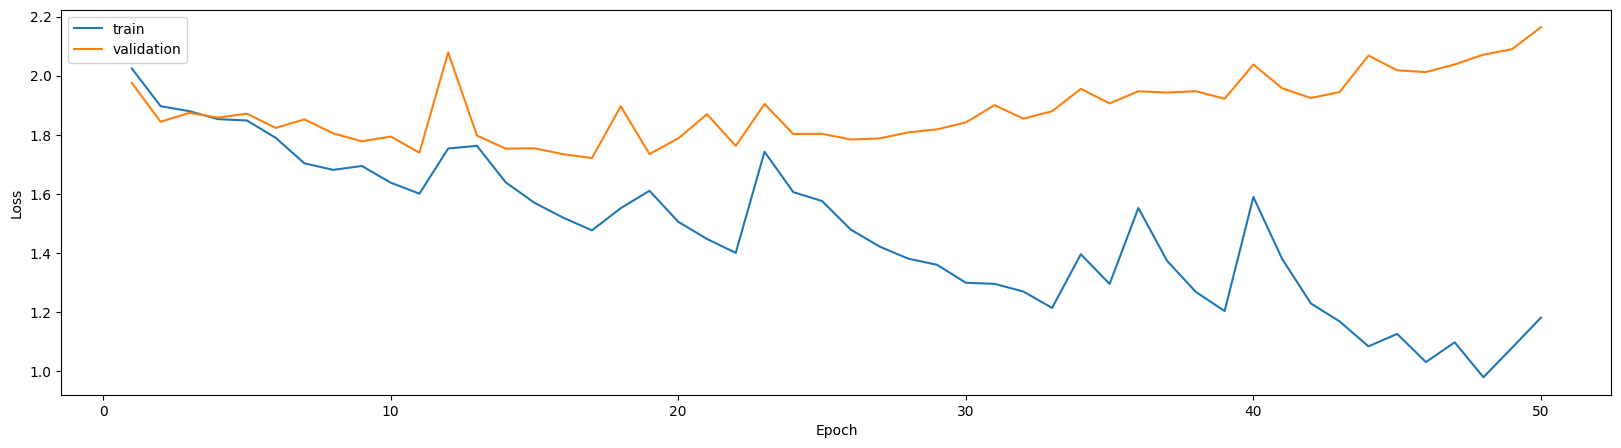

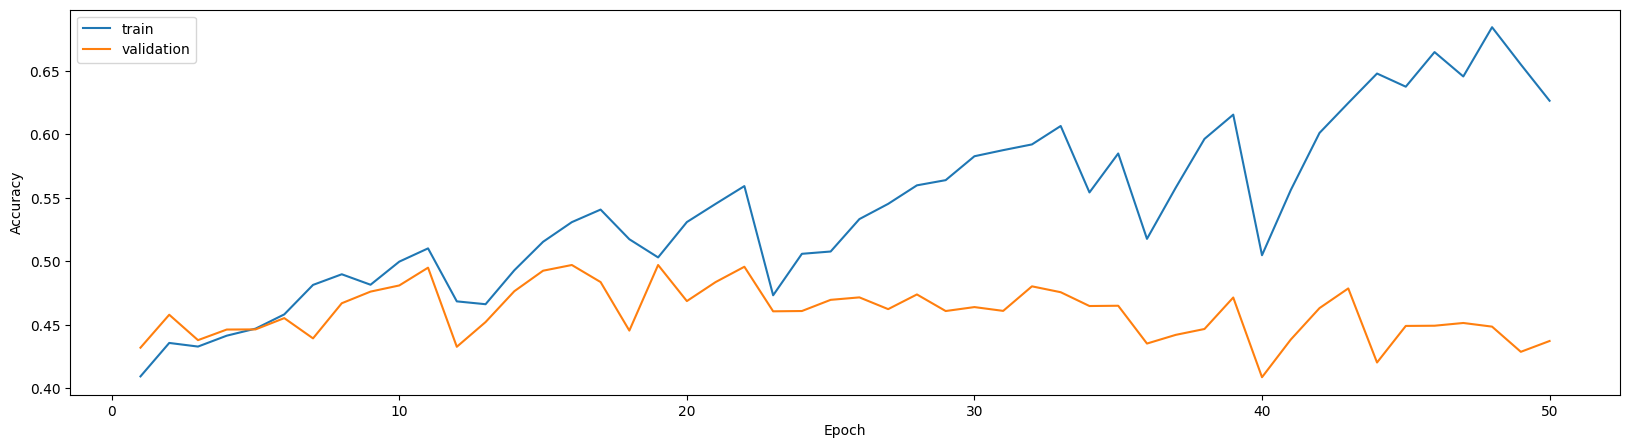

	Evaluation: 100%|██████████| 193/193 [00:01<00:00, 133.64it/s]



Test Loss: 1.708 | Test Acc: 48.94% | Test F1: 0.438 | Test ROC AUC: 0.782

Classification report:
              precision    recall  f1-score   support

           0       0.53      0.77      0.63      4960
           1       0.53      0.43      0.48       647
           2       0.36      0.31      0.34      1116
           3       0.33      0.22      0.26       690
           4       0.20      0.02      0.04       849
           5       0.32      0.17      0.22       142
           6       0.12      0.04      0.06       325
           7       0.33      0.43      0.37       557
           8       0.27      0.02      0.04       172
           9       0.72      0.65      0.68       595
          10       0.21      0.01      0.02       594
          11       0.27      0.23      0.25       231
          12       0.53      0.73      0.62       816
          13       0.33      0.17      0.23       646

    accuracy                           0.49     12340
   macro avg       0.36      0.30 

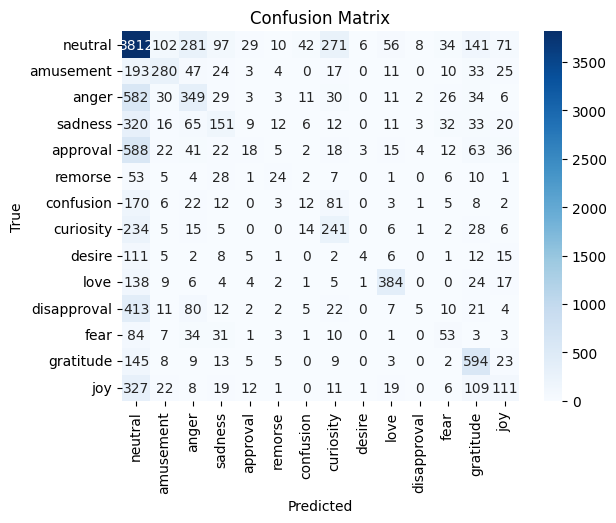

In [ ]:
# plot training curves

import matplotlib.pyplot as plt

# create epoch list
epochs = list(range(1, N_EPOCHS+1))

# plot training and validation loss
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, valid_loss_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(20, 5))
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, valid_acc_list, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#######
# print out required metrics

import seaborn as sns
model_glove_twitter_2.load_state_dict(torch.load('model_glove_twitter_2.pt'))

test_loss, test_acc, test_f1, test_roc_auc, test_report, test_cm = evaluate(model_glove_twitter_2, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f} | Test ROC AUC: {test_roc_auc:.3f}\n')
# print(f'Confusion matrix:\n{test_cm}')
print(f'Classification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



---



---



---

## Results

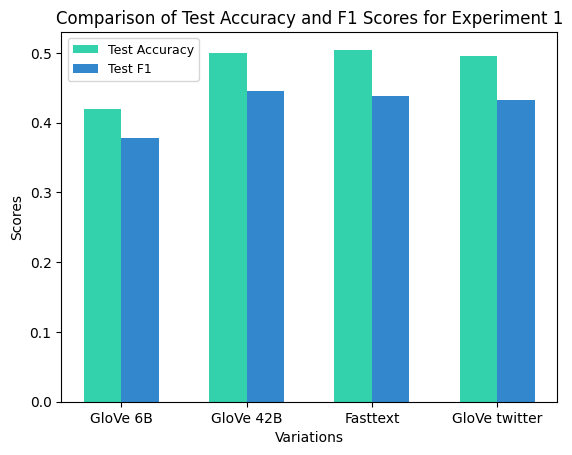

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

variations = ['GloVe 6B', 'GloVe 42B', 'Fasttext', 'GloVe twitter']
test_accuracy_list = [0.4192, 0.4996, 0.5046, 0.4960]
test_f1_list = [0.378, 0.445, 0.438, 0.433]

fig, ax = plt.subplots()

# Create x-axis values so it can be used for any number of variations
x_values = np.arange(len(variations))

# Plot the bar charts
rects1 = ax.bar(x_values, test_accuracy_list, 0.3, alpha=0.8, color='#00c698', label='Test Accuracy')
rects2 = ax.bar(x_values + 0.3, test_f1_list, 0.3, alpha=0.8, color='#0069c0', label='Test F1')

# Add labels and titles
ax.set_xlabel('Variations')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Test Accuracy and F1 Scores for Experiment 1')
ax.set_xticks(x_values + 0.3 / 2)
ax.set_xticklabels(variations)
ax.legend(loc='upper left', fontsize=9)

# Show the plot
plt.show()




---





---



---

## Conclusion



---
---
---

